# Разработка модели для предсказания риска наступления сердченого приступа


## Описание задачи

Нам предстоит:
1. разработать модель для предсказания риска сердечного приступа, используя данные пациентов, такие как возраст, привычки, состояние здоровья и результаты анализа крови.
2. также сделать для нее приложение для получения предсказаний по пользовательскому запросу.

## Описание данных

**Данные представлены в виде 2 **csv** файлов(обучающая и тестовая выборки), они содержат информацию о пациентах:**

- id  - идентификационный номер
- антропометрические параметры (вес, возраст, рост)
- привычки (курение, качество сна и т.д)
- давление
- наличие хронических заболеваний
- биохимия крови
- *целевой признак* - высокий или низкий риск поражения сердца


## Предварительный план

- для начала откроем наши наборы данных, посмотрим что лежит внутри
- проведем предобработку данных, где приведем данные к необходимым типам данных, найдем пропуски и решим как с ними работать, далее мы исследуем наш набор данных на наличие явных и неявных дубликатов
- проведем исследовательский анализ данных и решим каким образом будем их готовить к машинному обучению
- проведем корреляционный анализ признаков в наборах данных
- соберем необходимые пайплайны
- обучим разные модели и посмотрим на результаты их работы
- сделаем выводы о результатах моделирования

In [63]:
# необходимые для работы библиотеки 

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from phik.report import plot_correlation_matrix

import optuna
import optuna_integration
from optuna.distributions import IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV

import lightgbm as lgb

import catboost as cb

import xgboost as xgb

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# изменим стандартные параметры, чтобы иметь возможность отобразить все столбцы
pd.options.display.max_columns = None

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

Создадим класс для работы с датафреймом.

In [64]:
# настроим стиль визуализаций
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 6)

class DataExplorer:
    """
    Класс для первичного разведочного анализа данных (EDA).
    Позволяет быстро загрузить данные и получить основную информацию.
    
    Атрибуты:
    ----------
    filepath : str
        Путь к файлу с данными (CSV или Excel).
    df : pd.DataFrame
        Загруженный датафрейм.
        
    Методы:
    -------
    show_basic_info():
        Выводит основную информацию: первые 5 строк, типы данных, пропуски и размерность.
    summarize_missing_values():
        Возвращает сводку по пропущенным значениям.
    describe_numerical():
        Выводит описательную статистику для числовых признаков.
    describe_categorical():
        Выводит информацию о значениях для категориальных признаков.
    visualize_distributions():
        Строит гистограммы для всех числовых признаков.
    visualize_correlations():
        Строит тепловую карту корреляций для числовых признаков.
    """
    def __init__(self, filepath: str):
        """
        Инициализирует класс, загружая данные из указанного файла.
        """
        self.filepath = filepath
        try:
            self.df = self._load_data()
            print(f"✅ Данные успешно загружены из файла: '{filepath}'")
            print(f"   Размерность данных: {self.df.shape[0]} строк, {self.df.shape[1]} столбцов.")
        except FileNotFoundError:
            print(f"❌ Ошибка: Файл не найден по пути '{filepath}'")
            self.df = None
        except Exception as e:
            print(f"❌ Произошла ошибка при загрузке данных: {e}")
            self.df = None

    def _load_data(self) -> pd.DataFrame:
        """Внутренний метод для загрузки данных в зависимости от расширения файла."""
        if self.filepath.endswith('.csv'):
            return pd.read_csv(self.filepath)
        elif self.filepath.endswith(('.xls', '.xlsx')):
            return pd.read_excel(self.filepath)
        else:
            raise ValueError("Неподдерживаемый формат файла. Используйте .csv или .xlsx")

    def show_basic_info(self):
        """Выводит базовую информацию о датафрейме."""
        if self.df is None:
            print("Датафрейм не загружен.")
            return
        
        print("\n--- 1. Первые 5 строк данных ---")
        display(self.df.head())
        
        print("\n--- 2. Информация о типах данных и пропусках ---")
        self.df.info()

    def summarize_missing_values(self):
        """Создает и выводит сводную таблицу по пропущенным значениям."""
        if self.df is None:
            print("Датафрейм не загружен.")
            return

        print("\n--- 3. Сводка по пропущенным значениям ---")
        missing_values = self.df.isnull().sum()
        missing_percent = (missing_values / len(self.df) * 100).round(2)
        missing_df = pd.DataFrame({
            'Кол-во пропусков': missing_values,
            'Процент пропусков (%)': missing_percent
        })
        missing_df = missing_df[missing_df['Кол-во пропусков'] > 0].sort_values(
            by='Кол-во пропусков', ascending=False
        )
        
        if missing_df.empty:
            print("✅ Отлично! Пропущенных значений не найдено.")
        else:
            display(missing_df)
        # return missing_df

    def describe_numerical(self):
        """Выводит описательные статистики для числовых столбцов."""
        if self.df is None:
            print("Датафрейм не загружен.")
            return
            
        print("\n--- 4. Описательная статистика для числовых признаков ---")
        numerical_df = self.df.select_dtypes(include=np.number)
        if numerical_df.empty:
            print("Числовые признаки не найдены.")
        else:
            display(numerical_df.describe().T)

    def describe_categorical(self):
        """Выводит информацию о значениях для категориальных/объектных столбцов."""
        if self.df is None:
            print("Датафрейм не загружен.")
            return
            
        print("\n--- 5. Анализ категориальных признаков ---")
        categorical_df = self.df.select_dtypes(include=['object', 'category'])
        if categorical_df.empty:
            print("Категориальные признаки не найдены.")
        else:
            for col in categorical_df.columns:
                print(f"\nАнализ столбца: '{col}'")
                print(f"Количество уникальных значений: {self.df[col].nunique()}")
                display(self.df[col].value_counts(normalize=True).head(10).to_frame())

    def visualize_distributions(self, columns: list = []):
        """Строит гистограммы для всех числовых столбцов."""
        for col in columns:
            # Описательная статистика
            print("\nОписательная статистика:\n")
            print(self.df[col].describe())
            
            # График 'ящик с усами'
            plt.figure(figsize=(15, 2))
            sns.boxplot(data=self.df[col], orient='h')
            plt.title(f'Ящик с "усами" для столбца {col}')
            plt.xlabel('Значения')
            plt.ylabel('Признаки')
            plt.grid()
            plt.show();
            
            # Гистограмма распределения
            plt.figure(figsize=(10, 5))
            sns.histplot(self.df[col], kde=True, color='skyblue')
            plt.title(f'Гистограмма распределения для столбца {col}')
            plt.xlabel(col)
            plt.ylabel('Частота')
            plt.grid()
            plt.show();
            
            # Статистика выбросов
            print("\nСтатистика выбросов:\n")
            q1 = self.df[col].quantile(0.25)
            q3 = self.df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
            print(f"{col}: {len(outliers)} выбросов\n")
            # разделитель
            print("-" * 150)

    def visualize_discrete(self, columns: list = []):
        """Строит countplot для всех дискретных столбцов."""
        for col in columns:
            plt.title(f'Столбчатая диаграмма для столбца {col}')
            # Гистограмма распределения
            sns.countplot(
                data=self.df, 
                x=col,
            )
            ax = plt.gca()
            ax.bar_label(ax.containers[0], fontsize=10);
            plt.show();

    def visualize_categorical(self, columns: list = []):
        """Строит графики для всех категориальных столбцов."""
        for col in columns:
            # Статистика по уникальным значениям
            print("\nСтатистика уникальных значений:\n")
            display(self.df[col].value_counts(dropna=False).to_frame())
            print(f"Количество уникальных значений: {self.df[col].nunique()}")
            print("-"*150)
            
            # График перевернутой столбчатой диаграммы
            plt.figure(figsize=(15, 2))
            sns.barplot(x=self.df[col].value_counts().values, 
                        y=self.df[col].value_counts().index, 
                        )
            plt.title(f'Перевернутая столбчатая диаграмма для столбца {col}')
            plt.xlabel('Количество')
            plt.ylabel(col)
            plt.grid()
            plt.show()
            
            # Статистика баланса классов
            class_balance = self.df[col].value_counts()
            plt.figure(figsize=(15, 2))
            plt.pie(
                class_balance, 
                autopct='%1.1f%%', 
                startangle=90, 
                labels=class_balance.index, 
                textprops={'fontsize': 8, 'color': 'black', 'fontweight': 'bold'}
                )
            plt.title(f'Соотношение значений {col}')
            plt.xlabel('Процент от общего числа')
            plt.grid()
            plt.show()
            print("-"*150)

    def visualize_correlations(self):
        """Строит тепловую карту корреляций."""
        if self.df is None:
            print("Датафрейм не загружен.")
            return

        print("\n--- 7. Тепловая карта корреляций ---")
        corr_matrix = self.df.corr(numeric_only=True)
        
        if corr_matrix.empty:
            print("Не удалось рассчитать матрицу корреляций (нет числовых признаков).")
            return
            
        plt.figure(figsize=(12, 9))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Матрица корреляций числовых признаков', size=16)
        plt.show()

Откроем тренировочный датасет и посомтрим что там хранится внтури.

In [65]:
heart_train = DataExplorer(filepath='heart_train.csv')
heart_train_df = heart_train.df

✅ Данные успешно загружены из файла: 'heart_train.csv'
   Размерность данных: 8685 строк, 28 столбцов.


In [66]:
# базовая информация
heart_train.show_basic_info()

# анализ пропусков
heart_train.summarize_missing_values()


--- 1. Первые 5 строк данных ---


Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.359551     0.732143    0.074244       1.0             1.0   
1           1  0.202247     0.325000    0.047663       1.0             1.0   
2           2  0.606742     0.860714    0.055912       1.0             0.0   
3           3  0.730337     0.007143    0.053162       0.0             0.0   
4           4  0.775281     0.757143    0.021998       0.0             0.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0      1.0      1.0                  1.0                 0.535505     1   
1      0.0      0.0                  1.0                 0.068690     2   
2      1.0      1.0                  1.0                 0.944001     2   
3      1.0      0.0                  1.0                 0.697023     0   
4      1.0      0.0                  1.0                 0.412878     1   

   Previous Heart Problems  Medication Use  Stress Level  \
0                      1.0             0.0           8.0   
1                      1.0             0.0           9.0   
2                      1.0             1.0           6.0   
3                      0.0             1.0           3.0   
4                      0.0             0.0           8.0   

   Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1                         0.0     0.150198  0.017616  0.000194  Female   
2                         0.0     0.227018  0.048229  0.036512  Female   
3                         1.0     0.227018  0.048229  0.036512  Female   
4                         1.0     0.227018  0.048229  0.036512    Male   

   Systolic blood pressure  Diastolic blood pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047


--- 2. Информация о типах данных и пропусках ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems         

Кол-во пропусков  Процент пропусков (%)
Diabetes                                      243                    2.8
Family History                                243                    2.8
Smoking                                       243                    2.8
Obesity                                       243                    2.8
Alcohol Consumption                           243                    2.8
Previous Heart Problems                       243                    2.8
Medication Use                                243                    2.8
Stress Level                                  243                    2.8
Physical Activity Days Per Week               243                    2.8

При первичном знакомстве с датасетом видно что бОльшая часть данных уже представлена в закодированном виде. Типы данных столбцов соотвествуют хранящимся в них значениям. Выявленные недостатки:
- незакодированным у нас остается столбец, содержащий информацию о гендере
- для имен столбцов не используется корректный стиль именования
- присутствуют пропуски, их объем небольшой, на этапе предобработки посомтрим на эти строки
- так же есть лишний столбец не несущий в себе никаких данных **"Unnamed: 0"**

При всем этом дополнительно необходимо перевести на русский язык большинство названий столбцов и расскрыть суть этих параметров.

Теперь откроем и посомтрим на тестовый датасет.

In [67]:
heart_test = DataExplorer(filepath='heart_test.csv')
heart_test_df = heart_test.df

✅ Данные успешно загружены из файла: 'heart_test.csv'
   Размерность данных: 966 строк, 27 столбцов.


In [68]:
# базовая информация
heart_test.show_basic_info()

# анализ пропусков
heart_test.summarize_missing_values()


--- 1. Первые 5 строк данных ---


Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.494382     0.264286    0.062328       0.0             1.0   
1           1  0.224719     0.953571    0.082493       1.0             0.0   
2           2  0.629213     0.092857    0.064161       0.0             1.0   
3           3  0.460674     0.567857    0.055912       1.0             1.0   
4           4  0.719101     0.485714    0.022915       1.0             0.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0      1.0      1.0                  1.0                 0.361618     2   
1      0.0      1.0                  0.0                 0.996483     2   
2      1.0      1.0                  0.0                 0.995561     0   
3      1.0      1.0                  1.0                 0.437277     0   
4      1.0      0.0                  1.0                 0.514920     0   

   Previous Heart Problems  Medication Use  Stress Level  \
0                      0.0             0.0           8.0   
1                      1.0             1.0           5.0   
2                      0.0             0.0          10.0   
3                      0.0             0.0          10.0   
4                      0.0             0.0           7.0   

   Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                 0.194370  0.587759  0.283490       0.306494   
1                 0.329888  0.602883  0.467036       0.087013   
2                 0.780075  0.370436  0.409366       0.205195   
3                 0.785071  0.368242  0.910261       0.163636   
4                 0.070919  0.729578  0.758924       0.580519   

   Physical Activity Days Per Week  Sleep Hours Per Day  Blood sugar  \
0                              1.0             0.333333     0.227018   
1                              0.0             0.166667     0.227018   
2                              7.0             1.000000     0.102767   
3                              0.0             0.666667     0.203557   
4                              5.0             0.000000     0.227018   

      CK-MB  Troponin  Gender  Systolic blood pressure  \
0  0.048229  0.036512    Male                 0.283871   
1  0.048229  0.036512  Female                 0.703226   
2  0.002666  0.088455    Male                 0.458065   
3  0.056390  0.271774  Female                 0.741935   
4  0.048229  0.036512    Male                 0.412903   

   Diastolic blood pressure    id  
0                  0.372093  7746  
1                  0.441860  4202  
2                  0.779070  6632  
3                  0.255814  4639  
4                  0.395349  4825


--- 2. Информация о типах данных и пропусках ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          9

Кол-во пропусков  Процент пропусков (%)
Diabetes                                       31                   3.21
Family History                                 31                   3.21
Smoking                                        31                   3.21
Obesity                                        31                   3.21
Alcohol Consumption                            31                   3.21
Previous Heart Problems                        31                   3.21
Medication Use                                 31                   3.21
Stress Level                                   31                   3.21
Physical Activity Days Per Week                31                   3.21

В тестовом наборе данных имеются точно такие же особенности и недостатки как и в тренировочном датасете.

**Промежуточный вывод**

В целом с данными мы познакомились, часть из них уже находится в закодированном виде, имеются оперделенные недостатки(указаны выше после загрузки тренировочного датасета), которые мы начнем устранять на следующем этапе предобработки.

##  Предобработка данных

Начнем с тренировочного датафрейма.

Возьмем датафрейм `heart_train` и переименуем столбцы.

In [69]:
heart_train_df.columns = heart_train_df.columns.str.lower()
heart_train_df.columns = heart_train_df.columns.str.replace(' ', '_')

In [70]:
heart_train_df

unnamed:_0       age  cholesterol  heart_rate  diabetes  family_history  \
0              0  0.359551     0.732143    0.074244       1.0             1.0   
1              1  0.202247     0.325000    0.047663       1.0             1.0   
2              2  0.606742     0.860714    0.055912       1.0             0.0   
3              3  0.730337     0.007143    0.053162       0.0             0.0   
4              4  0.775281     0.757143    0.021998       0.0             0.0   
...          ...       ...          ...         ...       ...             ...   
8680        8680  0.359551     0.357143    0.040330       1.0             0.0   
8681        8681  0.516854     0.832143    0.036664       1.0             1.0   
8682        8682  0.471910     0.067857    0.023831       1.0             0.0   
8683        8683  0.595506     0.000000    0.075160       0.0             1.0   
8684        8684  0.292135     0.342857    0.021082       0.0             1.0   

      smoking  obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0         1.0      1.0                  1.0                 0.535505     1   
1         0.0      0.0                  1.0                 0.068690     2   
2         1.0      1.0                  1.0                 0.944001     2   
3         1.0      0.0                  1.0                 0.697023     0   
4         1.0      0.0                  1.0                 0.412878     1   
...       ...      ...                  ...                      ...   ...   
8680      1.0      1.0                  1.0                 0.926662     2   
8681      1.0      1.0                  1.0                 0.455572     2   
8682      1.0      0.0                  1.0                 0.076336     2   
8683      1.0      0.0                  1.0                 0.371759     2   
8684      1.0      1.0                  0.0                 0.567079     0   

      previous_heart_problems  medication_use  stress_level  \
0                         1.0             0.0           8.0   
1                         1.0             0.0           9.0   
2                         1.0             1.0           6.0   
3                         0.0             1.0           3.0   
4                         0.0             0.0           8.0   
...                       ...             ...           ...   
8680                      1.0             0.0           6.0   
8681                      1.0             1.0           8.0   
8682                      0.0             1.0          10.0   
8683                      0.0             0.0           9.0   
8684                      0.0             0.0           9.0   

      sedentary_hours_per_day    income       bmi  triglycerides  \
0                    0.225704  0.105948  0.459176       0.979221   
1                    0.289923  0.164217  0.117053       0.515584   
2                    0.550133  0.598745  0.373574       0.012987   
3                    0.330962  0.077605  0.049735       0.131169   
4                    0.524600  0.341960  0.830405       0.070130   
...                       ...       ...       ...            ...   
8680                 0.184825  0.412145  0.292379       0.222078   
8681                 0.083490  0.295875  0.925992       0.396104   
8682                 0.997170  0.378114  0.077175       0.189610   
8683                 0.881231  0.554353  0.496346       0.892208   
8684                 0.169786  0.753330  0.990535       0.975325   

      physical_activity_days_per_week  sleep_hours_per_day  \
0                                 3.0             0.333333   
1                                 3.0             0.833333   
2                                 2.0             1.000000   
3                                 0.0             0.333333   
4                                 5.0             1.000000   
...                               ...                  ...   
8680                              0.0             0.166667   
8681                      

Теперь имена столбцов соответствуют общему стилю наименования. 

Удалим лишний столбец **"unnamed:_0"**.

In [71]:
heart_train_df.drop('unnamed:_0', axis=1, inplace=True)

In [72]:
heart_train_df.head(5)

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0  0.359551     0.732143    0.074244       1.0             1.0      1.0   
1  0.202247     0.325000    0.047663       1.0             1.0      0.0   
2  0.606742     0.860714    0.055912       1.0             0.0      1.0   
3  0.730337     0.007143    0.053162       0.0             0.0      1.0   
4  0.775281     0.757143    0.021998       0.0             0.0      1.0   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0      1.0                  1.0                 0.535505     1   
1      0.0                  1.0                 0.068690     2   
2      1.0                  1.0                 0.944001     2   
3      0.0                  1.0                 0.697023     0   
4      0.0                  1.0                 0.412878     1   

   previous_heart_problems  medication_use  stress_level  \
0                      1.0             0.0           8.0   
1                      1.0             0.0           9.0   
2                      1.0             1.0           6.0   
3                      0.0             1.0           3.0   
4                      0.0             0.0           8.0   

   sedentary_hours_per_day    income       bmi  triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   

   physical_activity_days_per_week  sleep_hours_per_day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   heart_attack_risk_(binary)  blood_sugar     ck-mb  troponin  gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1                         0.0     0.150198  0.017616  0.000194  Female   
2                         0.0     0.227018  0.048229  0.036512  Female   
3                         1.0     0.227018  0.048229  0.036512  Female   
4                         1.0     0.227018  0.048229  0.036512    Male   

   systolic_blood_pressure  diastolic_blood_pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047

Ненужный столбец мы удалили. Теперь посмотрим на строки с пропущенными значениями.

In [73]:
heart_train_df[heart_train_df.isna().any(axis=1)]

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
16    0.449438      0.49978    0.063245       NaN             NaN      NaN   
90    0.370787      0.49978    0.066911       NaN             NaN      NaN   
92    0.629213      0.49978    0.073327       NaN             NaN      NaN   
185   0.516854      0.49978    0.045830       NaN             NaN      NaN   
188   0.269663      0.49978    0.035747       NaN             NaN      NaN   
...        ...          ...         ...       ...             ...      ...   
8461  0.719101      0.49978    0.049496       NaN             NaN      NaN   
8509  0.651685      0.49978    0.036664       NaN             NaN      NaN   
8536  0.651685      0.49978    0.054079       NaN             NaN      NaN   
8619  0.606742      0.49978    0.059578       NaN             NaN      NaN   
8639  0.629213      0.49978    0.057745       NaN             NaN      NaN   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  \
16        NaN                  NaN                  0.50211     3   
90        NaN                  NaN                  0.50211     3   
92        NaN                  NaN                  0.50211     3   
185       NaN                  NaN                  0.50211     3   
188       NaN                  NaN                  0.50211     3   
...       ...                  ...                      ...   ...   
8461      NaN                  NaN                  0.50211     3   
8509      NaN                  NaN                  0.50211     3   
8536      NaN                  NaN                  0.50211     3   
8619      NaN                  NaN                  0.50211     3   
8639      NaN                  NaN                  0.50211     3   

      previous_heart_problems  medication_use  stress_level  \
16                        NaN             NaN           NaN   
90                        NaN             NaN           NaN   
92                        NaN             NaN           NaN   
185                       NaN             NaN           NaN   
188                       NaN             NaN           NaN   
...                       ...             ...           ...   
8461                      NaN             NaN           NaN   
8509                      NaN             NaN           NaN   
8536                      NaN             NaN           NaN   
8619                      NaN             NaN           NaN   
8639                      NaN             NaN           NaN   

      sedentary_hours_per_day    income       bmi  triglycerides  \
16                    0.49992  0.494889  0.494774       0.503603   
90                    0.49992  0.494889  0.494774       0.503603   
92                    0.49992  0.494889  0.494774       0.503603   
185                   0.49992  0.494889  0.494774       0.503603   
188                   0.49992  0.494889  0.494774       0.503603   
...                       ...       ...       ...            ...   
8461                  0.49992  0.494889  0.494774       0.503603   
8509                  0.49992  0.494889  0.494774       0.503603   
8536                  0.49992  0.494889  0.494774       0.503603   
8619                  0.49992  0.494889  0.494774       0.503603   
8639                  0.49992  0.494889  0.494774       0.503603   

      physical_activity_days_per_week  sleep_hours_per_day  \
16                                NaN             0.504621   
90                                NaN             0.504621   
92                                NaN             0.504621   
185                               NaN             0.504621   
188                               NaN             0.504621   
...                               ...                  ...   
8461                              NaN             0.504621   
8509                              NaN             0.504621   
8536                              NaN             0.504621   
8619                              NaN             0

Мы вывели датафрейм со строками, у которых есть хотя бы одно пропущенное значение в столбце. В результате получилось 243 строки, это значит что все пропуски имеющиеся в этом датасете принадлежат одним и тем же пациентам. Таких строк всего 2.8% от общего количества, к тому же пропущены значения только для 9 входных параметров из 25. Поэтому в данный момент мы оставим пропуски как есть, так как окончательно не знаем какие входные признаки будут использоваться для построения модели.

Проверим есть ли явные дубликаты в этом датафрейме и все ли **"id"** уникальны.

In [74]:
display(heart_train_df['id'].nunique())
heart_train_df.duplicated().sum()

8685

0

Явные дубликаты отсутствуют и все идентификационные номера уникальны.

Посмотрим на уникальные значения в категориальных столбцах.

In [75]:
cat_cols = [
    "diabetes",
    "family_history",
    "smoking",
    "obesity",
    "alcohol_consumption",
    "diet",
    "previous_heart_problems",
    "medication_use",
    "stress_level",
    "heart_attack_risk_(binary)",
    "gender",
    "physical_activity_days_per_week"
]

In [76]:
for col in cat_cols:
    print(col, heart_train_df[col].unique())

diabetes [ 1.  0. nan]
family_history [ 1.  0. nan]
smoking [ 1.  0. nan]
obesity [ 1.  0. nan]
alcohol_consumption [ 1.  0. nan]
diet [1 2 0 3]
previous_heart_problems [ 1.  0. nan]
medication_use [ 0.  1. nan]
stress_level [ 8.  9.  6.  3.  7.  1. 10. nan  2.  5.  4.]
heart_attack_risk_(binary) [0. 1.]
gender ['Male' 'Female' '1.0' '0.0']
physical_activity_days_per_week [ 3.  2.  0.  5.  6.  4.  7. nan  1.]


In [77]:
heart_train_df['gender'].value_counts()

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

В закодированной форме у нас пердставлены 243 записи, проверим что это за записи, возможно это строки с пропусками.

In [78]:
heart_train_df[heart_train_df.isna().any(axis=1)]['gender'].value_counts()

gender
1.0    156
0.0     87
Name: count, dtype: int64

Если сложить всю "картину" целиком, то можно увидеть что эти 243 строки являются специфическими, много параметров имеют одинаковые значения и для одних и тех же параметров имеются пропуски. В данном проекте у нас нету цели и достаточно времени, чтобы выявить природу этих данных, такие данные составляют 2.8% от общего объема данных, поэтому удалим их.

In [79]:
heart_train_df.drop(heart_train_df[heart_train_df.isna().any(axis=1)].index, axis=0, inplace=True)


In [80]:
heart_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8442 non-null   float64
 9   diet                             8442 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level             

Теперь проведем все те же манипуляции и для тестового датасета.

In [81]:
heart_test_df.columns = heart_test_df.columns.str.lower()
heart_test_df.columns = heart_test_df.columns.str.replace(' ', '_')
heart_test_df.drop('unnamed:_0', axis=1, inplace=True)

In [82]:
heart_test_df

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0    0.494382     0.264286    0.062328       0.0             1.0      1.0   
1    0.224719     0.953571    0.082493       1.0             0.0      0.0   
2    0.629213     0.092857    0.064161       0.0             1.0      1.0   
3    0.460674     0.567857    0.055912       1.0             1.0      1.0   
4    0.719101     0.485714    0.022915       1.0             0.0      1.0   
..        ...          ...         ...       ...             ...      ...   
961  0.640449     0.235714    0.064161       1.0             0.0      1.0   
962  0.516854     0.367857    0.063245       1.0             0.0      1.0   
963  0.213483     0.596429    0.076994       1.0             0.0      1.0   
964  0.337079     0.996429    0.036664       1.0             0.0      1.0   
965  0.359551     0.864286    0.061412       1.0             0.0      1.0   

     obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0        1.0                  1.0                 0.361618     2   
1        1.0                  0.0                 0.996483     2   
2        1.0                  0.0                 0.995561     0   
3        1.0                  1.0                 0.437277     0   
4        0.0                  1.0                 0.514920     0   
..       ...                  ...                      ...   ...   
961      0.0                  1.0                 0.449213     2   
962      0.0                  0.0                 0.563595     0   
963      1.0                  1.0                 0.549976     0   
964      0.0                  0.0                 0.441581     2   
965      1.0                  0.0                 0.234876     2   

     previous_heart_problems  medication_use  stress_level  \
0                        0.0             0.0           8.0   
1                        1.0             1.0           5.0   
2                        0.0             0.0          10.0   
3                        0.0             0.0          10.0   
4                        0.0             0.0           7.0   
..                       ...             ...           ...   
961                      1.0             1.0          10.0   
962                      0.0             0.0           8.0   
963                      0.0             1.0           2.0   
964                      0.0             1.0           5.0   
965                      0.0             1.0           1.0   

     sedentary_hours_per_day    income       bmi  triglycerides  \
0                   0.194370  0.587759  0.283490       0.306494   
1                   0.329888  0.602883  0.467036       0.087013   
2                   0.780075  0.370436  0.409366       0.205195   
3                   0.785071  0.368242  0.910261       0.163636   
4                   0.070919  0.729578  0.758924       0.580519   
..                       ...       ...       ...            ...   
961                 0.579899  0.657704  0.164893       0.283117   
962                 0.680240  0.608242  0.242904       0.422078   
963                 0.771651  0.710667  0.662209       0.914286   
964                 0.790726  0.533684  0.862390       0.850649   
965                 0.235260  0.571713  0.088066       0.572727   

     physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
0                                1.0             0.333333     0.227018   
1                                0.0             0.166667     0.227018   
2                                7.0             1.000000     0.102767   
3                                0.0             0.666667     0.203557   
4                                5.0             0.000000     0.227018   
..                               ...                  ...          ...   
961                              5.0             0.000000     0.110672   
962                              2.0             0.000000     0.114625   
963                              4.0             0.6

Столбцы переименованы, лишний столбец удален, теперь посмотрим на пропуски.

In [83]:
display(heart_test_df[heart_test_df.isna().any(axis=1)].shape[0])
heart_test_df[heart_test_df.isna().any(axis=1)]

31

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
27   0.370787      0.49978    0.034830       NaN             NaN      NaN   
37   0.573034      0.49978    0.043080       NaN             NaN      NaN   
58   0.516854      0.49978    0.045830       NaN             NaN      NaN   
60   0.370787      0.49978    0.056829       NaN             NaN      NaN   
61   0.483146      0.49978    0.028414       NaN             NaN      NaN   
156  0.516854      0.49978    0.045830       NaN             NaN      NaN   
208  0.449438      0.49978    0.036664       NaN             NaN      NaN   
235  0.325843      0.49978    0.029331       NaN             NaN      NaN   
265  0.471910      0.49978    0.056829       NaN             NaN      NaN   
339  0.348315      0.49978    0.054079       NaN             NaN      NaN   
352  0.606742      0.49978    0.048579       NaN             NaN      NaN   
397  0.629213      0.49978    0.084326       NaN             NaN      NaN   
423  0.584270      0.49978    0.043996       NaN             NaN      NaN   
456  0.348315      0.49978    1.000000       NaN             NaN      NaN   
475  0.280899      0.49978    0.037580       NaN             NaN      NaN   
484  0.617978      0.49978    0.090742       NaN             NaN      NaN   
555  0.325843      0.49978    0.029331       NaN             NaN      NaN   
563  0.516854      0.49978    0.084326       NaN             NaN      NaN   
602  0.629213      0.49978    0.069661       NaN             NaN      NaN   
631  0.573034      0.49978    0.049496       NaN             NaN      NaN   
634  0.303371      0.49978    0.080660       NaN             NaN      NaN   
651  0.348315      0.49978    0.076077       NaN             NaN      NaN   
699  0.314607      0.49978    0.000000       NaN             NaN      NaN   
731  0.438202      0.49978    0.048579       NaN             NaN      NaN   
758  0.550562      0.49978    0.085243       NaN             NaN      NaN   
771  0.606742      0.49978    0.048579       NaN             NaN      NaN   
817  0.438202      0.49978    0.054995       NaN             NaN      NaN   
826  0.426966      0.49978    0.034830       NaN             NaN      NaN   
838  0.629213      0.49978    0.057745       NaN             NaN      NaN   
920  0.651685      0.49978    0.057745       NaN             NaN      NaN   
921  0.550562      0.49978    0.040330       NaN             NaN      NaN   

     obesity  alcohol_consumption  exercise_hours_per_week  diet  \
27       NaN                  NaN                  0.50211     3   
37       NaN                  NaN                  0.50211     3   
58       NaN                  NaN                  0.50211     3   
60       NaN                  NaN                  0.50211     3   
61       NaN                  NaN                  0.50211     3   
156      NaN                  NaN                  0.50211     3   
208      NaN                  NaN                  0.50211     3   
235      NaN                  NaN                  0.50211     3   
265      NaN                  NaN                  0.50211     3   
339      NaN                  NaN                  0.50211     3   
352      NaN                  NaN                  0.50211     3   
397      NaN                  NaN                  0.50211     3   
423      NaN                  NaN                  0.50211     3   
456      NaN                  NaN                  0.50211     3   
475      NaN                  NaN                  0.50211     3   
484      NaN                  NaN                  0.50211     3   
555      NaN                  NaN                  0.50211     3   
563      NaN                  NaN                  0.50211     3   
602      NaN                  NaN                  0.50211     3   
631      NaN                  NaN                  0.50211     3   
634      NaN                  NaN                  0.50211     3   
651      NaN                  NaN                

Тут точно такая же ситуация как и с тренировочным датасетом: отсутствуют значения для таких же входных признаков и одновременно для одних и тех же пациентов.

Посмотрим есть ли явные дубликаты и все ли идентификационные номера уникальны.

In [84]:
display(heart_test_df['id'].nunique())
heart_test_df.duplicated().sum()

966

0

Посомтрим на значения в категорилаьных столбцах.

In [85]:
cat_cols.remove('heart_attack_risk_(binary)')

for col in cat_cols:
    print(col, heart_test_df[col].unique())

diabetes [ 0.  1. nan]
family_history [ 1.  0. nan]
smoking [ 1.  0. nan]
obesity [ 1.  0. nan]
alcohol_consumption [ 1.  0. nan]
diet [2 0 1 3]
previous_heart_problems [ 0.  1. nan]
medication_use [ 0.  1. nan]
stress_level [ 8.  5. 10.  7.  1.  4.  9.  6.  3. nan  2.]
gender ['Male' 'Female' '1.0' '0.0']
physical_activity_days_per_week [ 1.  0.  7.  5.  3.  2.  4.  6. nan]


In [86]:
heart_test_df['gender'].value_counts()

gender
Male      650
Female    285
1.0        22
0.0         9
Name: count, dtype: int64

In [87]:
heart_test_df[heart_test_df.isna().any(axis=1)]['gender'].value_counts()

gender
1.0    22
0.0     9
Name: count, dtype: int64

Тут ситуация один в один как и с тренировочным датасетом, поэтому удаляем эти строки.

In [88]:
heart_test_df.drop(heart_test_df[heart_test_df.isna().any(axis=1)].index, axis=0, inplace=True)


In [89]:
heart_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              935 non-null    float64
 1   cholesterol                      935 non-null    float64
 2   heart_rate                       935 non-null    float64
 3   diabetes                         935 non-null    float64
 4   family_history                   935 non-null    float64
 5   smoking                          935 non-null    float64
 6   obesity                          935 non-null    float64
 7   alcohol_consumption              935 non-null    float64
 8   exercise_hours_per_week          935 non-null    float64
 9   diet                             935 non-null    int64  
 10  previous_heart_problems          935 non-null    float64
 11  medication_use                   935 non-null    float64
 12  stress_level               

**Промежуточный итог**

- наименования столбцов приведены к корректным
- лишний столбец удален
- учитывая особенности данных с пропусками и их количество, мы приняли решение удалить эти строки
- один столбец со значениями гендера мы закодируем на этапе подготовки данных к обучению

## Исследовательский анализ данных

Исследуем датафреймы `heart_train_df` и `heart_test_df` по очереди.

При анализе тестовой выборки, необходимо посмотреть и учесть как изменились значения признаков в ней по сравнению с обучающей.

Но сперва мы начнем с исследования предметной области(суперочевидные параметры, например **"age"** мы не будем ни переводить, ни расшифровывать):
- переведем параметры на русский язык для улучшения понимания
- расшифруем суть этих параметров, что именно они отображают

Возможно после этого этапа нам сразу удастся "отсеять" некоторые признаки.

In [90]:
heart_train_df.columns

Index(['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history',
       'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week',
       'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day',
       'heart_attack_risk_(binary)', 'blood_sugar', 'ck-mb', 'troponin',
       'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')

- `cholesterol` - холестерин. Высокий уровень ЛПНП-холестерина запускает каскад событий, известный как атеросклероз, который является основной причиной большинства сердечных приступов. [https://medlineplus.gov/cholesterol.html]
- `heart_rate` - частота сердечных сокращений. Частота сердечных сокращений (ЧСС) в состоянии покоя, показатель, который легко измерить самостоятельно, является важным и независимым фактором риска развития сердечного приступа (инфаркта миокарда) и других сердечно-сосудистых осложнений.
- `diabetes` - наличие диабета. Наличие сахарного диабета — это один из самых серьезных факторов риска развития сердечного приступа (инфаркта миокарда). Эта связь настолько сильна, что диабет часто называют "эквивалентом ишемической болезни сердца".
- `family_history` - семейный анамнез. В нашем случае признак бинарный и каких-то дополнительных расшифровок нету, а значит скорее всего он просто указывает 1, если у кого-то в семье были серьезные наследственные заболевания, и 0, если нет.
- `obesity` - ожирение. Ожирение является одним из наиболее значимых и многогранных факторов риска развития сердечного приступа (инфаркта миокарда).
- `alcohol_consumption` - потребление алкоголя. Связь с риском наступления сердечного приступа нелинейна и полностью зависит от дозы. Необходимо обратить на этот параметр внимание во время корреляционного анализа.
- `exercise_hours_per_week` - количество часов физической активности в неделю, которое проводит человек. Физическая активность — это один из самых эффективных и доступных способов значительно снизить риск развития сердечного приступа (инфаркта миокарда). Взаимосвязь между движением и здоровьем сердца прямая и неоспоримая: чем активнее человек, тем ниже его шансы столкнуться с сердечно-сосудистой катастрофой. 
- `diet` - диета. Рацион питания напрямую воздействует на основные факторы, провоцирующие сердечный приступ.
- `previous_heart_problems` - наличие предыдущих проблем с сердцем.
- `medication_use` - использование лекарств. Постоянное использование медикаментов оказывает глубокое и разнонаправленное влияние на риск наступления сердечного приступа (инфаркта миокарда). В зависимости от типа препарата, он может служить как мощным защитным фактором, так и, наоборот, повышать вероятность сердечно-сосудистой катастрофы. Поэтому возможно мы исключим этот признак на этапе обучения по результатам корреляционного анализа, так как у нас нету дополнительной информации об этом параметре.
- `sedentary_hours_per_day` - количество часов, которое проводит человек сидя.
- `income` - доход.
- `bmi` - индекс массы тела. Величина, позволяющая оценить степень соответствия массы человека и его роста и тем самым косвенно судить о том, является ли масса недостаточной, нормальной или избыточной.
- `triglycerides` - жиры, также триглицериды, триацилглицериды. Высокий уровень триглицеридов в крови напрямую и значительно повышает риск сердечного приступа. Хотя сами по себе триглицериды не являются частью бляшек, закупоривающих артерии, они активно способствуют развитию атеросклероза — основной причины инфарктов и инсультов. [https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/triglycerides/art-20048186] [https://my.clevelandclinic.org/health/articles/11117-triglycerides]
- `blood_sugar` - уровень сахара в крови. Поддержание стабильного уровня сахара в крови в пределах целевых значений является критически важным для снижения риска сердечного приступа, особенно для людей с сахарным диабетом.
- `ck-mb` - CK-MB, или креатинкиназа-МВ, — это специфический медицинский показатель, используемый в основном для диагностики повреждений сердечной мышцы (миокарда). 
Основное применение анализа на CK-MB в медицине — это диагностика повреждений миокарда, в первую очередь, острого инфаркта миокарда (сердечного приступа).[https://progen.ru/services/laboratornye-issledovaniya/biokhimicheskie-issledovaniya-krovi/biokhimicheskiy-analiz-krovi-na-kreatinkinazu-mv-kk-mb/] Когда клетки сердечной мышцы повреждаются из-за недостатка кровоснабжения, они разрушаются, и их содержимое, включая CK-MB, попадает в кровоток.
- `troponin` - тропонин является ключевым белком, который напрямую связан с диагностикой сердечного приступа (инфаркта миокарда) и оценкой риска будущих сердечно-сосудистых событий. Его уровень в крови — это один из самых точных индикаторов повреждения сердечной мышцы. [https://helix.ru/kb/item/06-076].
- `systolic_blood_pressure` - систолическое кровяное давление. Верхний показатель при измерении артериального давления — является важнейшим фактором, напрямую связанным с риском развития сердечного приступа (инфаркта миокарда). [https://pmc.ncbi.nlm.nih.gov/articles/PMC9942105/]
- `diastolic_blood_pressure` - диастолическое кровяное давление. Диастолическое артериальное давление, или «нижнее» число в показаниях тонометра, играет сложную, но критически важную роль в оценке риска сердечного приступа. [https://sertsa.com/ru/diastolicheskoe-davlenie/]

На основе вышеуказанной информации мы точно исключим параметр `income`, так как он имеет очень косвенное влияние на риск наступления сердченого приступа. И обратим внимание на параметры `alcohol_consumption` и `medication_use` на этапе корреляционного анализа.

Теперь приступим к самому анализу данных, начиная с тренировочного датасета. Определим наборы дискретных, непрерывных количественных и категориальных парметров.

In [91]:
heart_train_df.drop('income', axis=1, inplace=True)
heart_test_df.drop('income', axis=1, inplace=True)

In [92]:
heart_train_df.sample(5)

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
3475  0.112360     0.796429    0.042163       1.0             0.0      0.0   
3862  0.213483     0.885714    0.067828       1.0             1.0      1.0   
5279  0.539326     0.175000    0.065995       0.0             1.0      1.0   
5967  0.123596     0.164286    0.027498       1.0             0.0      0.0   
4254  0.640449     0.696429    0.059578       1.0             1.0      1.0   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  \
3475      1.0                  1.0                 0.574988     0   
3862      1.0                  1.0                 0.869176     1   
5279      0.0                  1.0                 0.301123     0   
5967      0.0                  0.0                 0.586899     1   
4254      1.0                  1.0                 0.601518     1   

      previous_heart_problems  medication_use  stress_level  \
3475                      1.0             1.0           5.0   
3862                      1.0             0.0           8.0   
5279                      1.0             0.0           4.0   
5967                      1.0             1.0           1.0   
4254                      1.0             1.0           8.0   

      sedentary_hours_per_day       bmi  triglycerides  \
3475                 0.364024  0.769001       0.823377   
3862                 0.377805  0.557476       0.588312   
5279                 0.131310  0.028621       0.337662   
5967                 0.213287  0.043106       0.420779   
4254                 0.941598  0.064890       0.389610   

      physical_activity_days_per_week  sleep_hours_per_day  \
3475                              3.0             0.666667   
3862                              3.0             0.333333   
5279                              7.0             0.000000   
5967                              6.0             1.000000   
4254                              4.0             1.000000   

      heart_attack_risk_(binary)  blood_sugar     ck-mb  troponin  gender  \
3475                         0.0     0.227018  0.048229  0.036512  Female   
3862                         1.0     0.227018  0.048229  0.036512    Male   
5279                         1.0     0.227018  0.048229  0.036512    Male   
5967                         1.0     0.227018  0.048229  0.036512  Female   
4254                         0.0     0.227018  0.048229  0.036512  Female   

      systolic_blood_pressure  diastolic_blood_pressure    id  
3475                 0.425806                  0.337209  4298  
3862                 0.464516                  0.337209  5254  
5279                 0.335484                  0.767442  3650  
5967                 0.432258                  0.476744  9231  
4254                 0.574194                  0.779070  2366

In [93]:
num_cols = [
    "age",
    "cholesterol",
    "heart_rate",
    "exercise_hours_per_week",
    "sedentary_hours_per_day",
    "bmi",
    "triglycerides",
    "sleep_hours_per_day",
    "blood_sugar",
    "ck-mb",
    "troponin",
    "systolic_blood_pressure",
    "diastolic_blood_pressure"
]

discrete_cols = [
    "diet",
    "stress_level",
    "physical_activity_days_per_week"
]

cat_cols = [
    "gender",
    "diabetes",
    "family_history",
    "smoking",
    "obesity",
    "alcohol_consumption",
    "previous_heart_problems",
    "medication_use",
    "heart_attack_risk_(binary)"
]

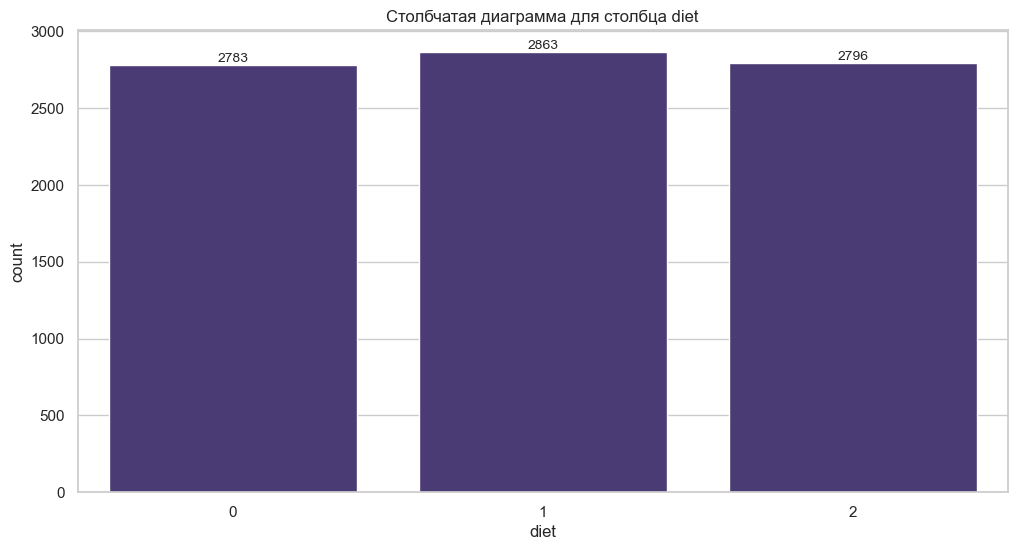

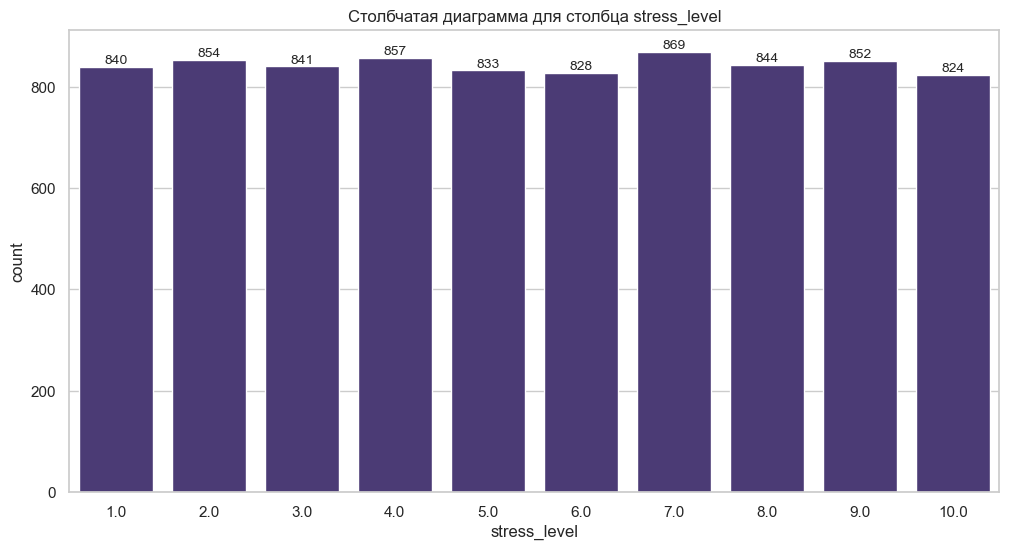

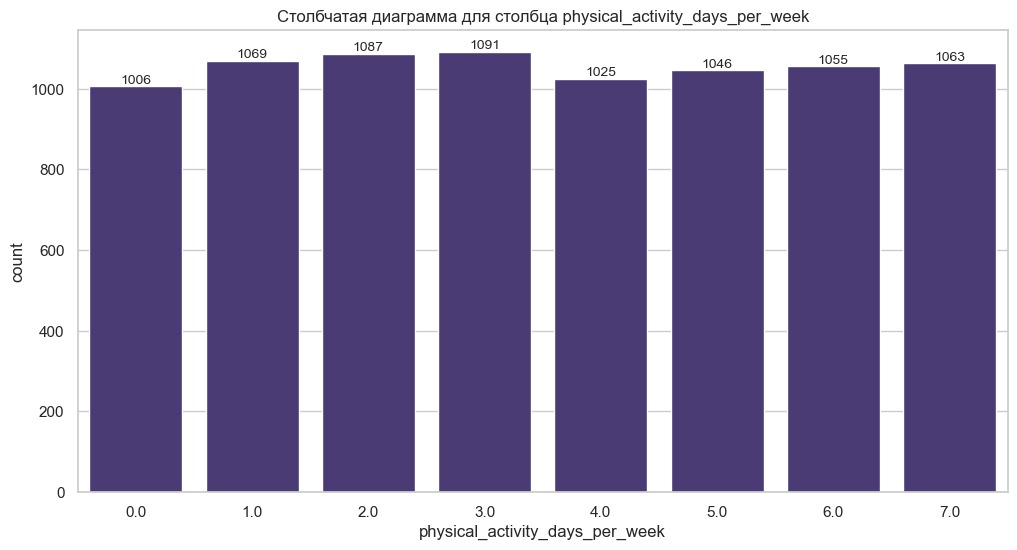

In [94]:
heart_train.visualize_discrete(columns=discrete_cols)

По графикам мы видим, что дискретные признаки образуют равномерные группы.

Посмотрим теперь на количественные непрерывные признаки.


Описательная статистика:

count    8442.000000
mean        0.449008
std         0.232809
min         0.044944
25%         0.247191
50%         0.460674
75%         0.640449
max         0.853933
Name: age, dtype: float64


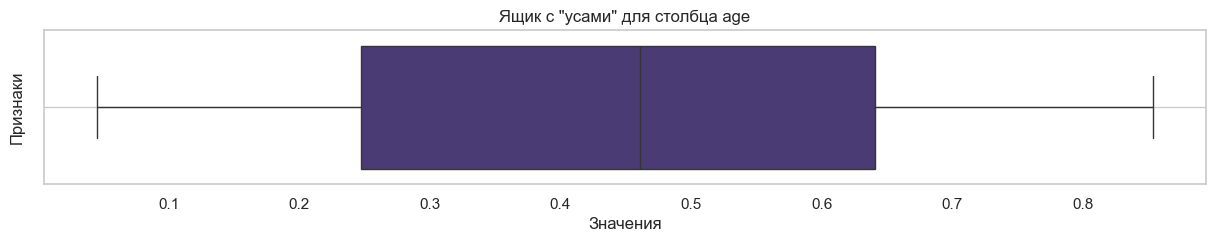

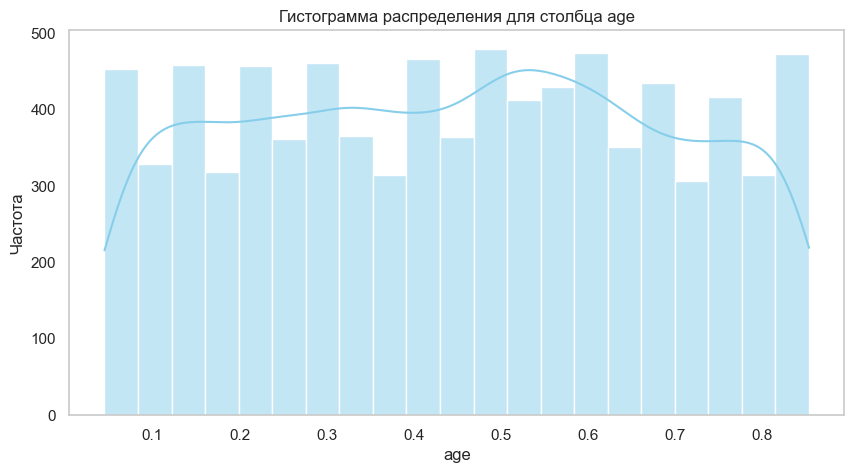


Статистика выбросов:

age: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.501108
std         0.288785
min         0.000000
25%         0.260714
50%         0.496429
75%         0.750000
max         1.000000
Name: cholesterol, dtype: float64


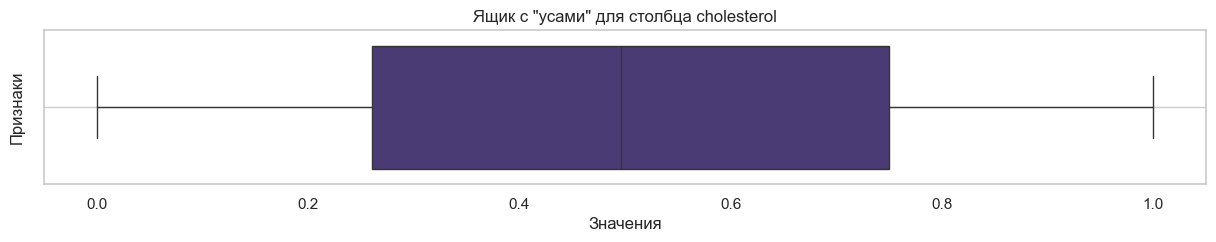

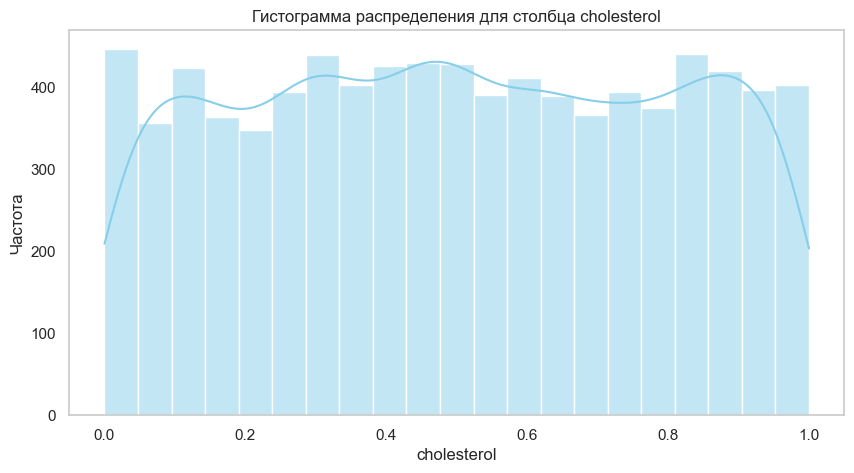


Статистика выбросов:

cholesterol: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.050194
std         0.018442
min         0.018332
25%         0.034830
50%         0.050412
75%         0.065995
max         0.082493
Name: heart_rate, dtype: float64


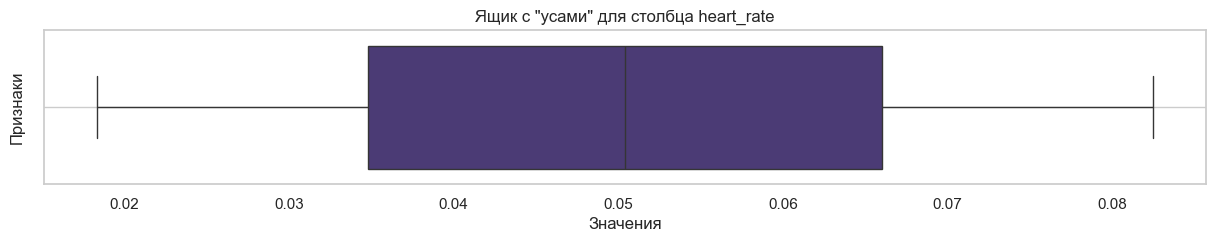

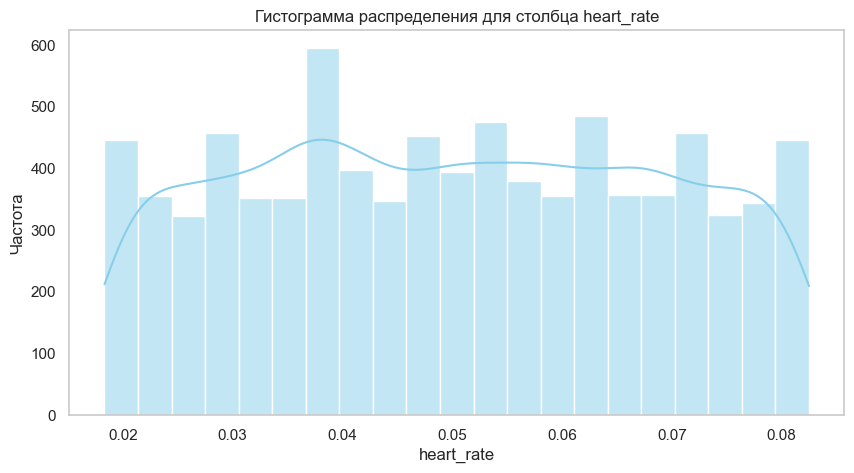


Статистика выбросов:

heart_rate: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.503415
std         0.288881
min         0.000000
25%         0.253359
50%         0.508244
75%         0.754901
max         1.000000
Name: exercise_hours_per_week, dtype: float64


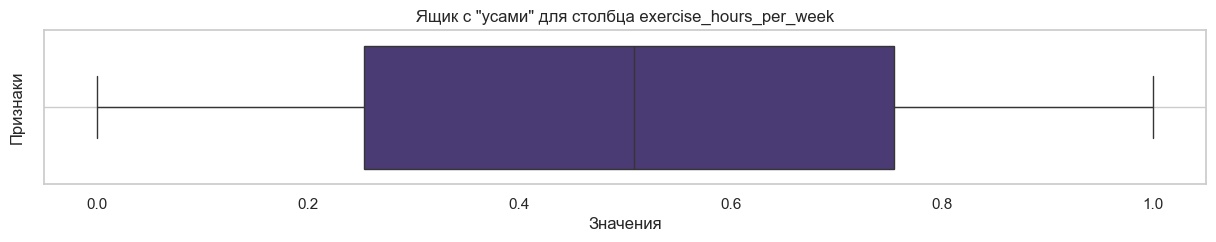

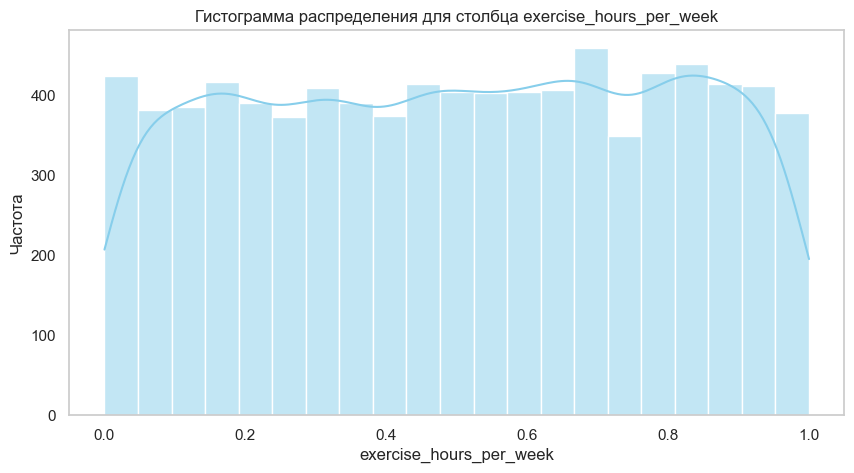


Статистика выбросов:

exercise_hours_per_week: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.499142
std         0.289418
min         0.000000
25%         0.247650
50%         0.492734
75%         0.751047
max         1.000000
Name: sedentary_hours_per_day, dtype: float64


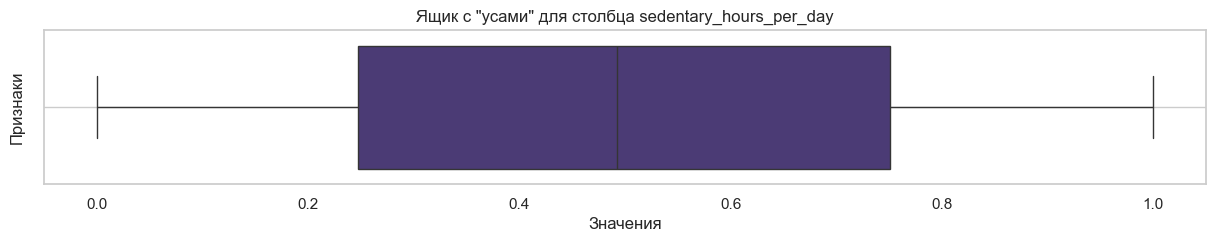

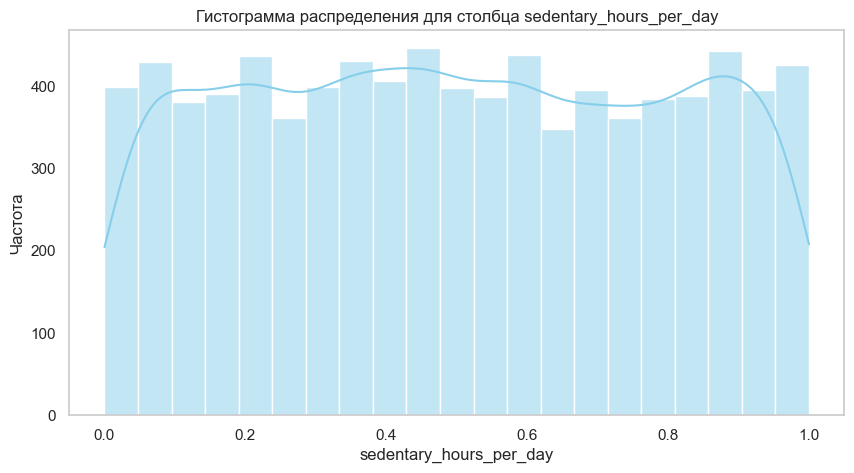


Статистика выбросов:

sedentary_hours_per_day: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.496831
std         0.286599
min         0.000000
25%         0.247935
50%         0.490801
75%         0.744399
max         1.000000
Name: bmi, dtype: float64


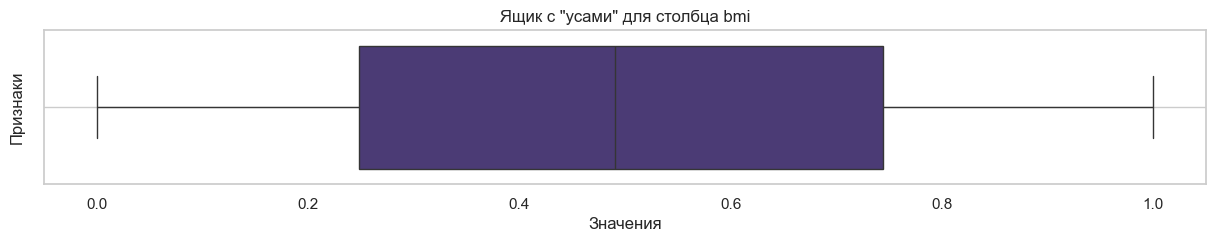

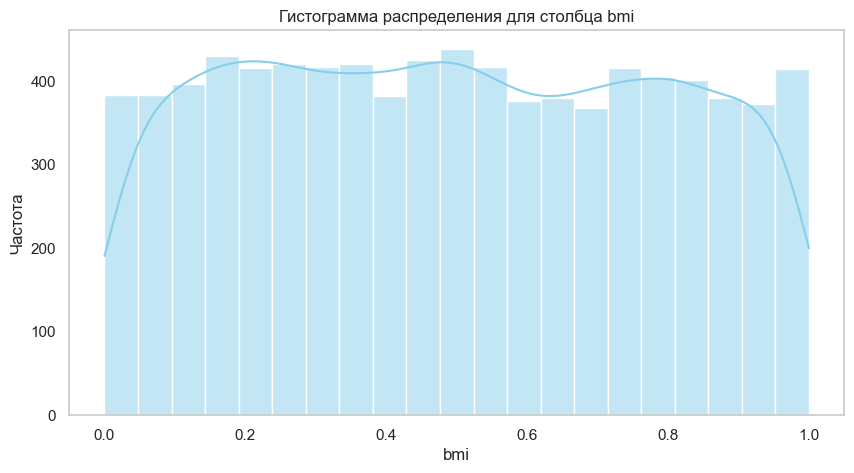


Статистика выбросов:

bmi: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.505539
std         0.290412
min         0.000000
25%         0.257143
50%         0.507792
75%         0.758442
max         1.000000
Name: triglycerides, dtype: float64


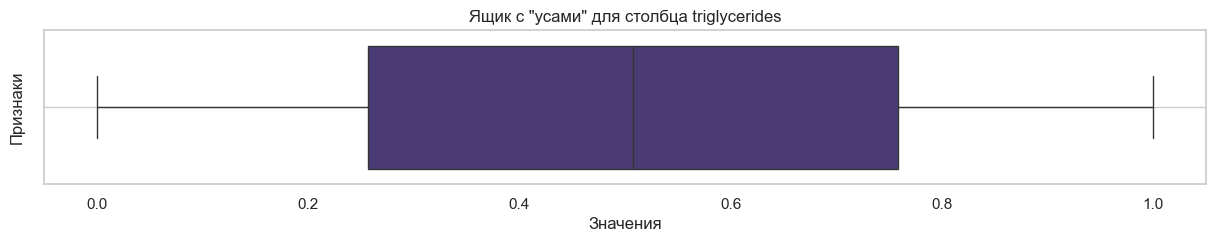

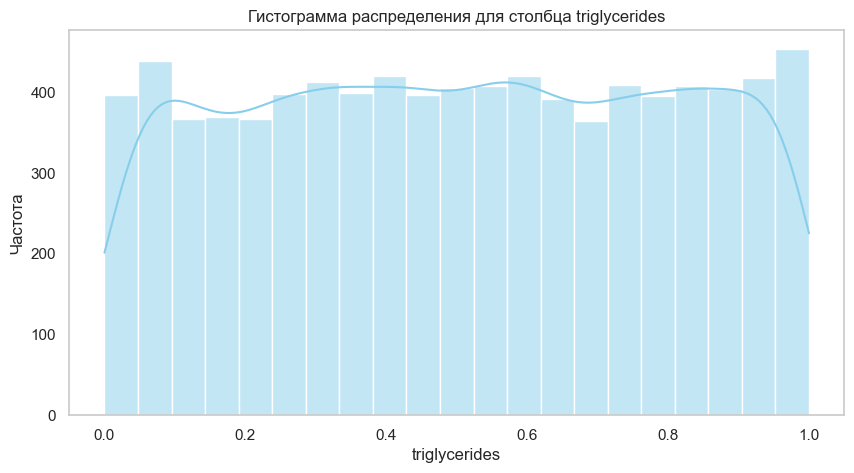


Статистика выбросов:

triglycerides: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.503712
std         0.332749
min         0.000000
25%         0.166667
50%         0.500000
75%         0.833333
max         1.000000
Name: sleep_hours_per_day, dtype: float64


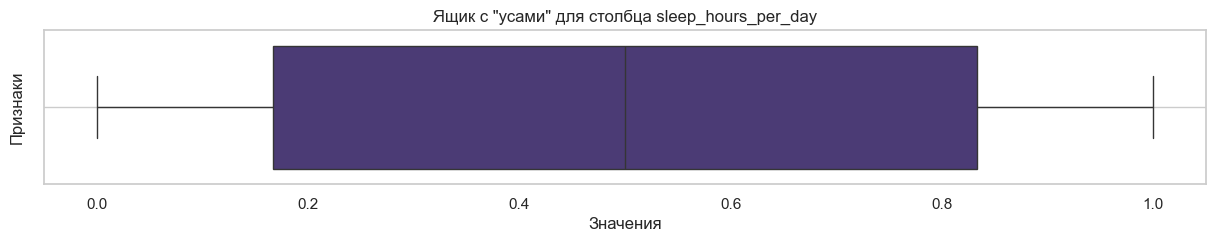

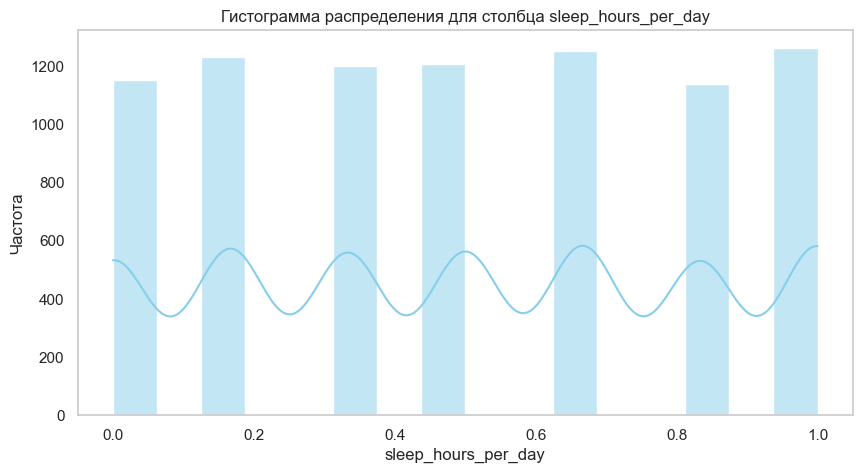


Статистика выбросов:

sleep_hours_per_day: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.227998
std         0.074623
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64


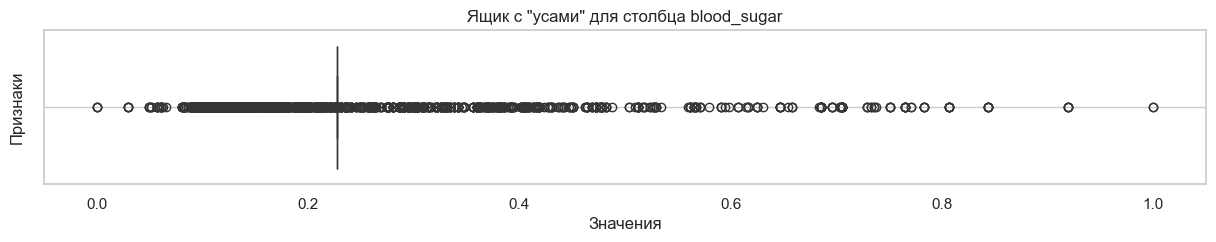

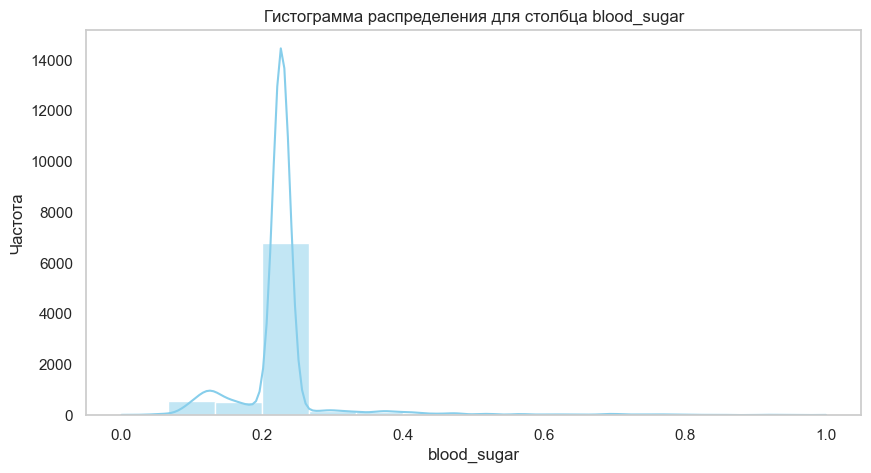


Статистика выбросов:

blood_sugar: 1891 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.047745
std         0.070399
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: ck-mb, dtype: float64


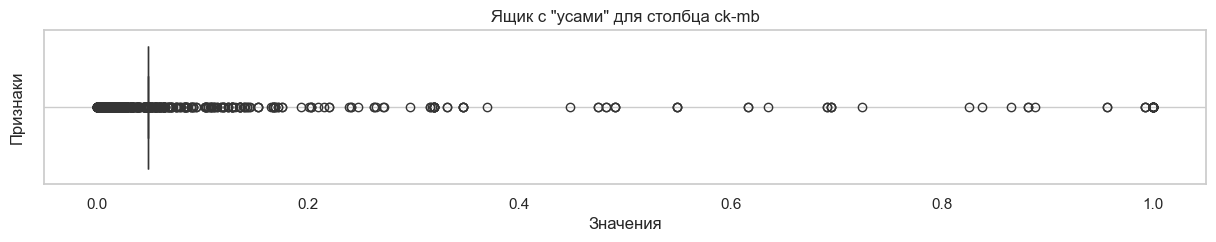

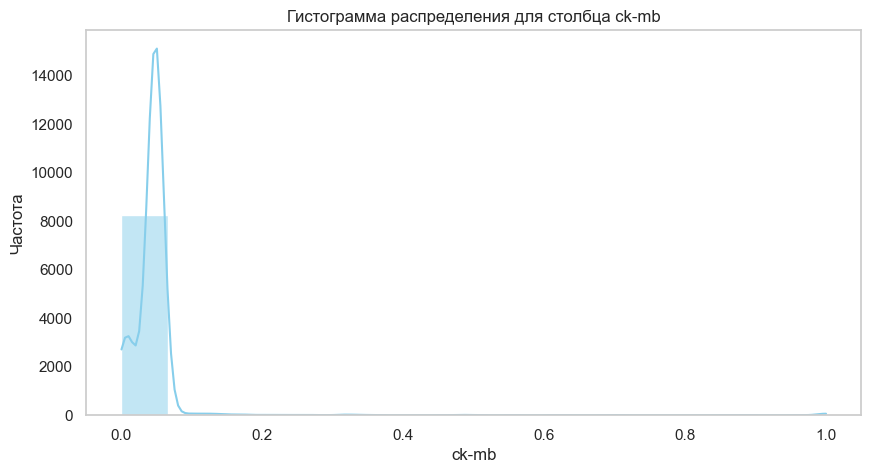


Статистика выбросов:

ck-mb: 1891 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.036867
std         0.059284
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: troponin, dtype: float64


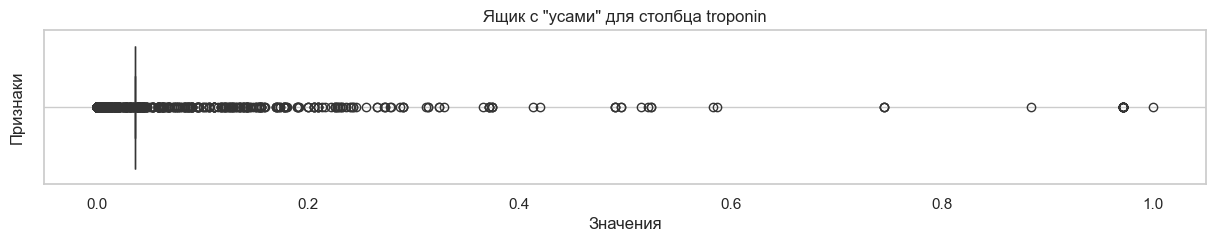

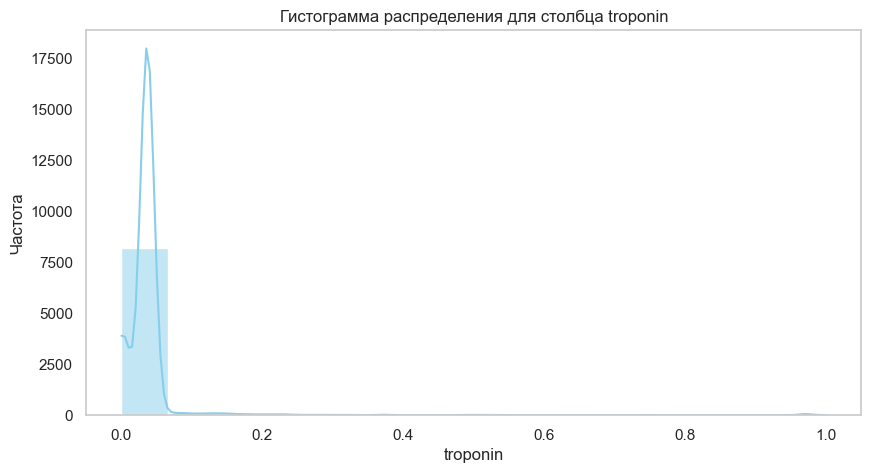


Статистика выбросов:

troponin: 1891 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.451955
std         0.170187
min         0.161290
25%         0.303226
50%         0.451613
75%         0.600000
max         0.741935
Name: systolic_blood_pressure, dtype: float64


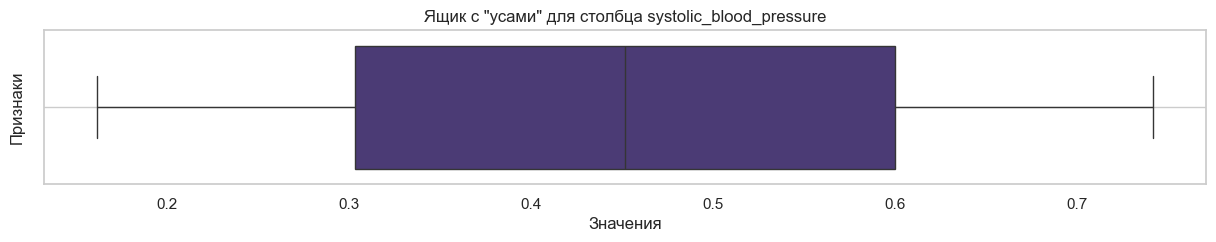

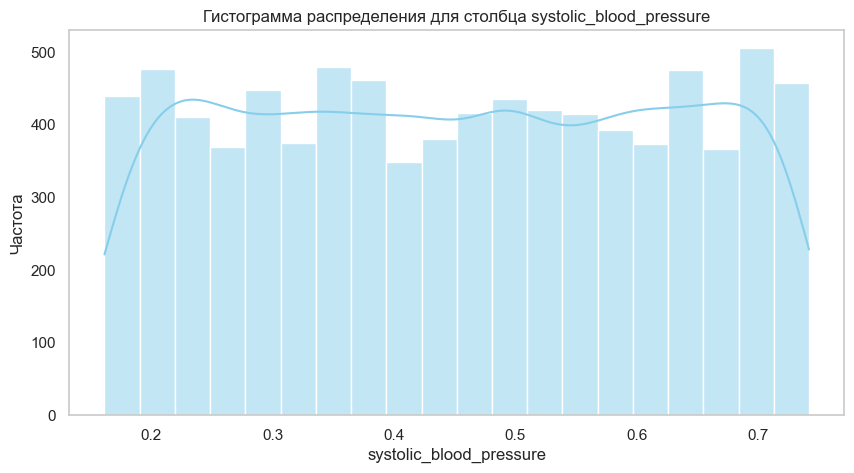


Статистика выбросов:

systolic_blood_pressure: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    8442.000000
mean        0.501672
std         0.170302
min         0.209302
25%         0.348837
50%         0.500000
75%         0.651163
max         0.790698
Name: diastolic_blood_pressure, dtype: float64


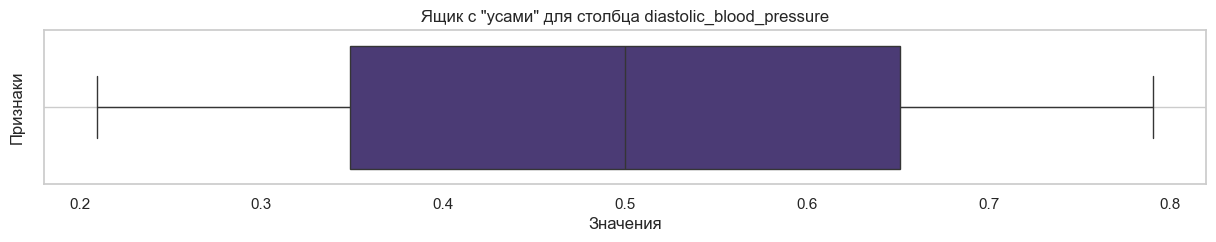

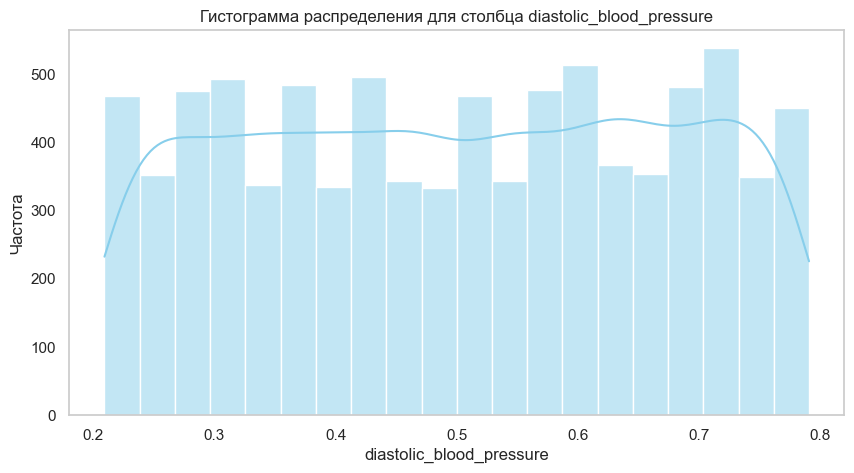


Статистика выбросов:

diastolic_blood_pressure: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------


In [95]:
heart_train.visualize_distributions(columns=num_cols)

Почти все показатели распределены равномерно, НО стоит обратить внимание на следующие столбцы:

- `blood_sugar` - мода у этого показателя равняется 0.227018, а все отличные от этого значения лежат уже вне межквартильного размаха
- `ck-mb` - мода у этого показателя равняется 0.048229, а все отличные от этого значения лежат уже вне межквартильного размаха
- `troponin` - мода у этого показателя равняется 0.036512, а все отличные от этого значения лежат уже вне межквартильного размаха

Также еще хочется отметить что статистически для этих трех показателей имеется одинаковое количество "выбросов" равное 1891 записи, возможно на дальнейших этапах это поможет нам понять какую-либо особенность или закономерность, будем учитывать это.

Теперь построим графики для категориальных столбцов. Так как все категориальные признаки, кроме гендера уже закодированы, то будем использовать функцию класса для построения графиков для дискретных столбцов.

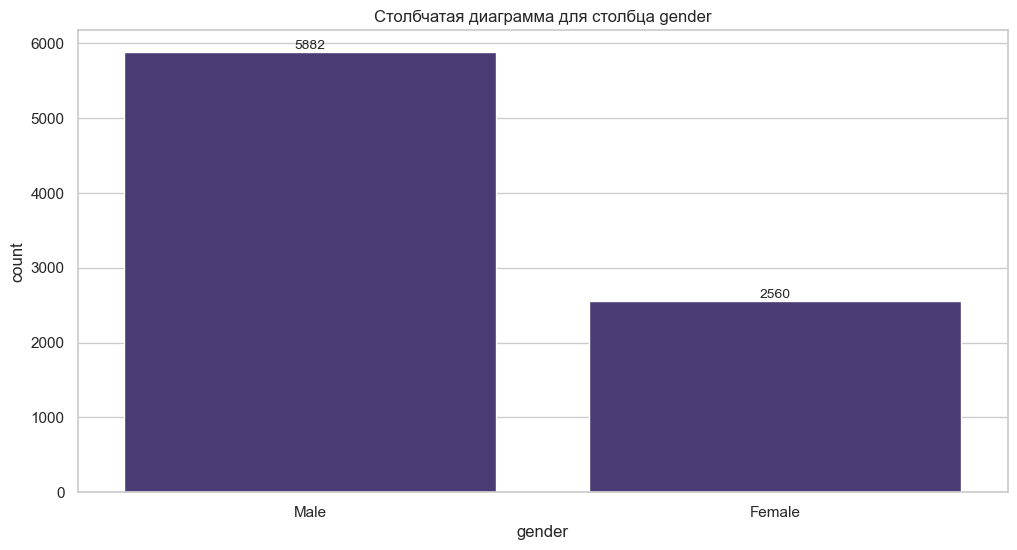

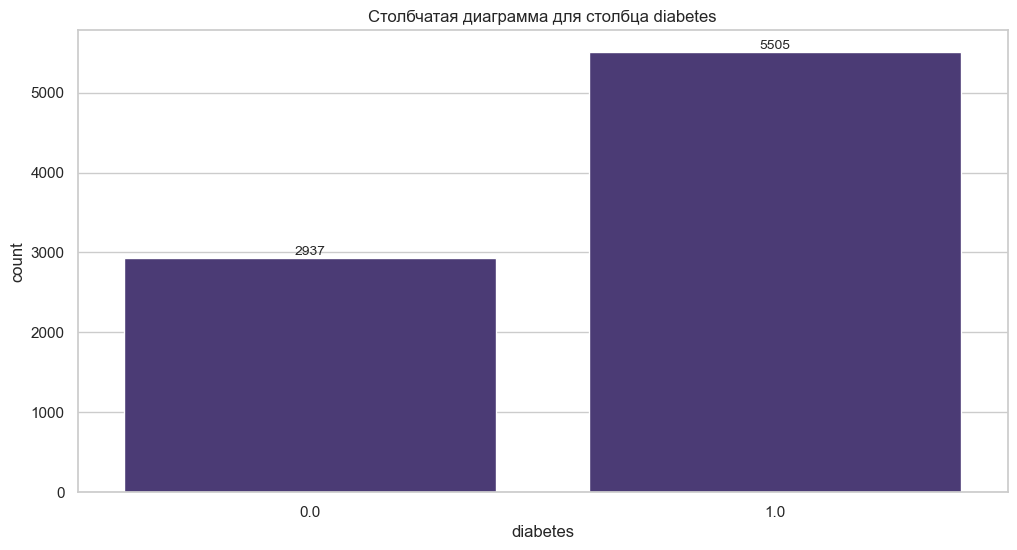

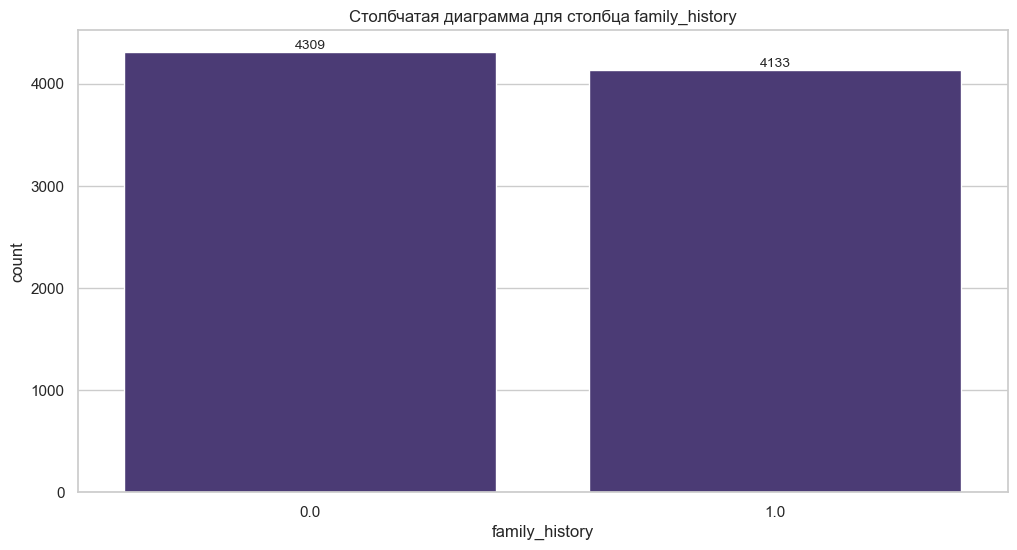

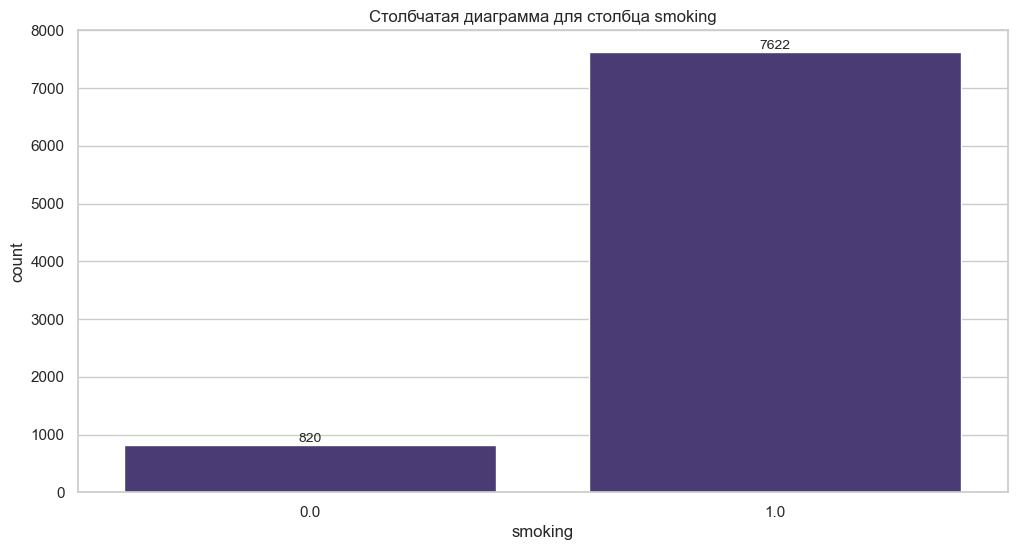

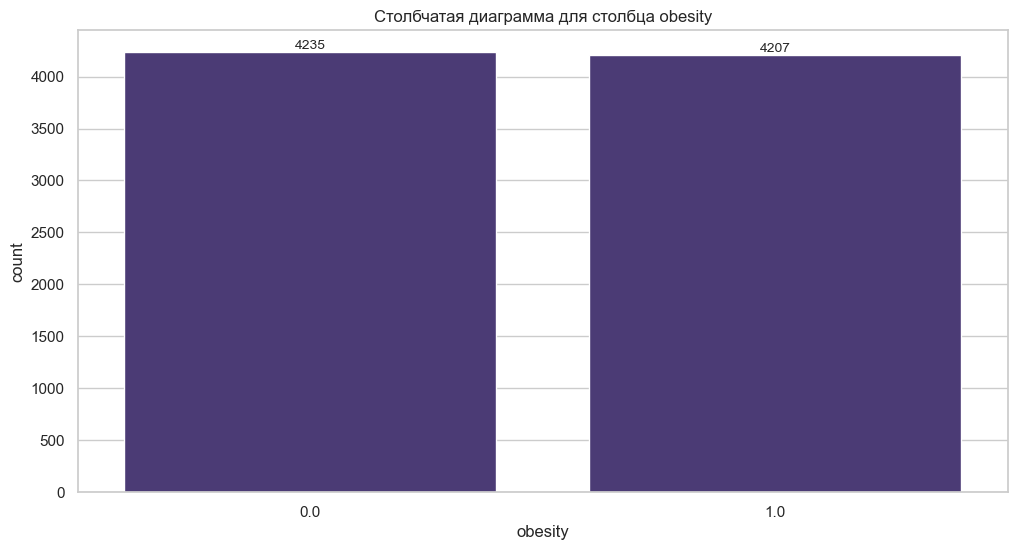

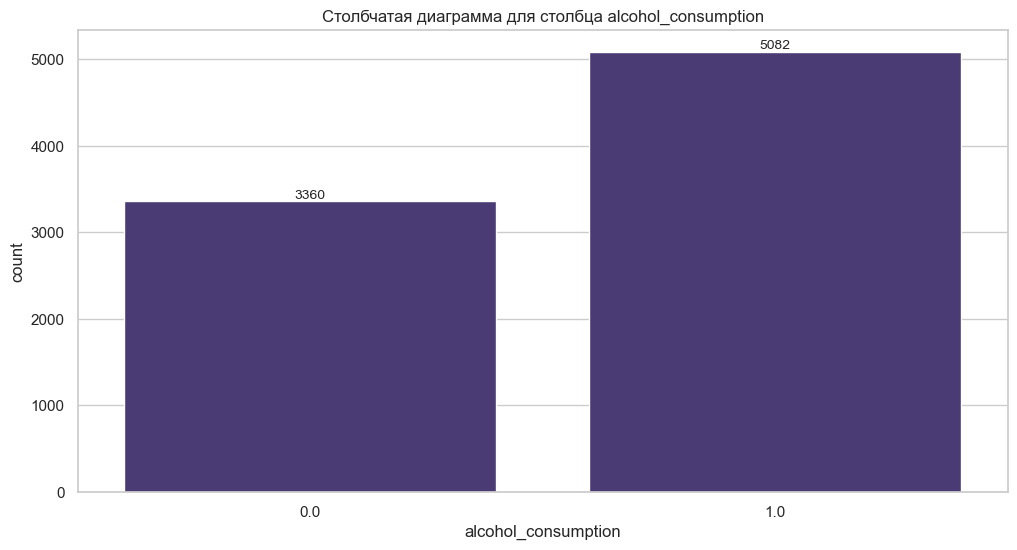

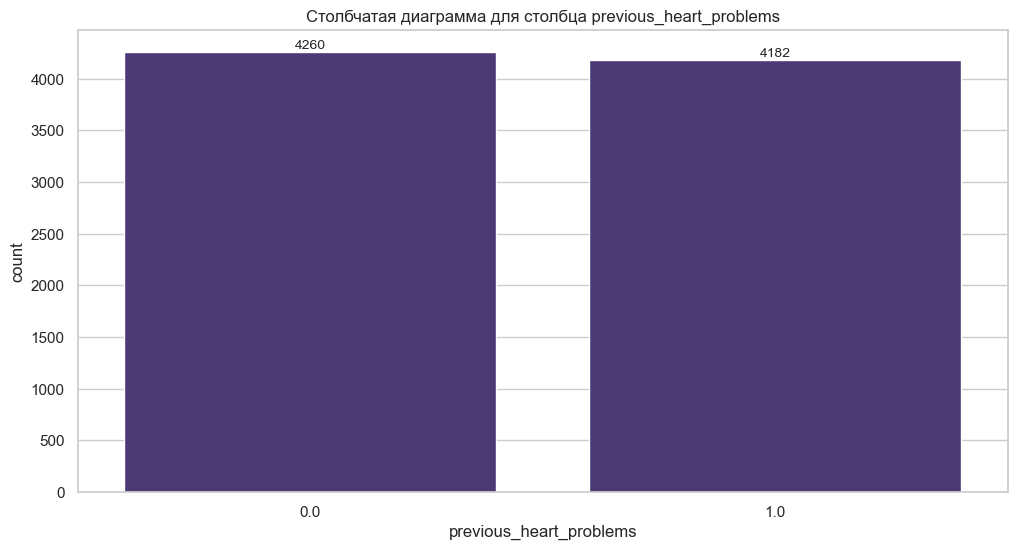

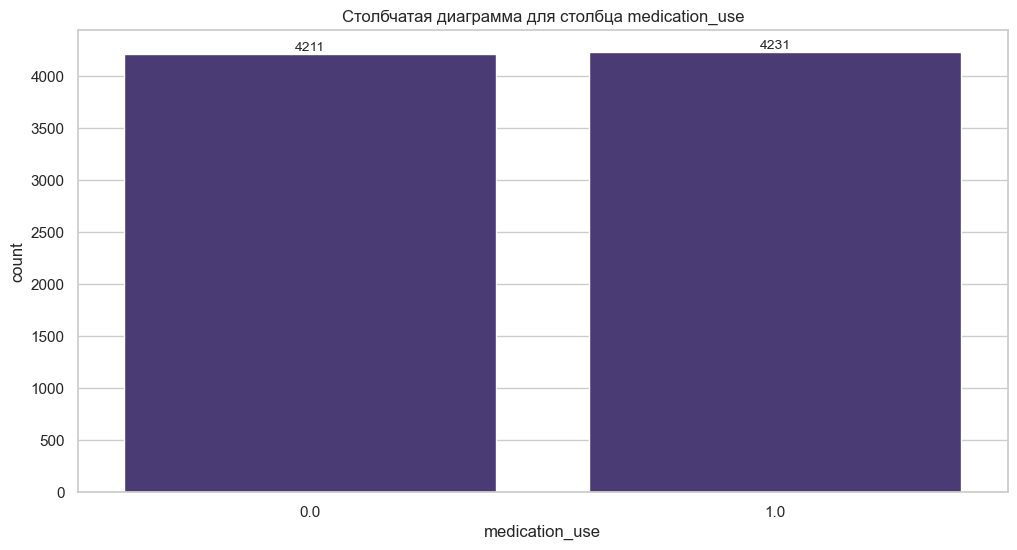

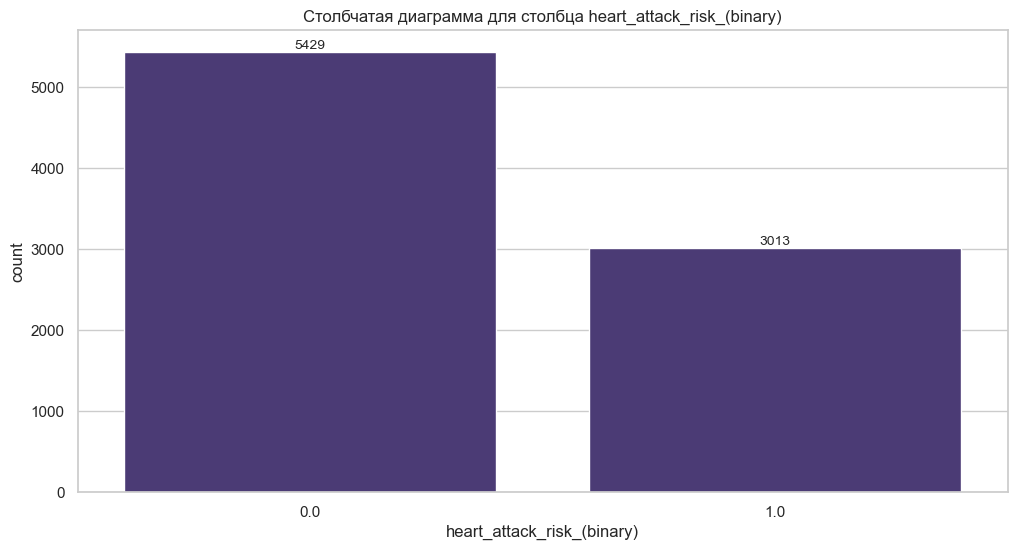

In [96]:
heart_train.visualize_discrete(cat_cols)

Особенности для категориальных признаков:

- в этом датасете находится около 70% записей для пациентов мужчин и около 30% для пациентов женщин
- чуть больше трети пациентов без диабета и чуть меньше двух третей с диабетом
- почти поровну пациентов у которых в роду имелись предки с серьезными заболеваниями и у которых таких предков не было
- около 90% пациентов курящие
- половина страдает ожирением
- около 65% пациентов употребляет алкоголь
- половина пациентов уже имела проблемы с сердцем
- около половины пациентов принимают медикаментозное лечение
- около 35% имеют оценку высокого риска наступления сердченого приступа

На данном этапе мы не будем делать "портрет" пациента с высоким риском наступления сердченого приступа и исследовать связи между признаками в разрезе целевого. Данные исследования мы проведем в самом конце, когда будем анализировать результаты работы лучшей модели. Так наш "портрет" получится более точным, так как будет подкреплен корреляционным анализом и SHAP-анализом.

Теперь построим те же графики для тестовой выборки, чтобы посомтреть на структуру данных.

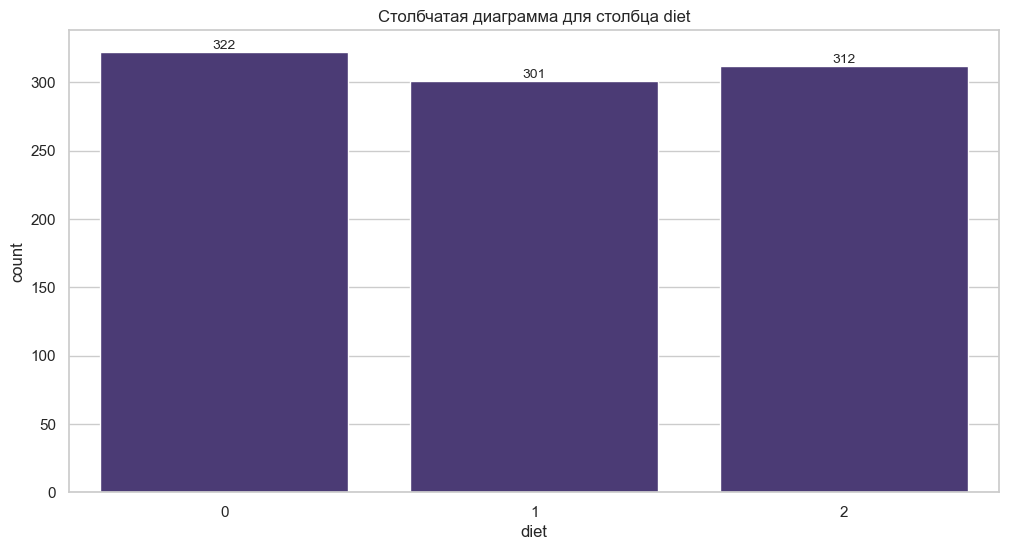

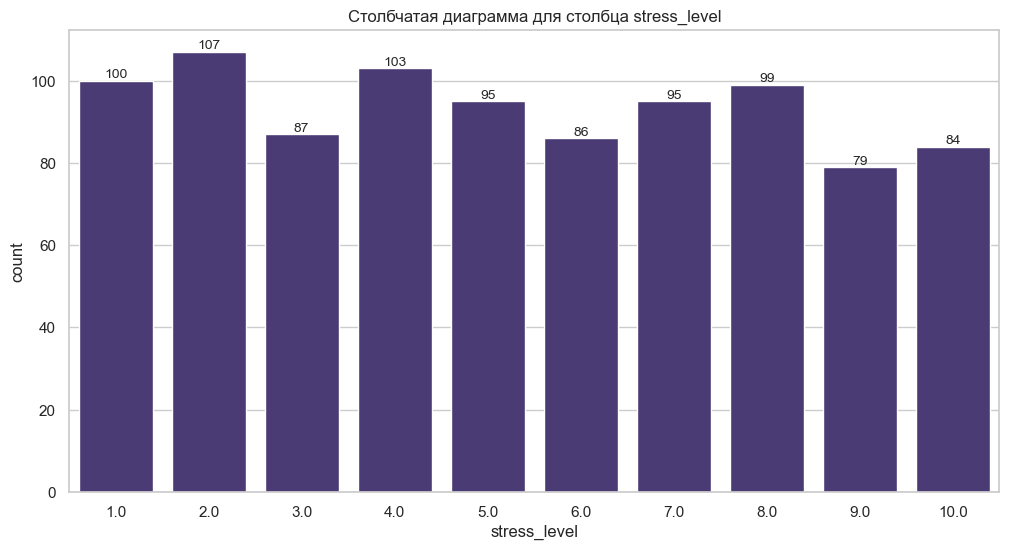

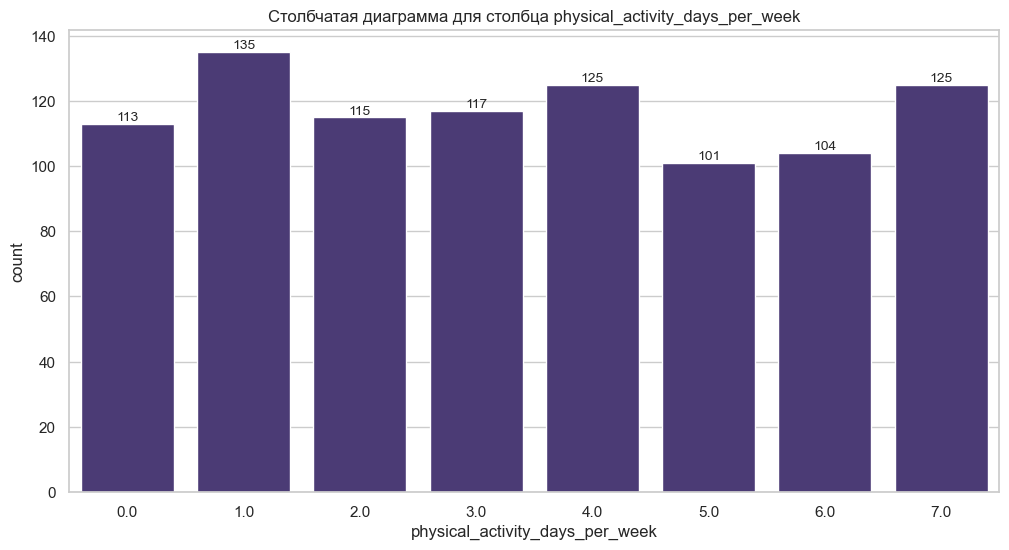

In [97]:
heart_test.visualize_discrete(discrete_cols)

Дискретные признаки в тестовой выборке имеют схожую структуру с тренировочной.


Описательная статистика:

count    935.000000
mean       0.452106
std        0.233873
min        0.044944
25%        0.235955
50%        0.460674
75%        0.651685
max        0.853933
Name: age, dtype: float64


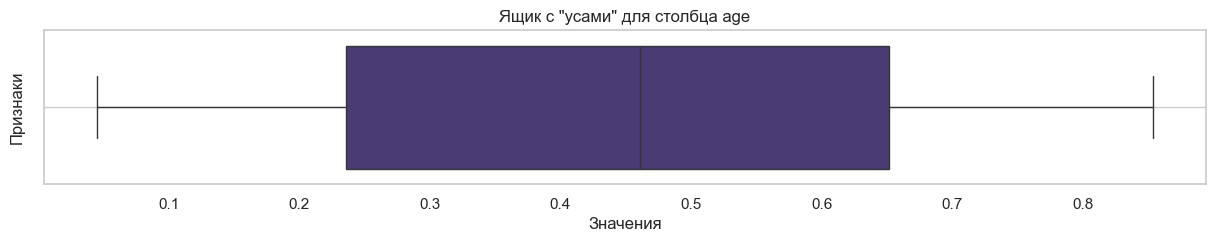

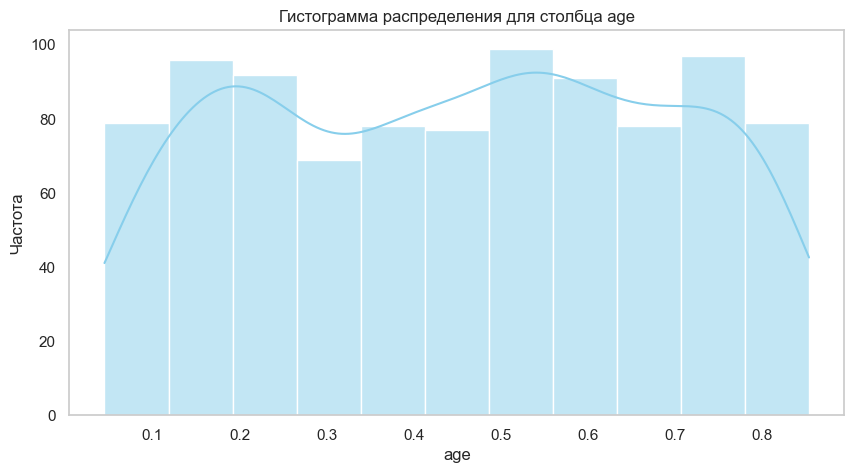


Статистика выбросов:

age: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.487796
std        0.286674
min        0.000000
25%        0.235714
50%        0.485714
75%        0.723214
max        0.996429
Name: cholesterol, dtype: float64


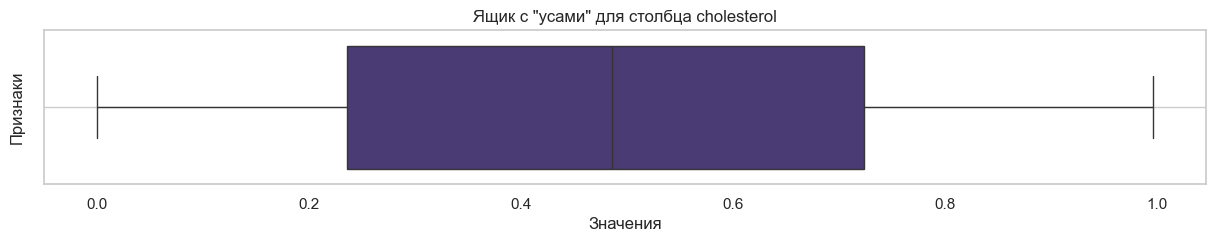

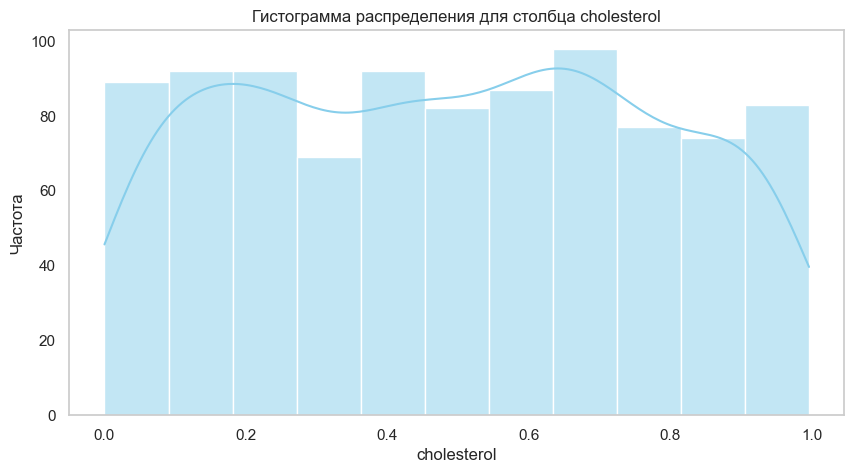


Статистика выбросов:

cholesterol: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.050624
std        0.018031
min        0.018332
25%        0.036664
50%        0.050412
75%        0.065995
max        0.082493
Name: heart_rate, dtype: float64


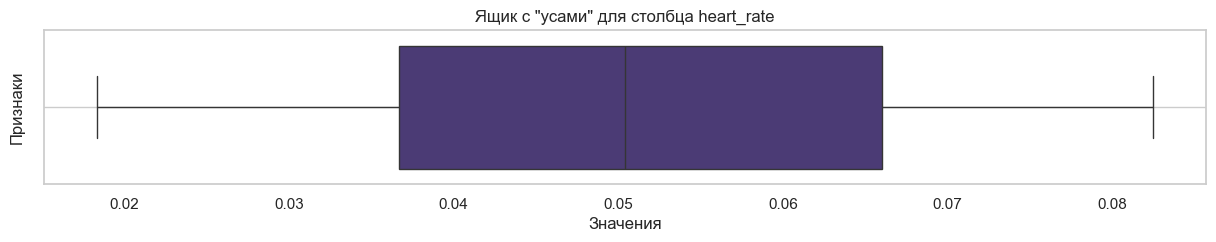

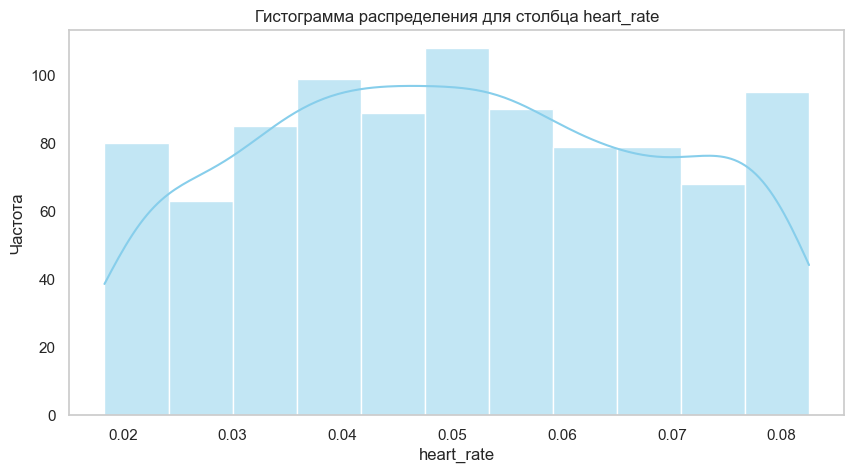


Статистика выбросов:

heart_rate: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.490327
std        0.289584
min        0.000336
25%        0.235647
50%        0.493305
75%        0.739898
max        0.998938
Name: exercise_hours_per_week, dtype: float64


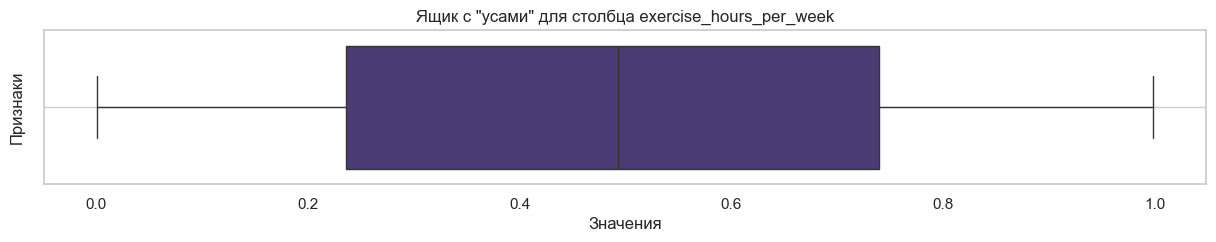

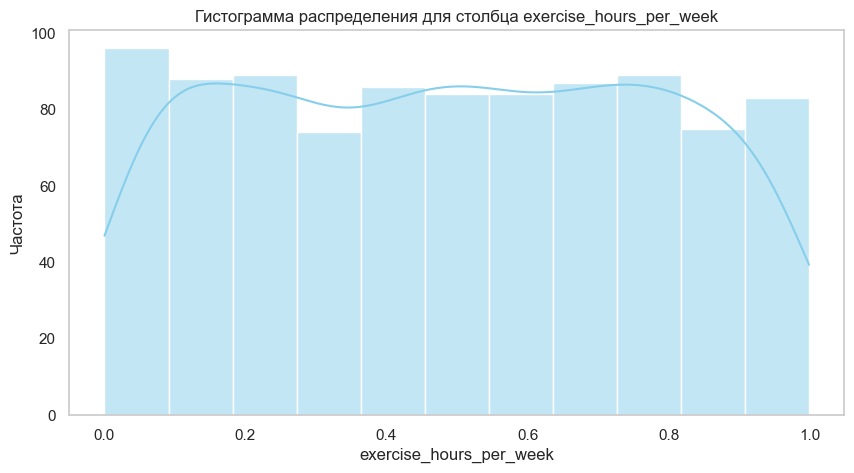


Статистика выбросов:

exercise_hours_per_week: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.506941
std        0.292561
min        0.001187
25%        0.247833
50%        0.518151
75%        0.767566
max        0.999033
Name: sedentary_hours_per_day, dtype: float64


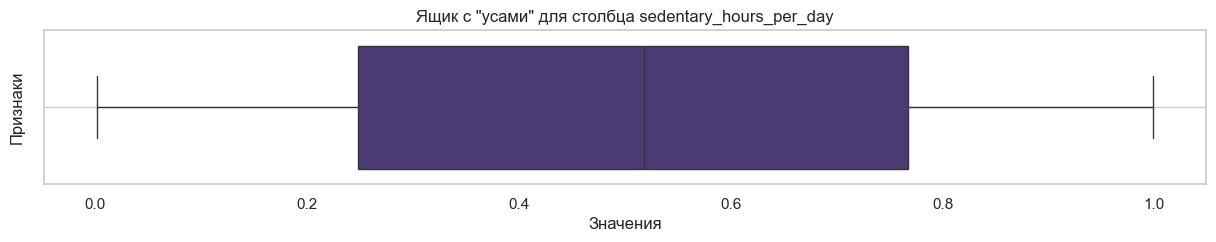

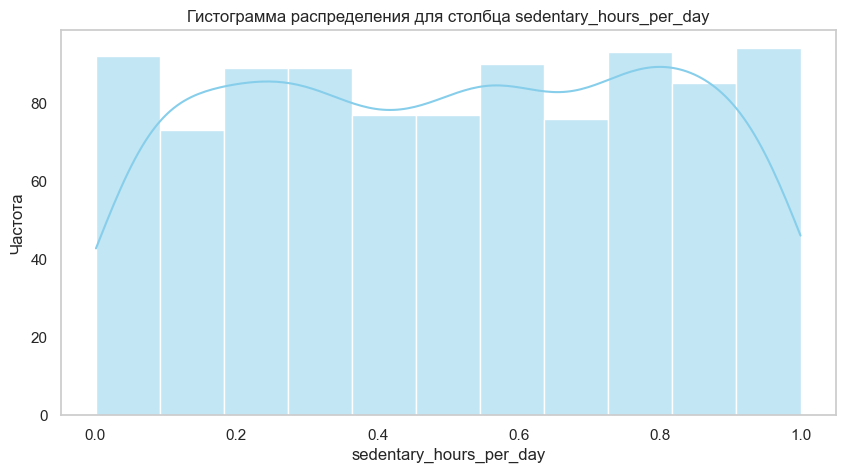


Статистика выбросов:

sedentary_hours_per_day: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.476200
std        0.296775
min        0.002598
25%        0.211395
50%        0.456156
75%        0.734170
max        0.999496
Name: bmi, dtype: float64


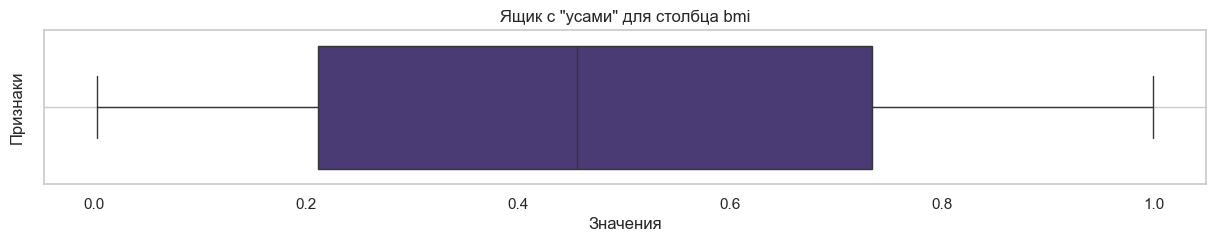

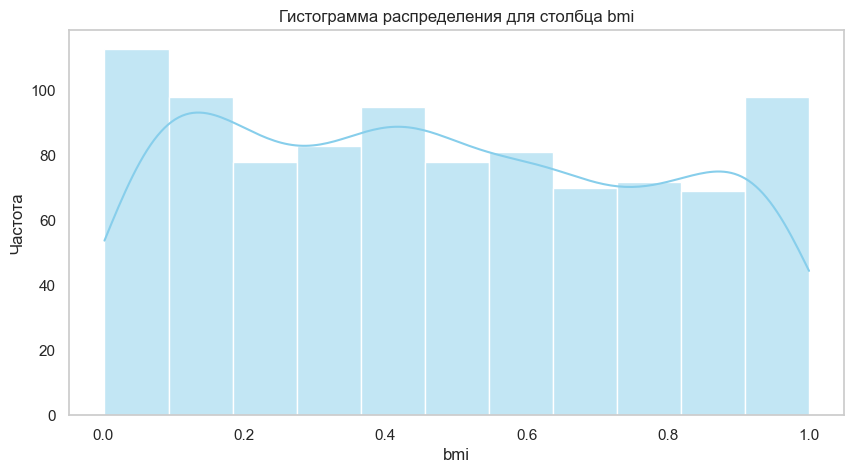


Статистика выбросов:

bmi: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.486127
std        0.289200
min        0.000000
25%        0.243506
50%        0.471429
75%        0.732468
max        0.998701
Name: triglycerides, dtype: float64


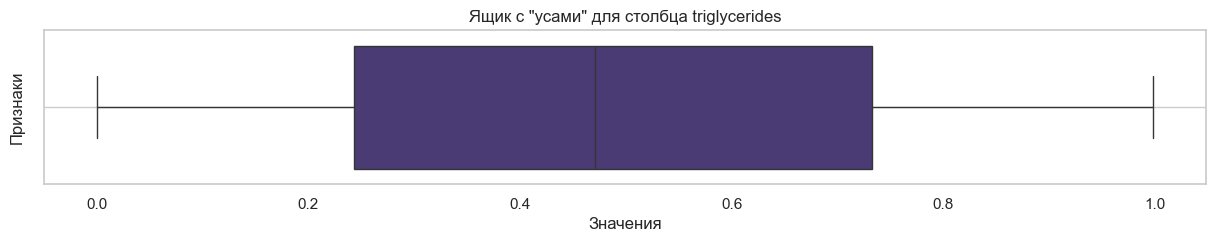

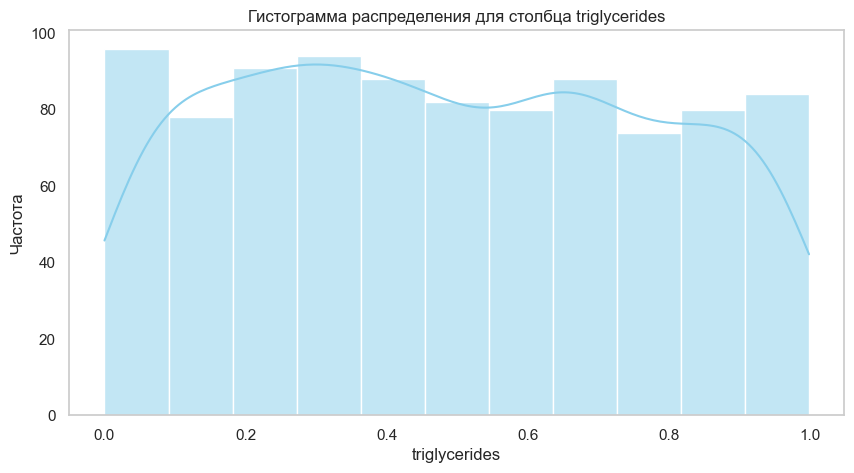


Статистика выбросов:

triglycerides: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.512834
std        0.327594
min        0.000000
25%        0.166667
50%        0.500000
75%        0.833333
max        1.000000
Name: sleep_hours_per_day, dtype: float64


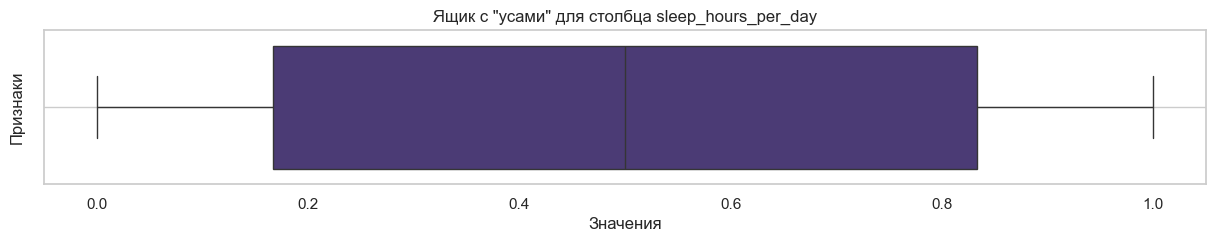

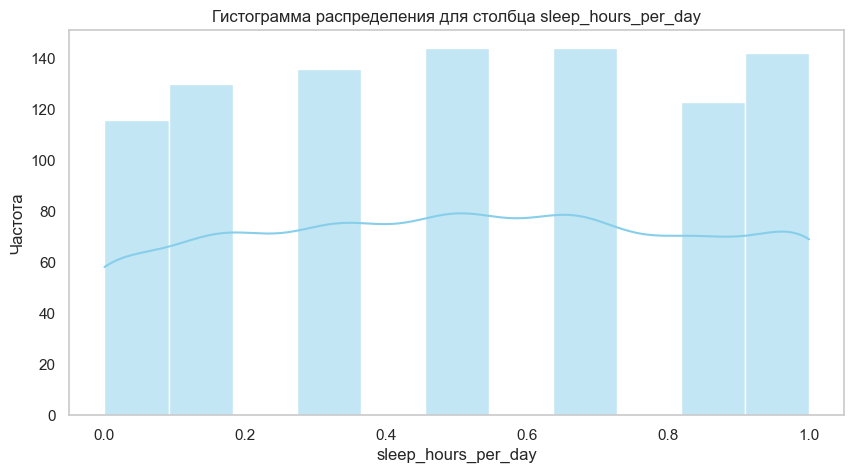


Статистика выбросов:

sleep_hours_per_day: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.225876
std        0.063750
min        0.029644
25%        0.227018
50%        0.227018
75%        0.227018
max        0.750988
Name: blood_sugar, dtype: float64


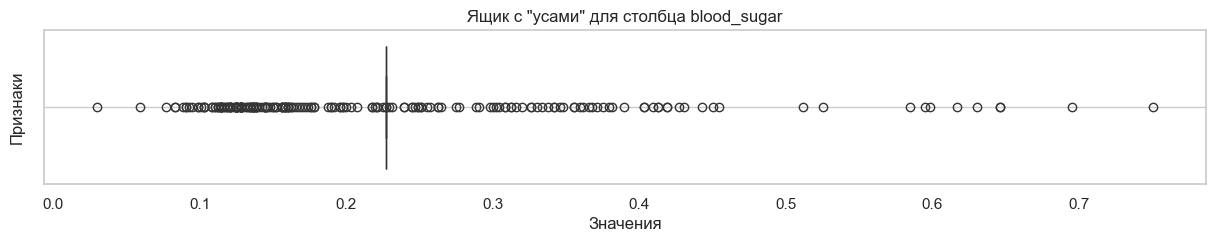

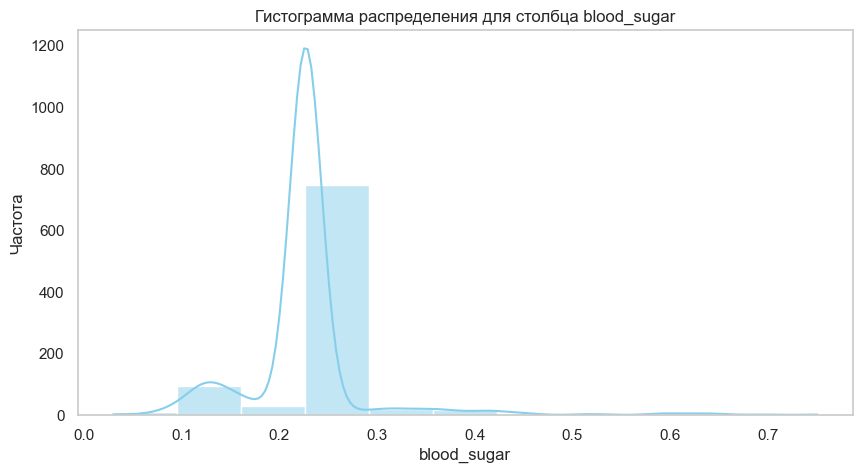


Статистика выбросов:

blood_sugar: 209 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.049011
std        0.074523
min        0.000000
25%        0.048229
50%        0.048229
75%        0.048229
max        1.000000
Name: ck-mb, dtype: float64


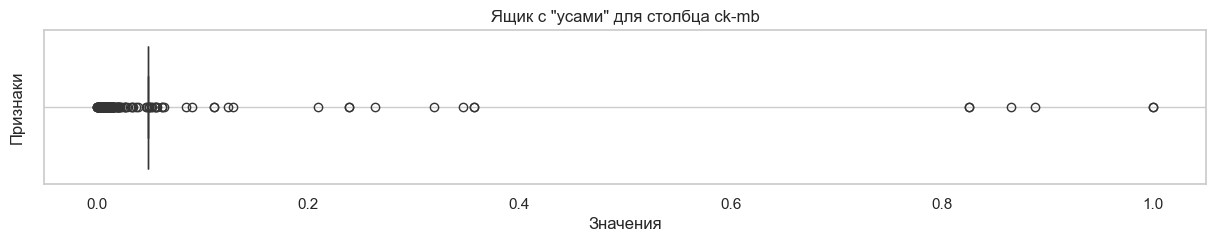

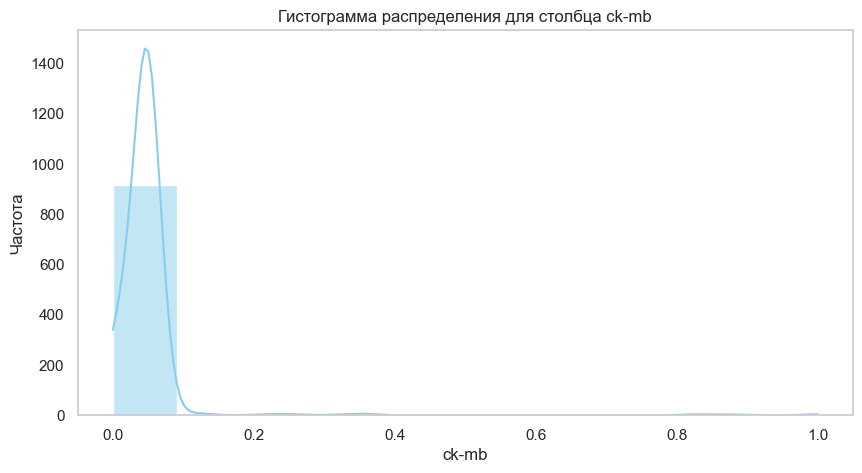


Статистика выбросов:

ck-mb: 209 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.034728
std        0.044943
min        0.000194
25%        0.036512
50%        0.036512
75%        0.036512
max        0.970871
Name: troponin, dtype: float64


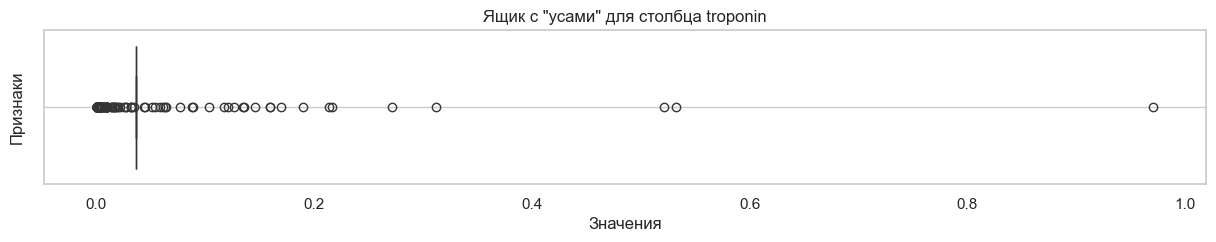

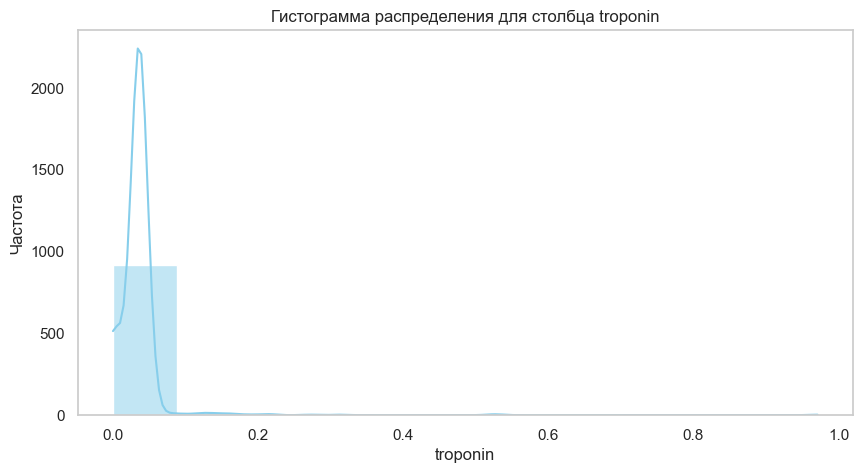


Статистика выбросов:

troponin: 209 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.449722
std        0.171918
min        0.161290
25%        0.296774
50%        0.458065
75%        0.600000
max        0.741935
Name: systolic_blood_pressure, dtype: float64


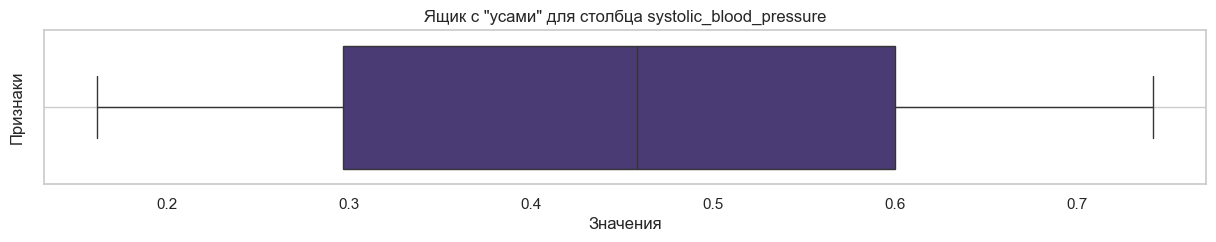

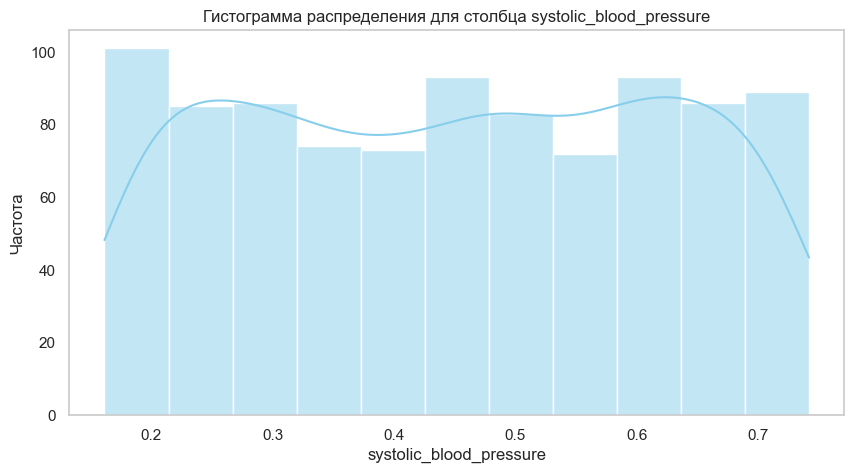


Статистика выбросов:

systolic_blood_pressure: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------

Описательная статистика:

count    935.000000
mean       0.500759
std        0.173262
min        0.209302
25%        0.348837
50%        0.500000
75%        0.651163
max        0.790698
Name: diastolic_blood_pressure, dtype: float64


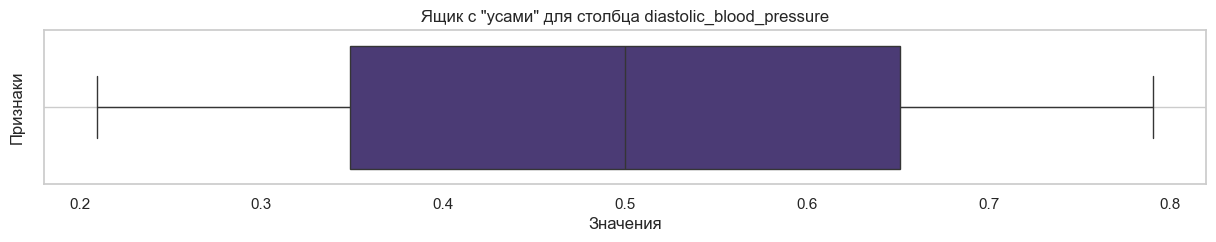

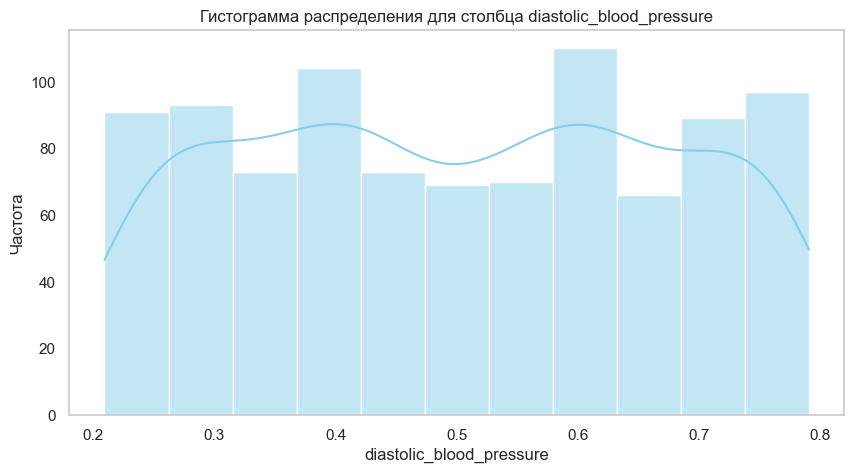


Статистика выбросов:

diastolic_blood_pressure: 0 выбросов

------------------------------------------------------------------------------------------------------------------------------------------------------


In [98]:
heart_test.visualize_distributions(num_cols)

Структура данных для непрерывных количественных признаков близкая по структуре к тренировочной выборке.

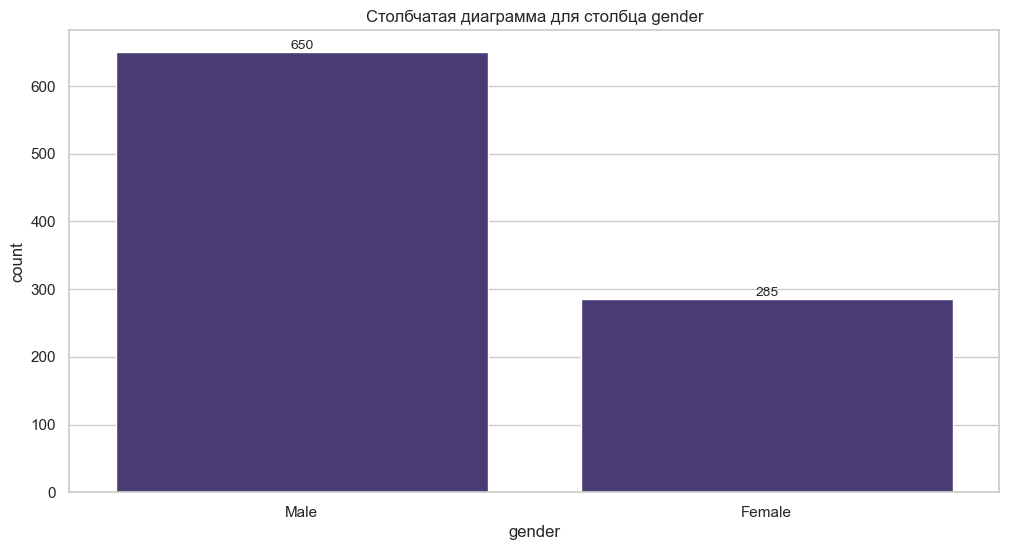

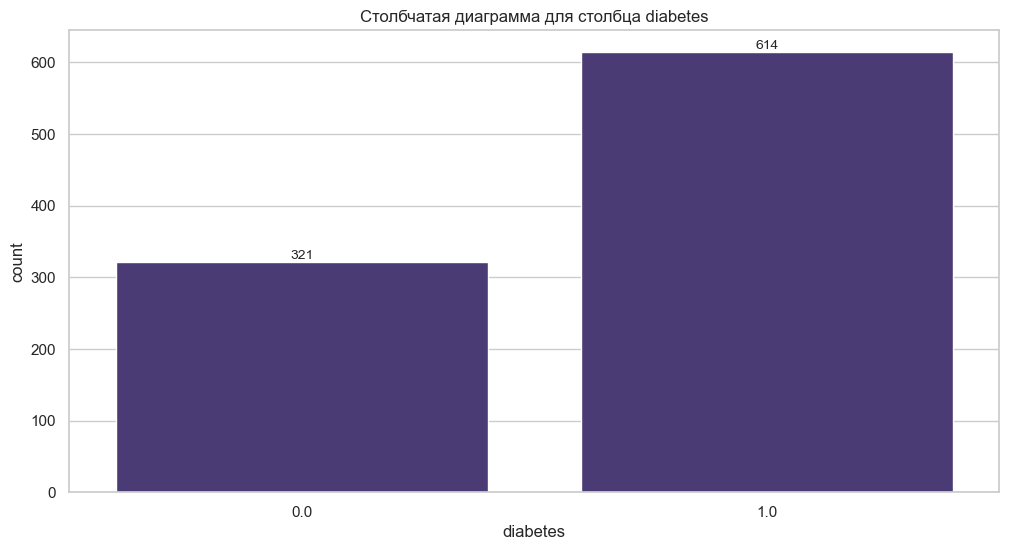

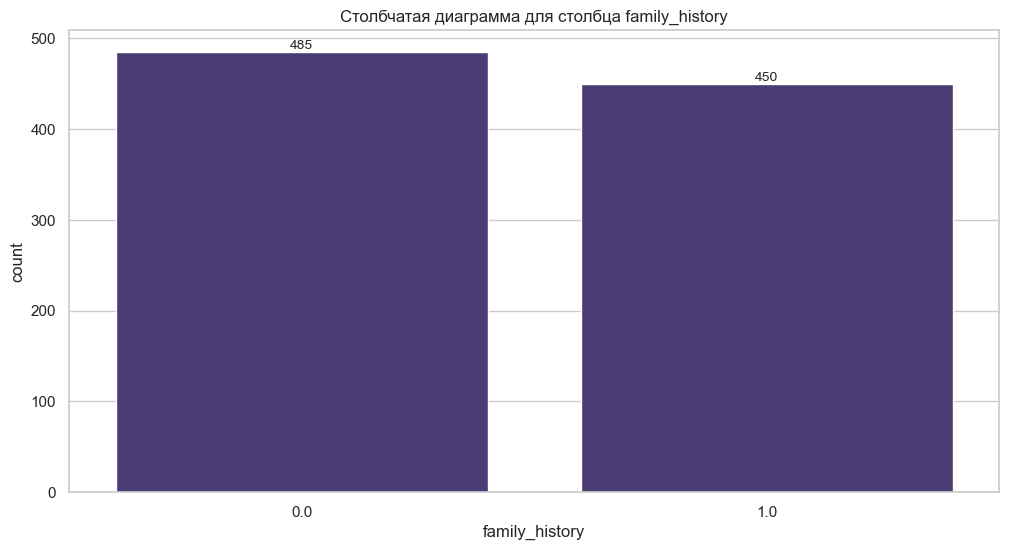

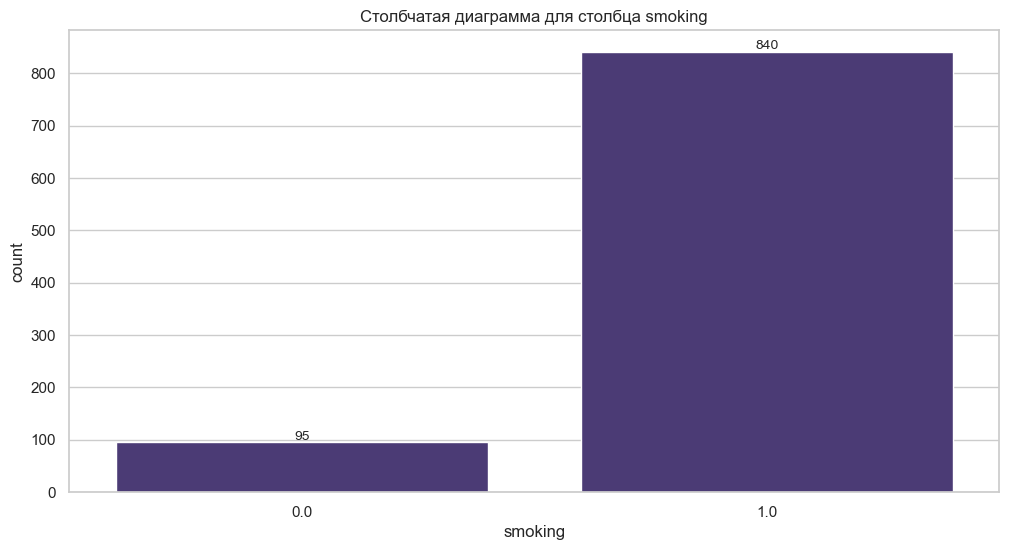

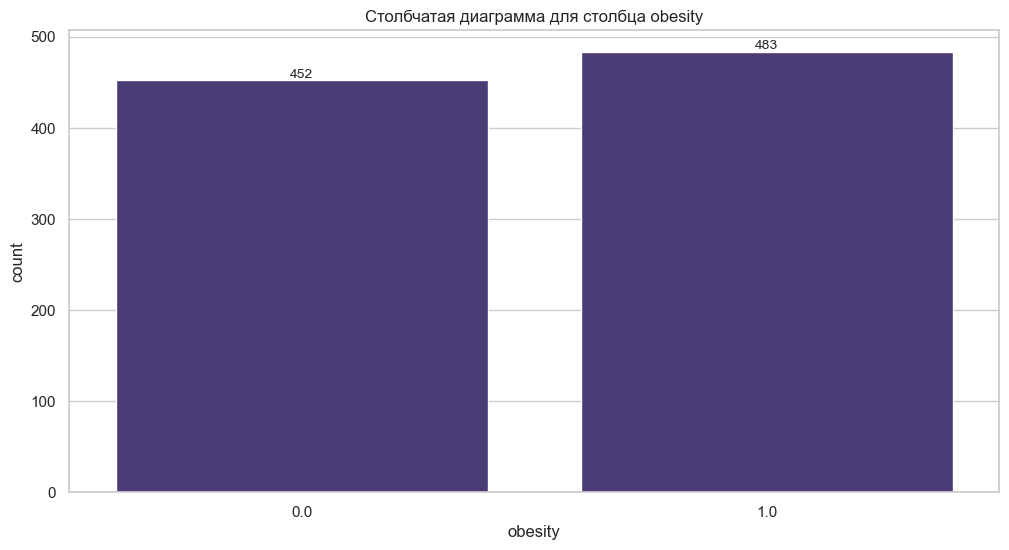

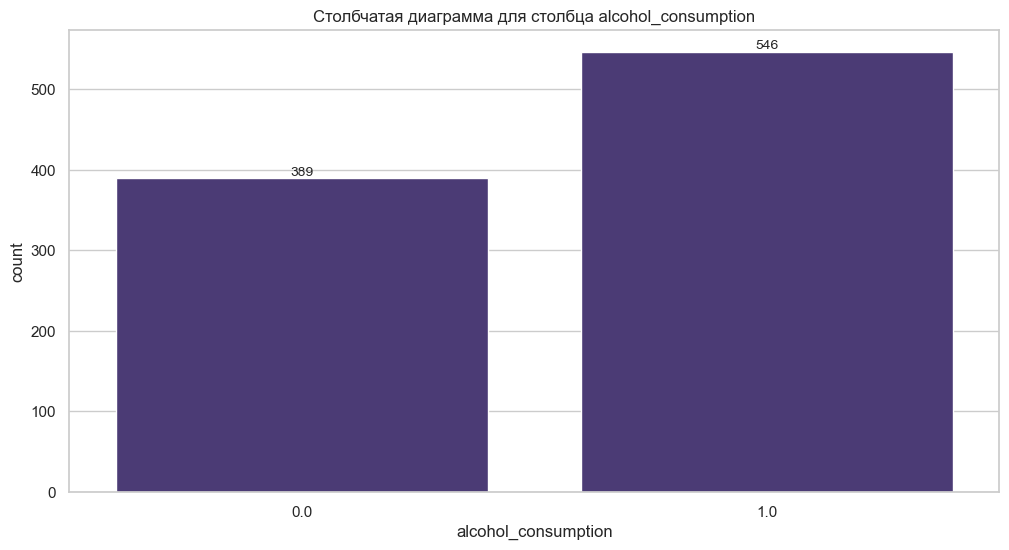

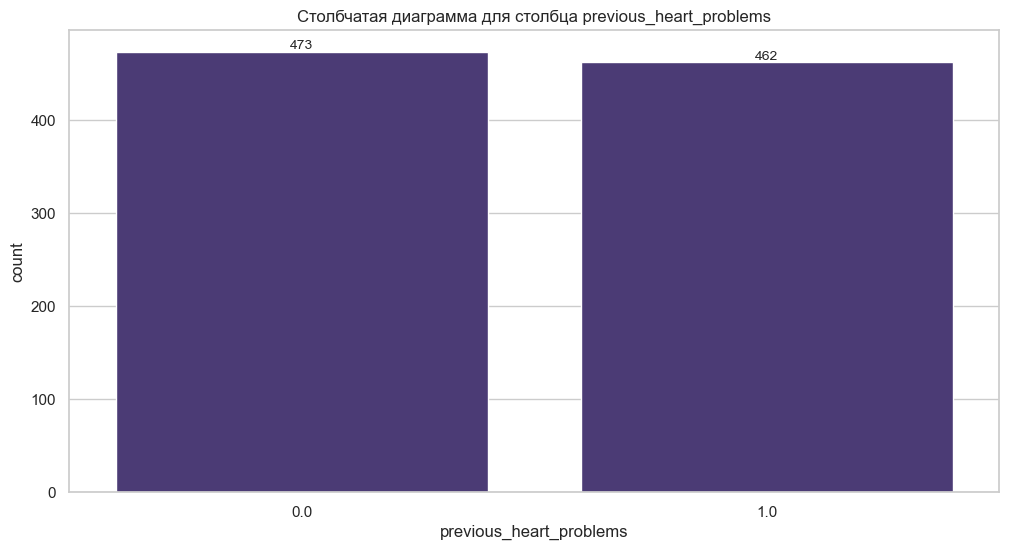

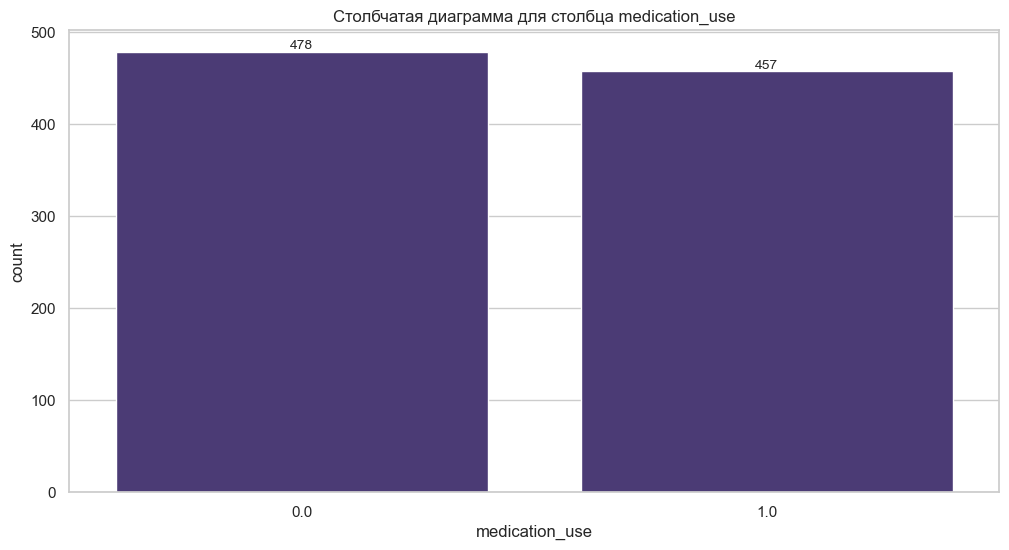

In [99]:
cat_cols.remove('heart_attack_risk_(binary)')
heart_test.visualize_discrete(cat_cols)

Для категориальных признаков тоже сохраняется похожая структура.

**Промежуточный вывод**

1. Два датасета(тренировочный и тестовый) близки между собой по структуре.
2. Аномалии или выбросы выявить нету возможности, так как данные уже представлены в закодированном виде и как-то их сравнить между собой не представляется возможным.

## Корреляционный анализ

Построим матрицу корреляции для тренировочного датасета. Непрерывные признаки у нас уже выделены в списке *num_cols*.

In [100]:
phik_overview_train = heart_train_df.drop('id', axis=1).phik_matrix(interval_cols=num_cols)

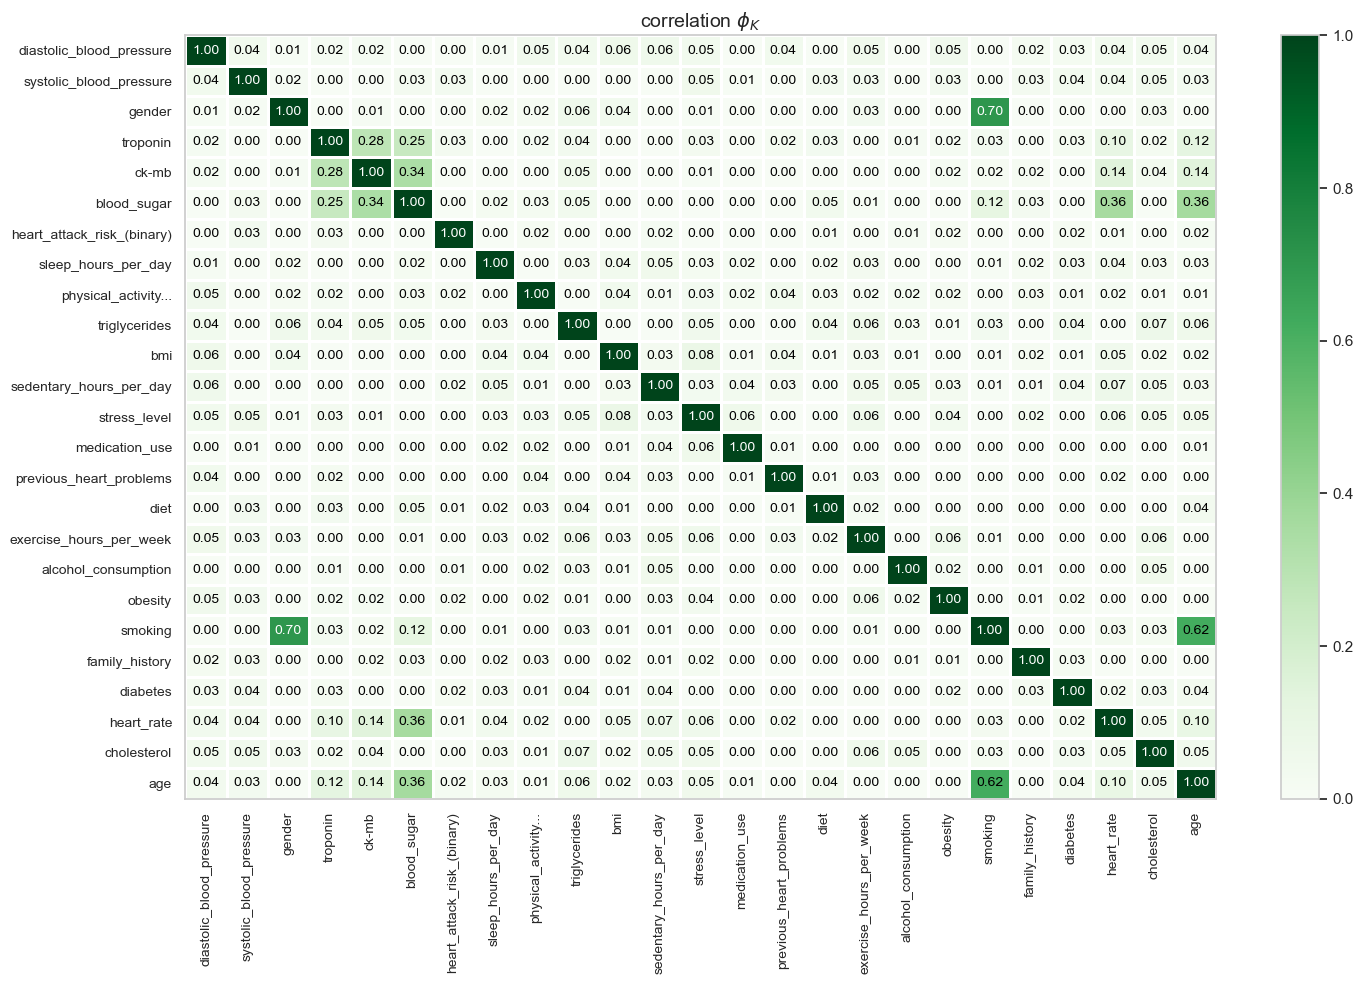

In [101]:
plot_correlation_matrix(
    phik_overview_train.values,
    x_labels=phik_overview_train.columns,
    y_labels=phik_overview_train.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    top=30,
    figsize=(15, 10)
) 

Из матрицы корреляции можно заметить следующее:

- 3 основных предиктора проблем с сердцем имеют уровень корреляции между собой ниже среднего это `troponin`, `ck-mb` и `blood_sugar`
- есть корреляция выше умеренной между признаками `smoking` и `gender` и `smoking` и `age`. Тут же можно сделать предположение что мужчины больше склонны курить чем женщины, это предположение можно проверить на стадии составления "портрета" пациента с высоким риском наступления сердченого приступа.
- есть корреляция ниже умеренной между признаками `blood_sugar` и `age` и `blood_sugar` и `heart_rate`
- с целевым признаком `heart_attack_risk_(binary)` не коррелирует ни один из входных признаков, возможно нам придется создавать синтетические признаки или искать иные способы для построения модели.

Теперь построим такую же матрицу для тестового датасета.

In [102]:
phik_overview_test = heart_test_df.drop('id', axis=1).phik_matrix(interval_cols=num_cols)

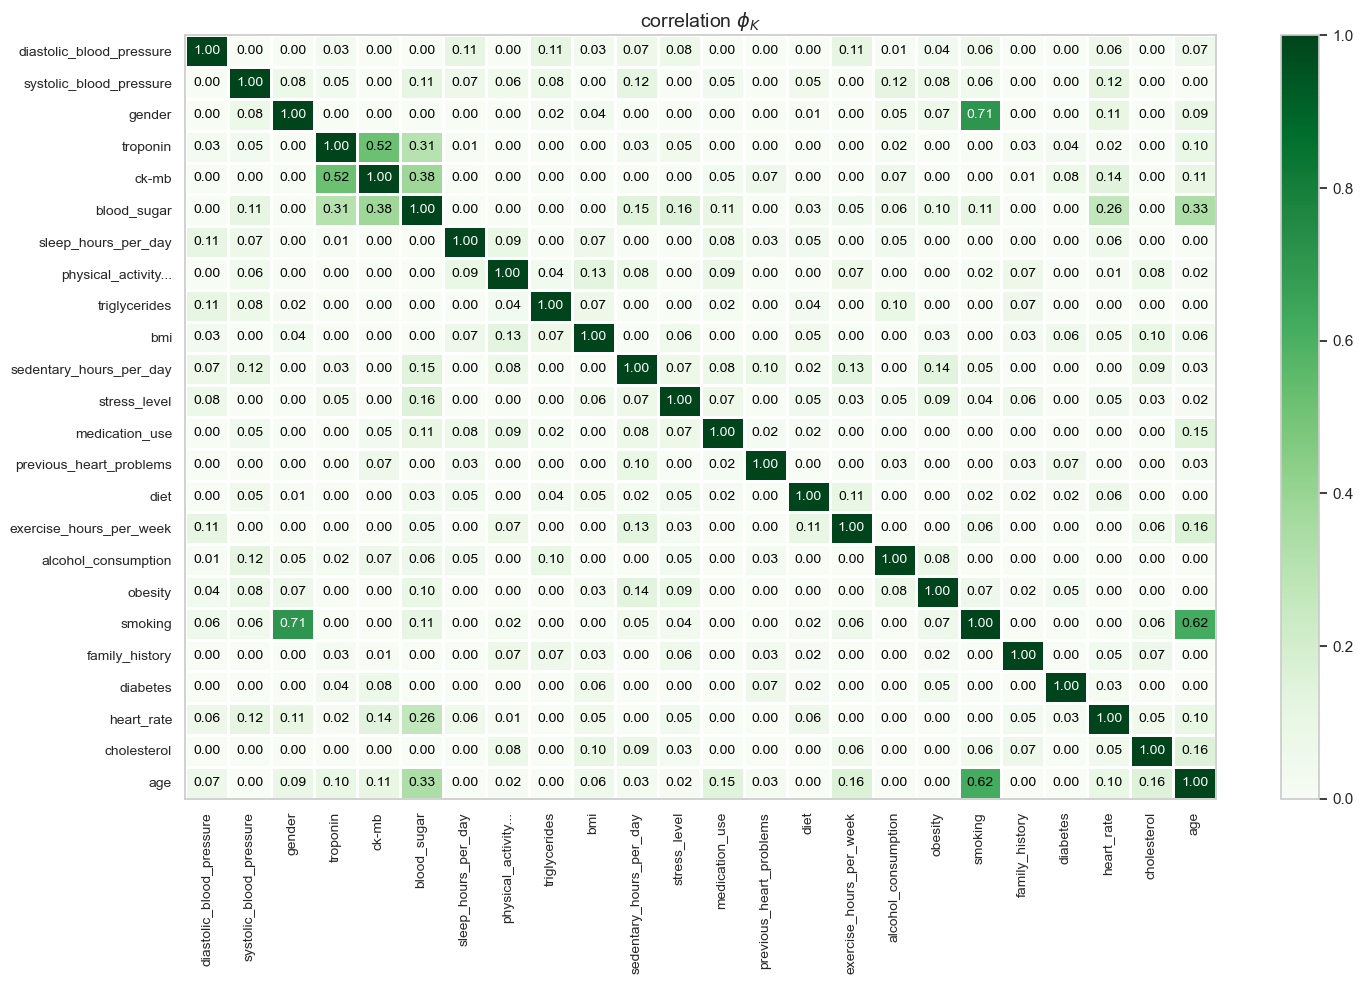

In [103]:
plot_correlation_matrix(
    phik_overview_test.values,
    x_labels=phik_overview_test.columns,
    y_labels=phik_overview_test.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    top=30,
    figsize=(15, 10)
) 

Структура корреляции очень близка к структуре тернировочного датасета. Можно переходить к проектированию моделей.

## Обучение моделей

Все наши параметры закодированы и отмасштабированы за исключением гендера. Закодируем этот параметр вручную.

In [104]:
heart_train_df['gender'] = heart_train_df['gender'].map({'Male': 1, 'Female': 0})

In [105]:
heart_train_df.head()

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0  0.359551     0.732143    0.074244       1.0             1.0      1.0   
1  0.202247     0.325000    0.047663       1.0             1.0      0.0   
2  0.606742     0.860714    0.055912       1.0             0.0      1.0   
3  0.730337     0.007143    0.053162       0.0             0.0      1.0   
4  0.775281     0.757143    0.021998       0.0             0.0      1.0   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0      1.0                  1.0                 0.535505     1   
1      0.0                  1.0                 0.068690     2   
2      1.0                  1.0                 0.944001     2   
3      0.0                  1.0                 0.697023     0   
4      0.0                  1.0                 0.412878     1   

   previous_heart_problems  medication_use  stress_level  \
0                      1.0             0.0           8.0   
1                      1.0             0.0           9.0   
2                      1.0             1.0           6.0   
3                      0.0             1.0           3.0   
4                      0.0             0.0           8.0   

   sedentary_hours_per_day       bmi  triglycerides  \
0                 0.225704  0.459176       0.979221   
1                 0.289923  0.117053       0.515584   
2                 0.550133  0.373574       0.012987   
3                 0.330962  0.049735       0.131169   
4                 0.524600  0.830405       0.070130   

   physical_activity_days_per_week  sleep_hours_per_day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   heart_attack_risk_(binary)  blood_sugar     ck-mb  troponin  gender  \
0                         0.0     0.227018  0.048229  0.036512       1   
1                         0.0     0.150198  0.017616  0.000194       0   
2                         0.0     0.227018  0.048229  0.036512       0   
3                         1.0     0.227018  0.048229  0.036512       0   
4                         1.0     0.227018  0.048229  0.036512       1   

   systolic_blood_pressure  diastolic_blood_pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047

In [106]:
heart_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8442 non-null   float64
 9   diet                             8442 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level             

In [107]:
heart_test_df['gender'] = heart_test_df['gender'].map({'Male': 1, 'Female': 0})

In [108]:
heart_test_df.head()

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0  0.494382     0.264286    0.062328       0.0             1.0      1.0   
1  0.224719     0.953571    0.082493       1.0             0.0      0.0   
2  0.629213     0.092857    0.064161       0.0             1.0      1.0   
3  0.460674     0.567857    0.055912       1.0             1.0      1.0   
4  0.719101     0.485714    0.022915       1.0             0.0      1.0   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0      1.0                  1.0                 0.361618     2   
1      1.0                  0.0                 0.996483     2   
2      1.0                  0.0                 0.995561     0   
3      1.0                  1.0                 0.437277     0   
4      0.0                  1.0                 0.514920     0   

   previous_heart_problems  medication_use  stress_level  \
0                      0.0             0.0           8.0   
1                      1.0             1.0           5.0   
2                      0.0             0.0          10.0   
3                      0.0             0.0          10.0   
4                      0.0             0.0           7.0   

   sedentary_hours_per_day       bmi  triglycerides  \
0                 0.194370  0.283490       0.306494   
1                 0.329888  0.467036       0.087013   
2                 0.780075  0.409366       0.205195   
3                 0.785071  0.910261       0.163636   
4                 0.070919  0.758924       0.580519   

   physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
0                              1.0             0.333333     0.227018   
1                              0.0             0.166667     0.227018   
2                              7.0             1.000000     0.102767   
3                              0.0             0.666667     0.203557   
4                              5.0             0.000000     0.227018   

      ck-mb  troponin  gender  systolic_blood_pressure  \
0  0.048229  0.036512       1                 0.283871   
1  0.048229  0.036512       0                 0.703226   
2  0.002666  0.088455       1                 0.458065   
3  0.056390  0.271774       0                 0.741935   
4  0.048229  0.036512       1                 0.412903   

   diastolic_blood_pressure    id  
0                  0.372093  7746  
1                  0.441860  4202  
2                  0.779070  6632  
3                  0.255814  4639  
4                  0.395349  4825

Теперь наши датасеты готовы к обучению и предсказанию.

Теперь приступим к самому процессу обучения моделей.

Для поиска гиперпараметров мы будем использовать OptunaSearch, а первой моделью мы попробуем обучить LGBMClassifier.

Перед этим разделим датасет на обучающую и валидационную выборки.

In [109]:
X = heart_train_df.drop(['id', 'heart_attack_risk_(binary)'], axis=1)
y = heart_train_df['heart_attack_risk_(binary)']

# Разделяем данные ЗАРАНЕЕ, чтобы они были одинаковыми для всех trial'ов
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
    )

In [110]:
def objective_lgbm(trial):
    """Целевая функция для LightGBM с поддержкой pruning."""
    
    params = {
        'objective': 'binary',
        'metric': ['binary_logloss', 'auc'], 
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE
    }
    
    model = lgb.LGBMClassifier(**params)
    
    # 1. Создаем callback для pruning
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc')
    
    # 2. Создаем callback для ранней остановки (вместо параметра в fit)
    # verbose=False, чтобы не засорять вывод Optuna логами от LGBM
    early_stopping_callback = lgb.early_stopping(50, verbose=False)
    
    # 3. Передаем ОБА callback в метод fit
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              callbacks=[pruning_callback, early_stopping_callback] 
              )
              
    preds = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc

In [111]:
study_lgbm = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=20),
    direction='maximize'
)
# Для наглядности можно уменьшить n_trials
study_lgbm.optimize(objective_lgbm, n_trials=200)

print("\nЛучшие параметры для LightGBM:", study_lgbm.best_params)
print("Лучшее значение ROC AUC:", study_lgbm.best_value)

[I 2025-09-16 11:01:05,061] A new study created in memory with name: no-name-062157ca-586a-4f56-826c-3a248b83f095
[I 2025-09-16 11:01:05,334] Trial 0 finished with value: 0.539837214715023 and parameters: {'n_estimators': 1800, 'learning_rate': 0.12554787021157499, 'num_leaves': 223, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.6292669968816528, 'colsample_bytree': 0.7253145693138331, 'reg_alpha': 2.8575289331111355e-07, 'reg_lambda': 4.5231232951506874e-06}. Best is trial 0 with value: 0.539837214715023.
[I 2025-09-16 11:01:05,397] Trial 1 finished with value: 0.5198156808211435 and parameters: {'n_estimators': 600, 'learning_rate': 0.2830694989789544, 'num_leaves': 175, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.9885333979674198, 'colsample_bytree': 0.6989238194386653, 'reg_alpha': 0.0009594756217638516, 'reg_lambda': 0.004425241994288961}. Best is trial 0 with value: 0.539837214715023.
[I 2025-09-16 11:01:05,506] Trial 2 finished with value: 0.54781854418359


Лучшие параметры для LightGBM: {'n_estimators': 900, 'learning_rate': 0.20106043218197944, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 91, 'subsample': 0.8741080625768363, 'colsample_bytree': 0.7825906790797154, 'reg_alpha': 0.03062265978119056, 'reg_lambda': 9.325131136633883e-06}
Лучшее значение ROC AUC: 0.5835968839418957


Лучшее значение метрики ROC AUC: 0.58 это может говорить о том, что предсказания модели близки к случайному угадыванию и модель не смогла найти каких-либо закономерностей в данных.

Попробуем обучить модель CatBoostClassifier.

In [112]:
def objective_catboost(trial):
    """Целевая функция для CatBoost с поддержкой pruning."""
    
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1, 20),
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': 0
    }
    
    model = cb.CatBoostClassifier(**params)
    
    pruning_callback = optuna.integration.CatBoostPruningCallback(trial, 'AUC')
    
    # Обучаем модель. Если trial будет отсечен, здесь будет выброшено исключение TrialPruned,
    # и дальнейший код в этой функции для этого trial'а не выполнится.
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50,
              callbacks=[pruning_callback],
              verbose=0
              )

    # Этот код выполнится только для тех trial'ов, которые не были отсечены
    preds = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc


In [113]:
# Создаем и запускаем исследование
study_catboost = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction='maximize'
)
study_catboost.optimize(objective_catboost, n_trials=50)

print("\nЛучшие параметры для CatBoost:", study_catboost.best_params)
print("Лучшее значение ROC AUC:", study_catboost.best_value)

[I 2025-09-16 11:01:23,668] A new study created in memory with name: no-name-b3653822-dce3-493b-b4d5-b162b749770a
/var/folders/66/wf8d9hgj0dxfwc469z_9smcw0000gn/T/ipykernel_29592/2546591911.py:19: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = optuna.integration.CatBoostPruningCallback(trial, 'AUC')
[I 2025-09-16 11:01:24,120] Trial 0 finished with value: 0.5484033429365502 and parameters: {'iterations': 998, 'learning_rate': 0.12703744342605078, 'depth': 5, 'l2_leaf_reg': 0.25005728155258666, 'border_count': 184, 'random_strength': 11.285543328641266}. Best is trial 0 with value: 0.5484033429365502.
/var/folders/66/wf8d9hgj0dxfwc469z_9smcw0000gn/T/ipykernel_29592/2546591911.py:19: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = optuna.integration.CatBoostPruningCallback(trial, 'AUC')
[I 20


Лучшие параметры для CatBoost: {'iterations': 1498, 'learning_rate': 0.1430449208217422, 'depth': 9, 'l2_leaf_reg': 0.0016560848963157596, 'border_count': 62, 'random_strength': 9.006310885440307}
Лучшее значение ROC AUC: 0.5920686424649952


Здесь получается такая же ситуация как и с первой моделью. 

Попробуем прямо "на месте" посмотреть как различаются средние значения и распредление непрерывных признаков для категорий таргета. 

Начнем со средних значений:

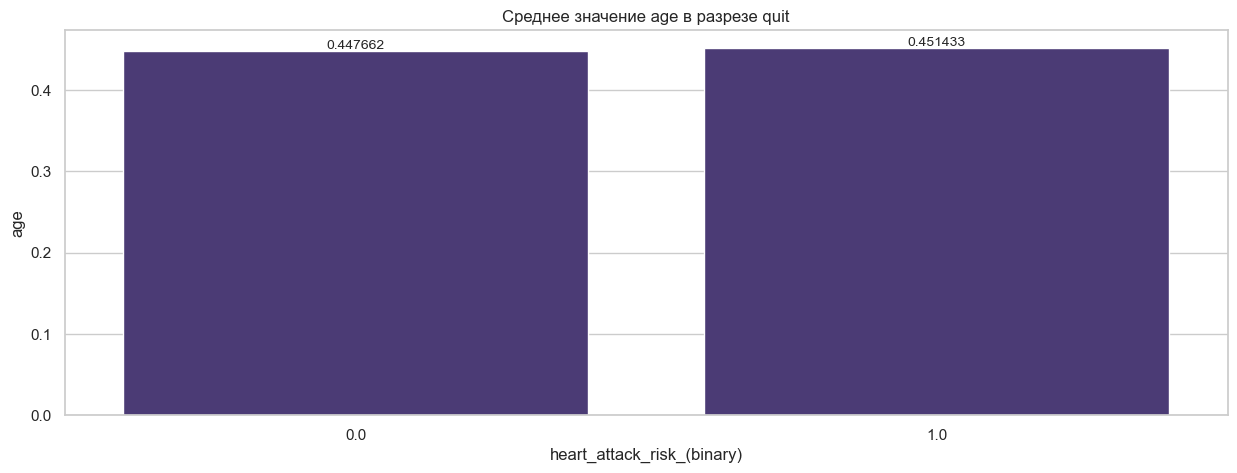

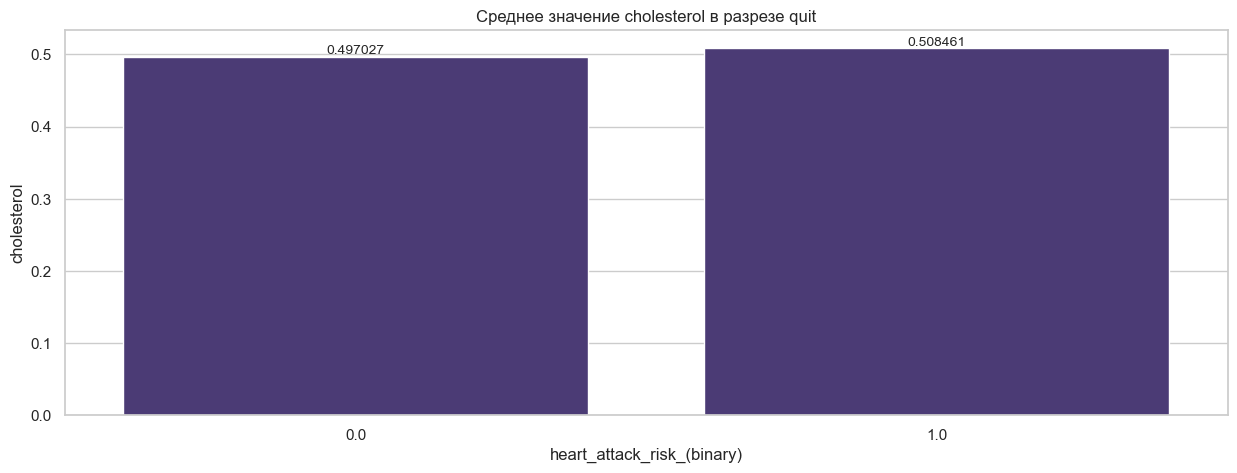

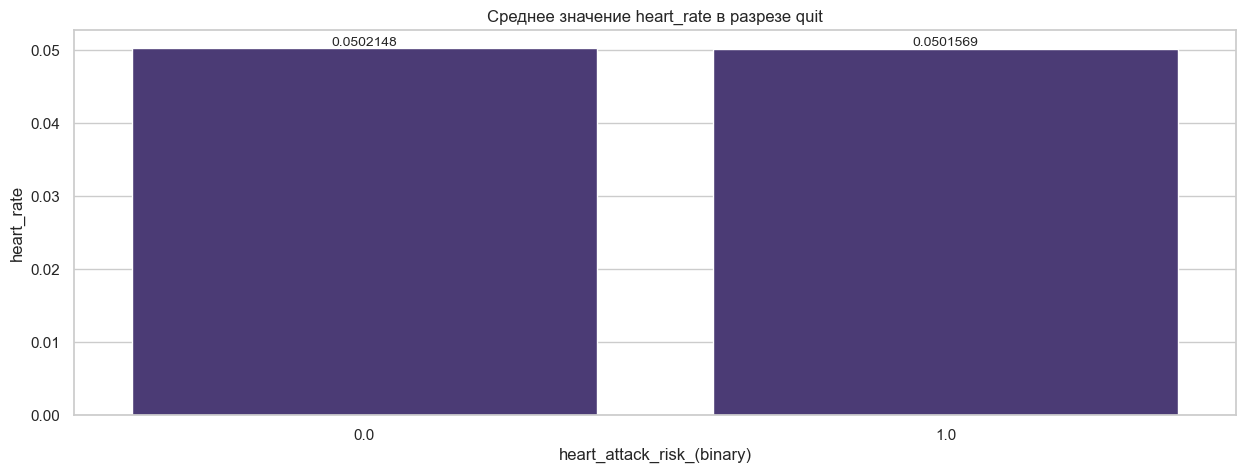

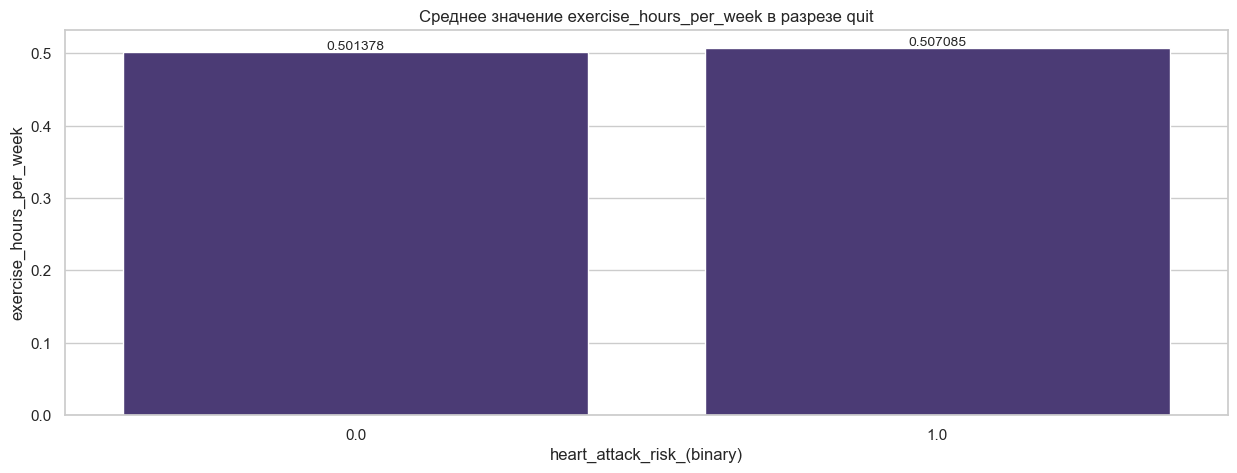

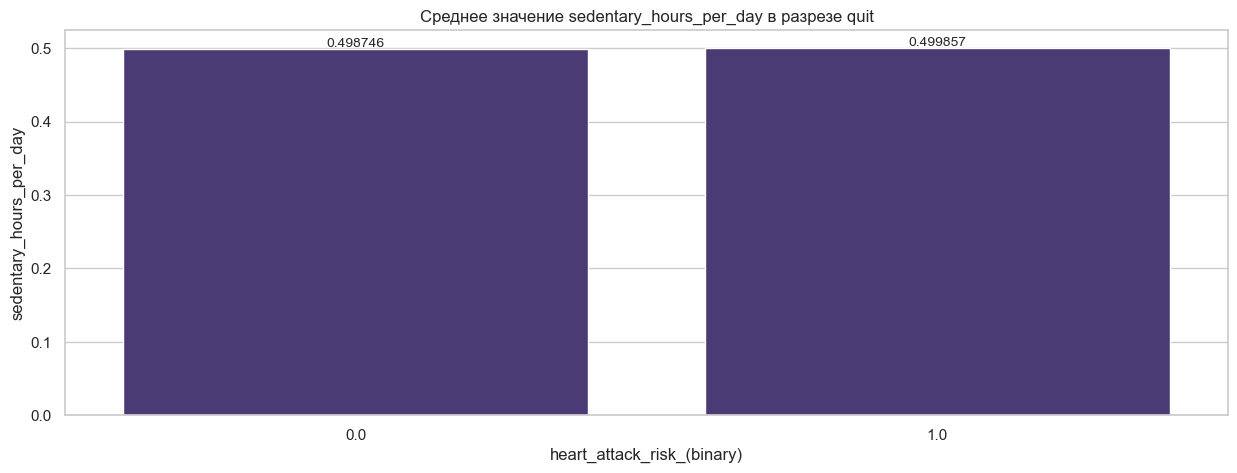

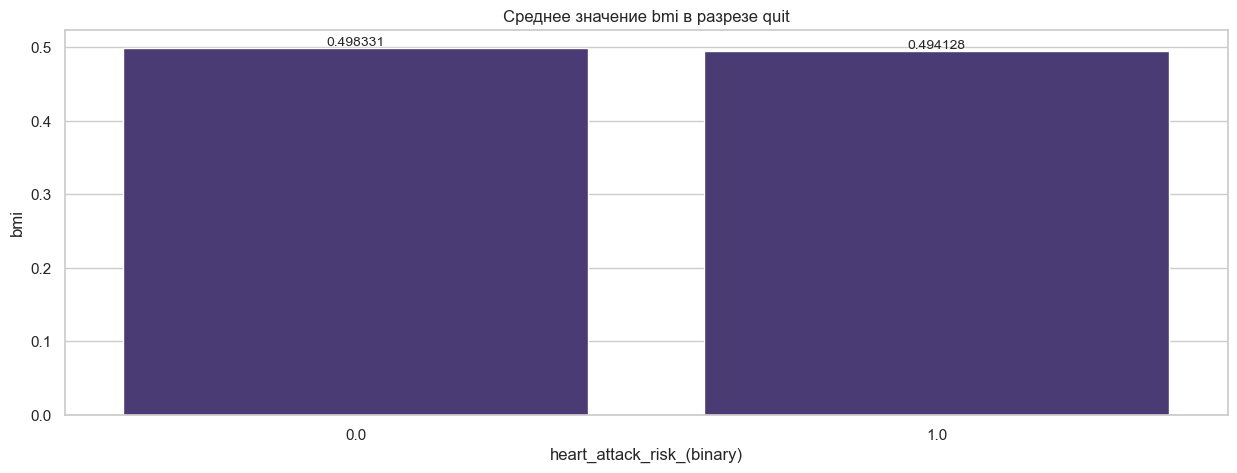

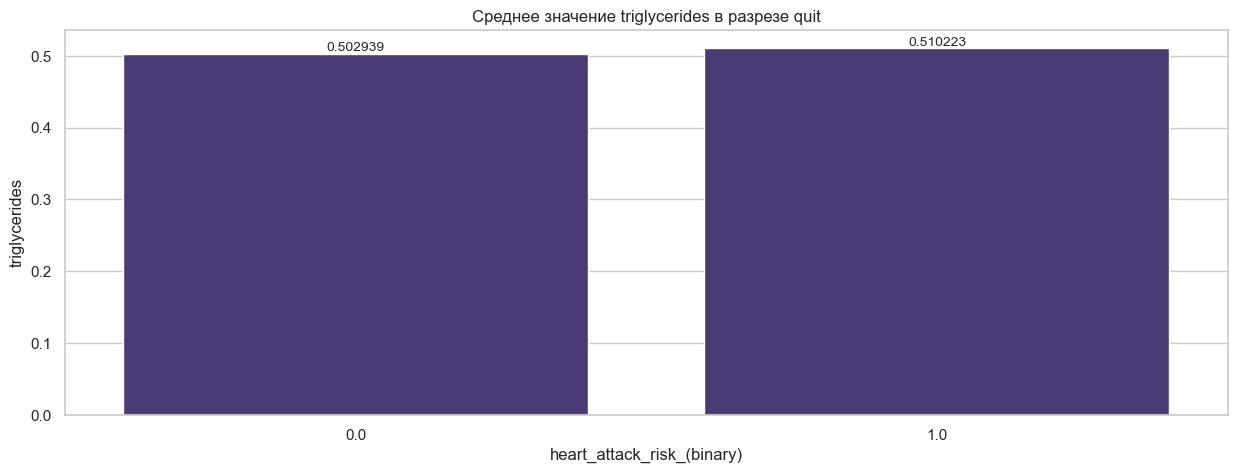

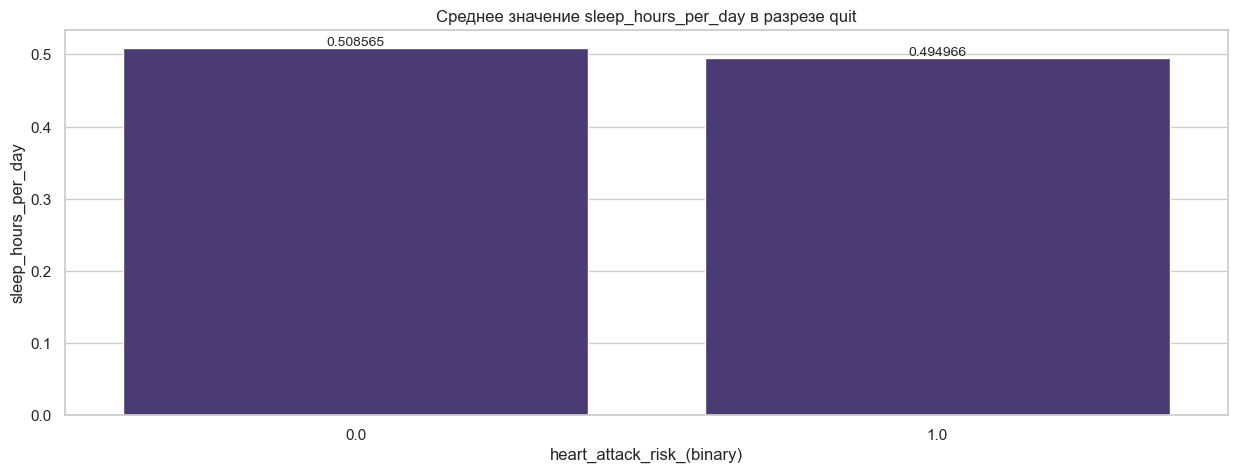

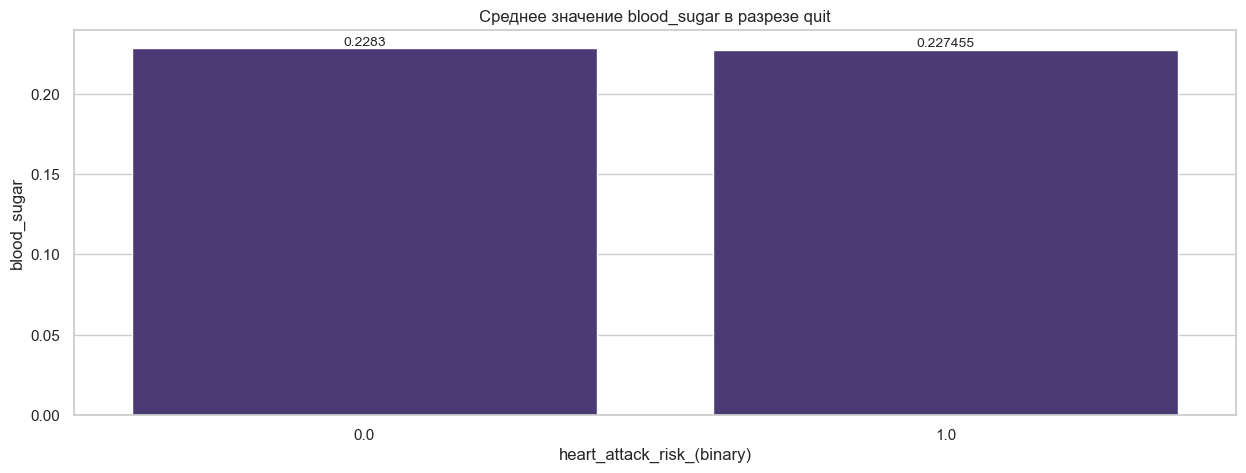

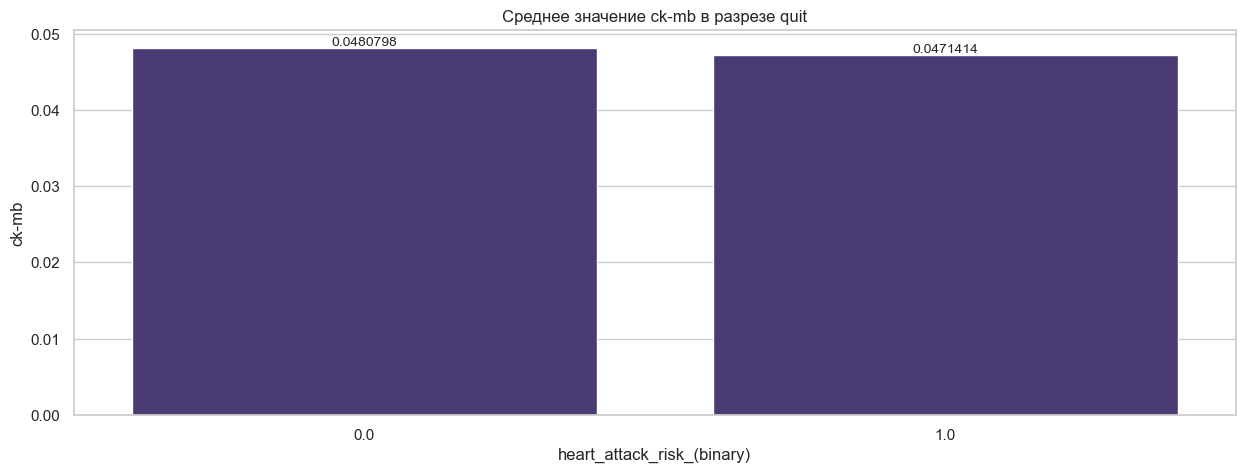

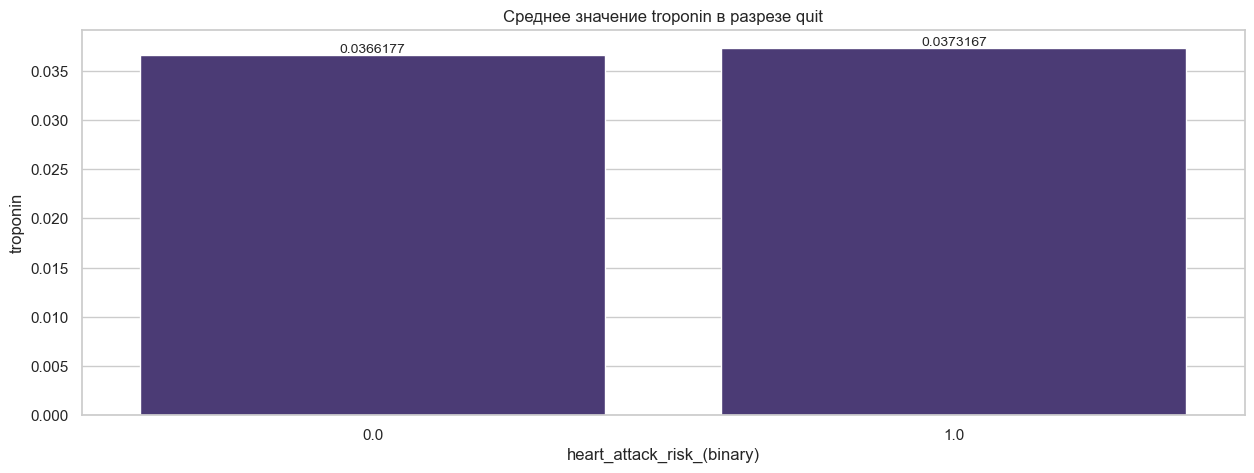

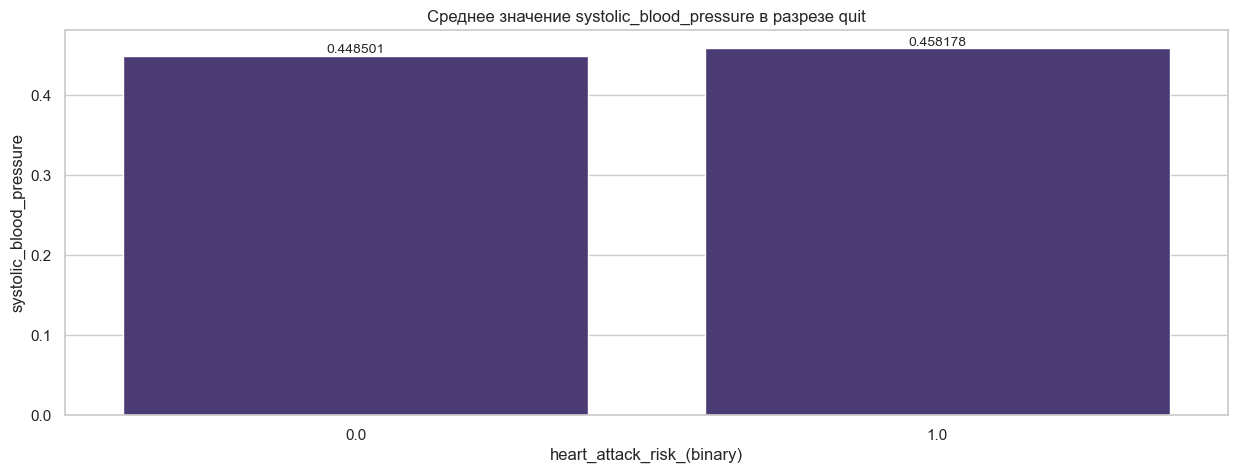

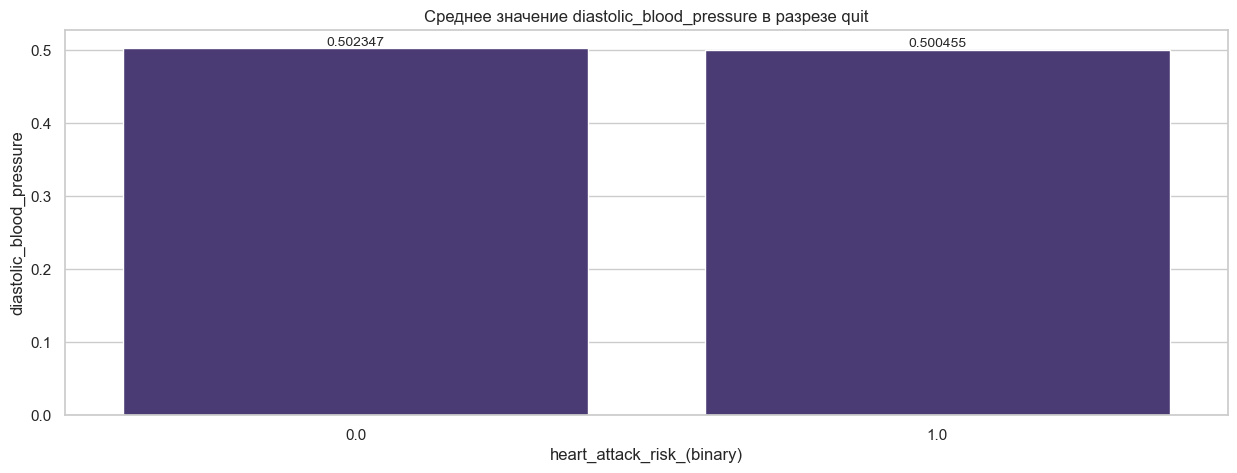

In [114]:
for col in num_cols:
    plt.figure(figsize=(15, 5))
    plt.title(f'Среднее значение {col} в разрезе quit')
    ax = sns.barplot(
        data=heart_train_df, 
        x='heart_attack_risk_(binary)', 
        y=col,
        errorbar=None,
        estimator='mean'
        );
    ax.bar_label(ax.containers[0], fontsize=10);
    plt.show()

Средние значения близки по значению друг к другу для двух категорий. Теперь посомтрим на их распределения в разрезе таргета.

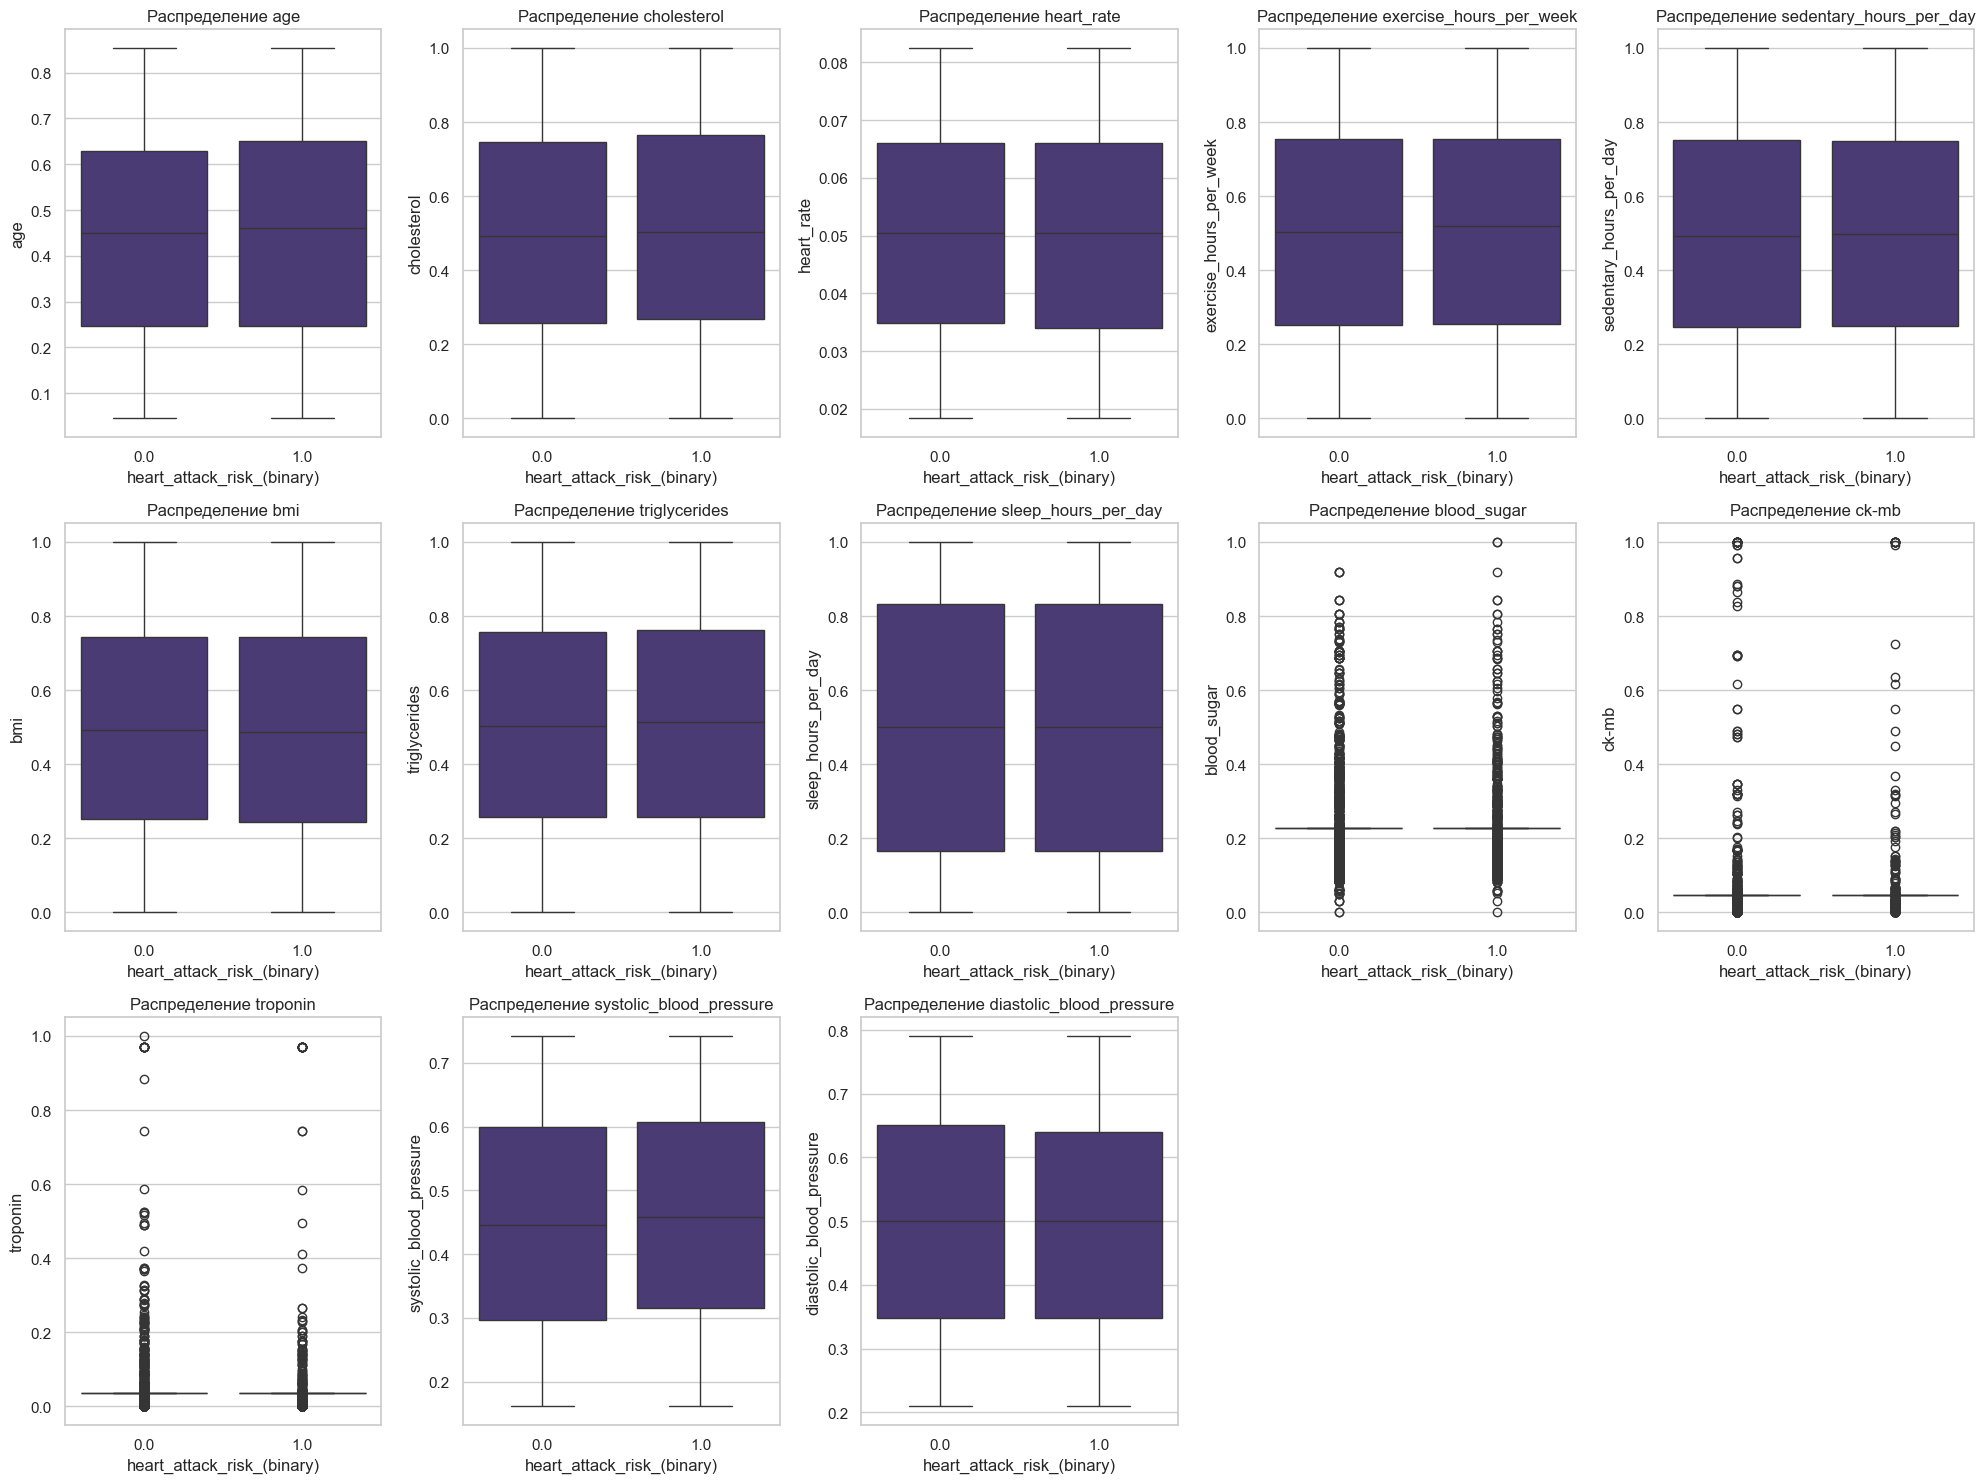

In [115]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(num_cols, 1):
    plt.subplot(3, 5, i)
    sns.boxplot(data=heart_train_df, x='heart_attack_risk_(binary)', y=feature)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

Распределения для двух категорий выглядят почти одинаково, что подтверждает тот факт, что модель не может найти никаких закономерностей в данных.

Попробуем посмотреть на распределения для категориальных признаков в разрезе целевого.

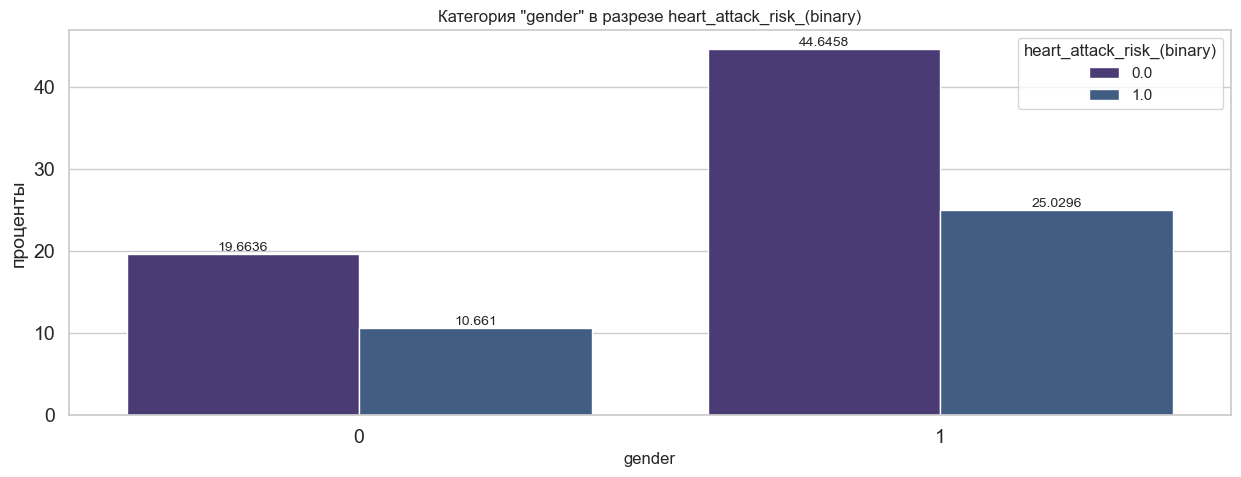

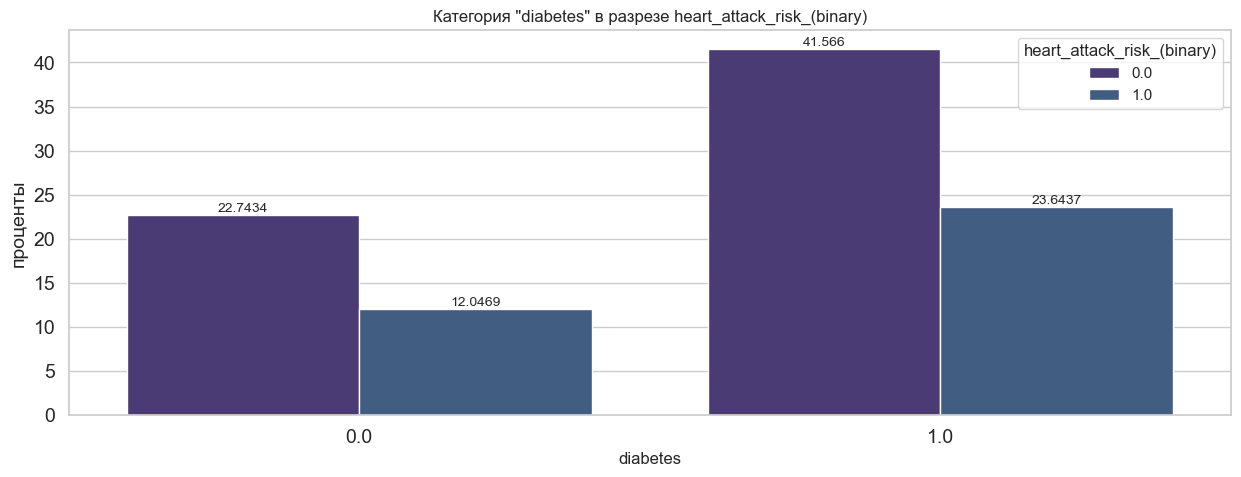

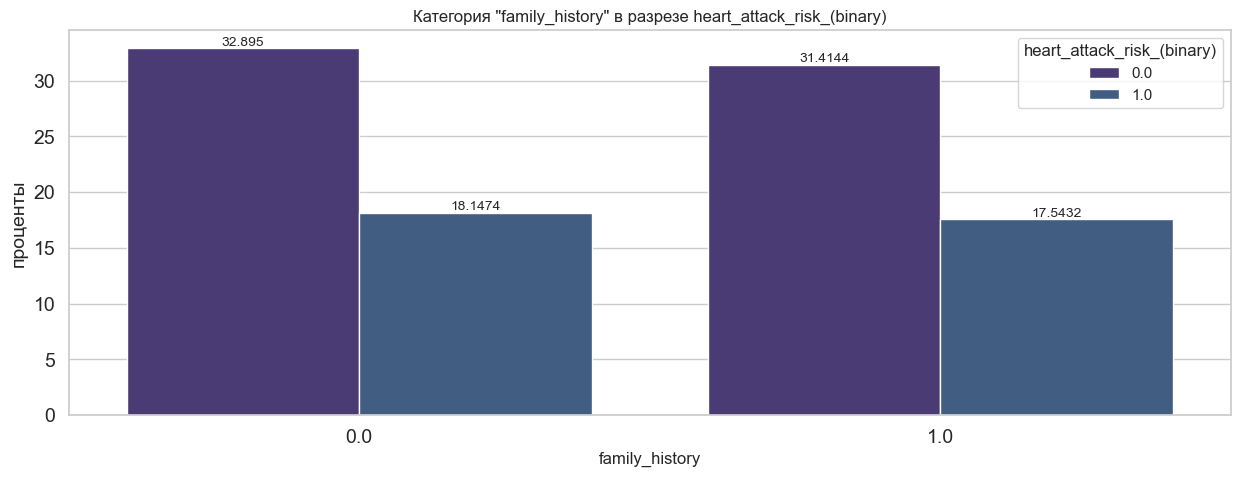

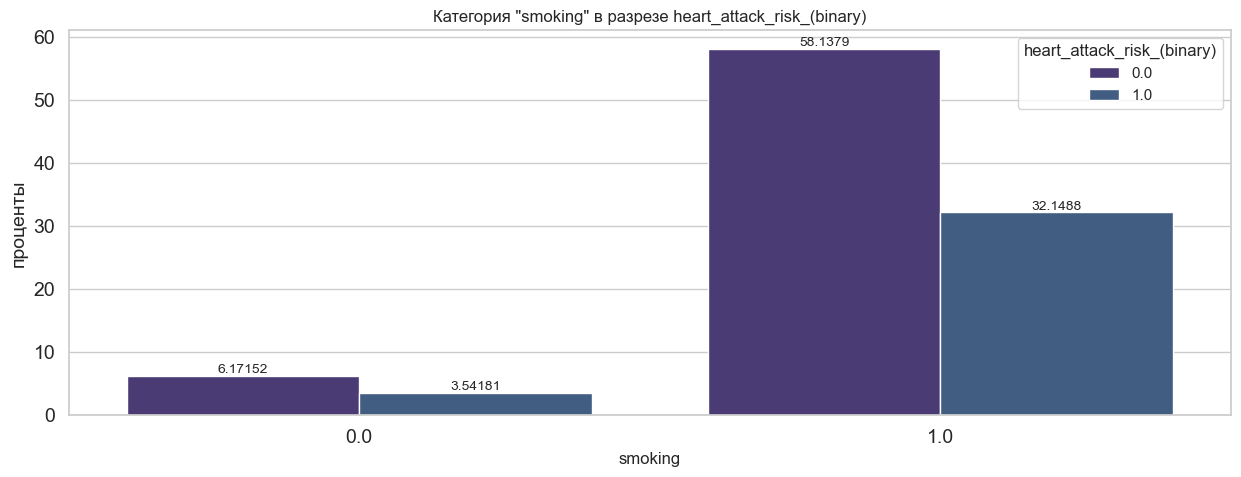

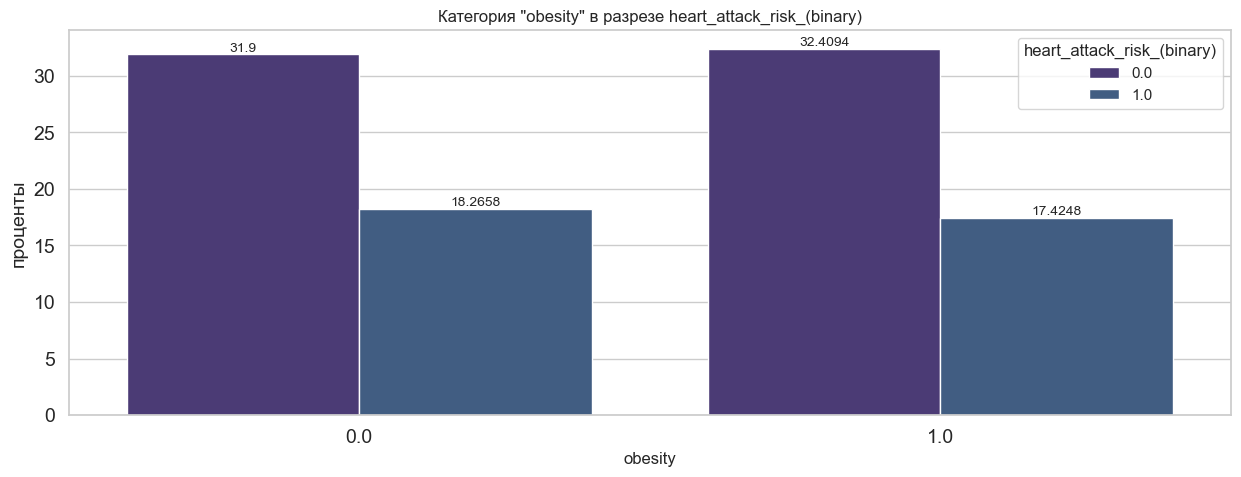

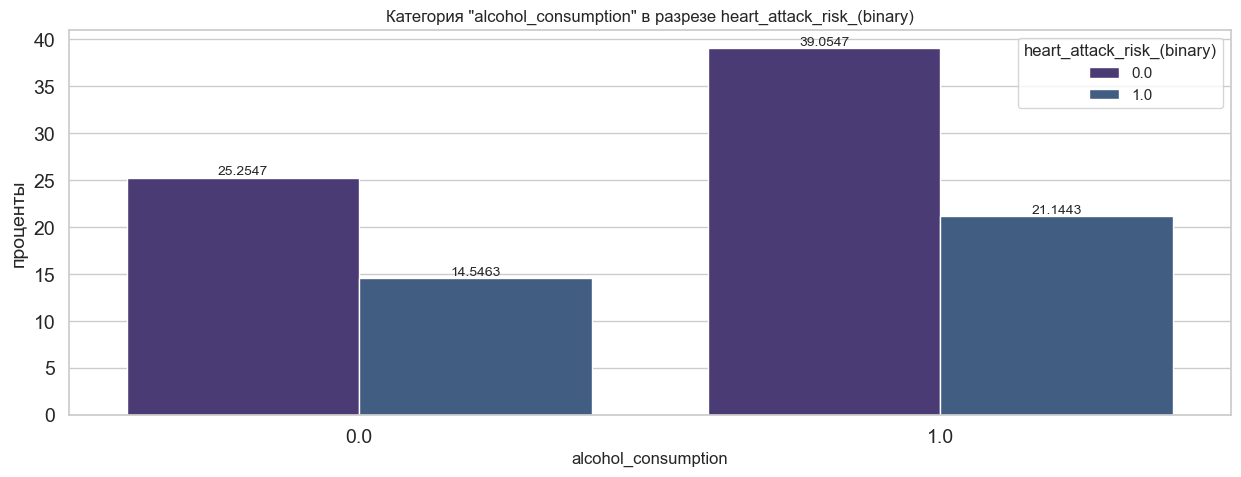

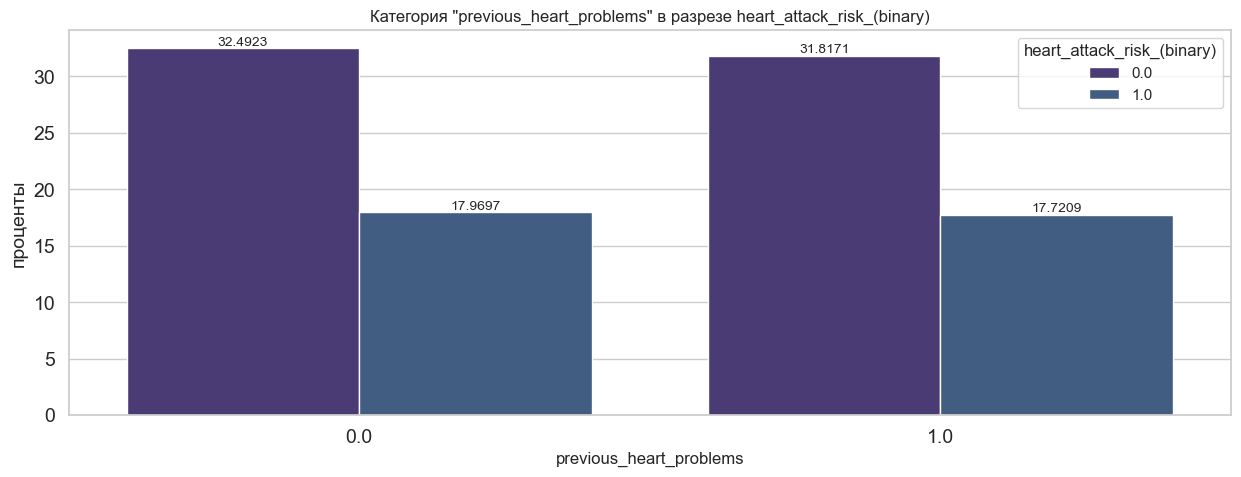

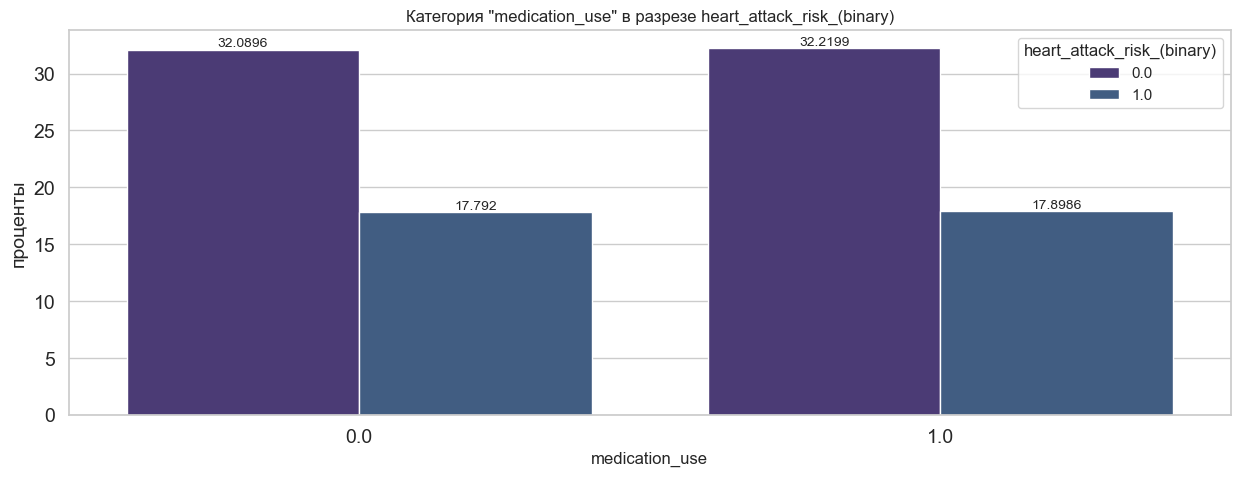

In [116]:
for col in cat_cols:
    plt.figure(figsize=(15, 5))
    sns.countplot(
        heart_train_df, 
        x=col,
        hue="heart_attack_risk_(binary)", 
        legend=True,
        stat='percent'
    )
    ax = plt.gca()
    ax.bar_label(ax.containers[0], fontsize=10);
    ax.bar_label(ax.containers[1], fontsize=10);
    ax.tick_params(labelsize=14)
    ax.set_ylabel("проценты", fontsize=14)
    plt.title(f'Категория "{col}" в разрезе heart_attack_risk_(binary)')
    plt.show();

Здесь мы также видим что графики почти похожи друг на друга и сохрнаяют свои пропорции относительно друг друга.

# Итоговый вывод

Из построения моделей и дополнительного исследования данных можно сделать вывод о том, что в данных отсутствует какой-либо предсказательный сигнал для обучения. Об этом говорят графики исследовательского анализа, корреляционного анализа и результаты обучения моделей. Дополнительно, данные очень похожи на синтетические, распределения почти везде равномерные.

Также мы попытались создать новые индикаторы на основе суммы/произведения группы признаков, например параметр "образ жизни", состоящий из суммы признаков "курение", "алкоголь", "употребление медикаментов". Пробовали возводить признаки в разные степени. Это не дало никакого положительного эффекта.

Теперь выгрузим лучшую модель LightGBM в файл для реализации в приложении.

In [117]:
# 1. Получаем лучшие гиперпараметры из завершенного исследования
best_params = study_lgbm.best_params
print("\nЛучшие параметры для LightGBM:", best_params)
print("Лучшее значение ROC AUC на валидации:", study_lgbm.best_value)

# 2. Создаем финальную модель с этими лучшими параметрами
final_model = lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE)

# 3. Обучаем финальную модель. 
# Лучшая практика - объединить обучающую и валидационную выборки, 
# чтобы использовать все доступные данные для обучения финальной модели.

print("\nОбучаем финальную модель на всех доступных данных...")
final_model.fit(X, y)
print("Финальная модель обучена.")

# 4. Сохраняем обученную финальную модель с помощью joblib
model_filename = 'lgbm_final_model.joblib'
joblib.dump(final_model, model_filename)

print(f"✅ Модель успешно сохранена в файл: {model_filename}")

# Теперь вы можете загрузить ее в любом другом месте:
# loaded_model = joblib.load(model_filename)


Лучшие параметры для LightGBM: {'n_estimators': 900, 'learning_rate': 0.20106043218197944, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 91, 'subsample': 0.8741080625768363, 'colsample_bytree': 0.7825906790797154, 'reg_alpha': 0.03062265978119056, 'reg_lambda': 9.325131136633883e-06}
Лучшее значение ROC AUC на валидации: 0.5835968839418957

Обучаем финальную модель на всех доступных данных...
Финальная модель обучена.
✅ Модель успешно сохранена в файл: lgbm_final_model.joblib


Также выгрузим предобработанный тестовый датасет для предсказаний с использованием API.

In [118]:
heart_test_df.to_csv('heart_test_preprocessed.csv', index=False)

In [122]:
heart_test_df.sort_values(by='id')

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
275  0.595506     0.314286    0.047663       0.0             0.0      1.0   
95   0.078652     0.960714    0.071494       1.0             1.0      1.0   
939  0.786517     0.375000    0.048579       1.0             1.0      1.0   
216  0.584270     0.935714    0.066911       0.0             1.0      1.0   
813  0.853933     0.160714    0.058662       0.0             1.0      1.0   
..        ...          ...         ...       ...             ...      ...   
558  0.325843     0.185714    0.044913       1.0             0.0      1.0   
384  0.617978     0.000000    0.065995       0.0             1.0      1.0   
115  0.775281     0.146429    0.056829       1.0             1.0      1.0   
338  0.775281     0.350000    0.024748       0.0             0.0      1.0   
913  0.528090     0.260714    0.036664       1.0             0.0      1.0   

     obesity  alcohol_consumption  exercise_hours_per_week  diet  \
275      0.0                  0.0                 0.208326     0   
95       1.0                  1.0                 0.090557     2   
939      1.0                  1.0                 0.173545     1   
216      0.0                  1.0                 0.292691     1   
813      1.0                  0.0                 0.284116     2   
..       ...                  ...                      ...   ...   
558      0.0                  0.0                 0.031965     0   
384      0.0                  1.0                 0.716308     0   
115      1.0                  1.0                 0.058553     1   
338      1.0                  0.0                 0.020434     0   
913      0.0                  0.0                 0.511968     0   

     previous_heart_problems  medication_use  stress_level  \
275                      0.0             0.0           9.0   
95                       1.0             0.0           1.0   
939                      0.0             0.0           4.0   
216                      1.0             1.0           4.0   
813                      0.0             1.0           3.0   
..                       ...             ...           ...   
558                      0.0             1.0           3.0   
384                      1.0             1.0           2.0   
115                      1.0             1.0           8.0   
338                      0.0             0.0           8.0   
913                      0.0             1.0           1.0   

     sedentary_hours_per_day       bmi  triglycerides  \
275                 0.551234  0.602363       0.332468   
95                  0.413584  0.417945       0.266234   
939                 0.572033  0.146128       0.971429   
216                 0.495582  0.596568       0.279221   
813                 0.910359  0.447749       0.297403   
..                       ...       ...            ...   
558                 0.718866  0.335835       0.989610   
384                 0.430576  0.625470       0.289610   
115                 0.428768  0.280376       0.353247   
338                 0.398771  0.631058       0.950649   
913                 0.822890  0.912742       0.641558   

     physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
275                              0.0             0.333333     0.227018   
95                               1.0             0.500000     0.227018   
939                              7.0             0.666667     0.227018   
216                              2.0             0.000000     0.227018   
813                              5.0             0.666667     0.227018   
..                               ...                  ...          ...   
558                              3.0             1.000000     0.227018   
384                              7.0             0.833333     0.227018   
115                              1.0             0.666667     0.227018   
338                              7.0             0.833333     0.227018   
913                     